# HOMO-LUMO Gap Predictions

### Problem Statement & Motivation

Accurately predicting quantum chemical properties like the HOMO–LUMO energy gap is essential for advancing materials science, drug discovery, and electronic design. The HOMO–LUMO gap is particularly informative for assessing molecular reactivity and stability. While Density Functional Theory (DFT) provides precise estimates, its high computational cost makes it impractical for large-scale screening of molecular libraries. This notebook explores machine learning alternatives that are fast, scalable, and interpretable, offering solutions that are accessible even on modest hardware.

### Related Work & Key Gap

Past work has shown that:

* DFT is accurate but computationally intensive
* ML models like kernel methods and GNNs show promise, but often require large models and expensive hardware

Key Gap: A need for lightweight, high-performing models that can run locally and integrate with user-friendly tools for deployment in research or education.

### Methodology & Evaluation

This notebook:

* Benchmarks a variety of 2D-based models using RDKit descriptors, Coulomb matrices, and graph neural networks (GNNs) on a 5k molecule subset
* Progresses to a hybrid GNN architecture combining OGB-standard graphs with SMILES-derived cheminformatics features
* Achieves **MAE = 0.159 eV**
* Visualizes results using parity plots, error inspection, and predicted-vs-true comparisons
* Evaluates both random and high-error cases to better understand model behavior

| Metric   | Best Model (Hybrid GNN) |
| -------- | ----------------------- |
| **MAE**  | 0.159 eV                |
| **RMSE** | 0.234 eV                |
| **R²**   | 0.965                   |


### Deployment & Accessibility

To make the model practically useful, an **interactive web app** was developed:

**Live App**: [HOMO–LUMO Gap Predictor on Hugging Face](https://huggingface.co/spaces/MooseML/homo-lumo-gap-predictor)

Features:

* **SMILES input** for any organic molecule
* **Real-time prediction** of the HOMO–LUMO gap
* **Molecular visualization**
* Simple **CSV logging** for result tracking

GitHub Repository: [MooseML/homo-lumo-gap-models](https://github.com/MooseML/homo-lumo-gap-models)


In [11]:
# general 
import pandas as pd
import numpy as np
from tqdm import tqdm
import ace_tools_open as tools
import optuna
import optuna.visualization as vis
import pickle
import joblib
import os 

# plotting 
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Module, Sequential, Dropout
from torch.utils.data import Subset
import torch.optim as optim
# PyTorch Geometric
from torch_geometric.nn import GINEConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from transformers import get_cosine_schedule_with_warmup

# OGB dataset 
from ogb.lsc import PygPCQM4Mv2Dataset, PCQM4Mv2Dataset
from ogb.utils import smiles2graph
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder

# RDKit
# from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import Chem

# ChemML
from chemml.chem import Molecule, RDKitFingerprint, CoulombMatrix, tensorise_molecules
from chemml.models import MLP, NeuralGraphHidden, NeuralGraphOutput
from chemml.utils import regression_metrics

# SKlearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor

In [12]:
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("CUDA available:", tf.test.is_built_with_gpu_support())
print(tf.config.list_physical_devices('GPU'))
# list all GPUs
gpus = tf.config.list_physical_devices('GPU')

# check compute capability if GPU available
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print(f"Device: {gpu.name}")
        print(f"Compute Capability: {details.get('compute_capability')}")
else:
    print("No GPU found.")

TensorFlow version: 2.10.0
Built with CUDA: True
CUDA available: True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device: /physical_device:GPU:0
Compute Capability: (8, 6)


In [13]:
# Paths - Fixed for Kaggle environment
if os.path.exists('/kaggle'):
    DATA_ROOT = '/kaggle/input/neurips-open-polymer-prediction-2025'
    CHUNK_DIR = '/kaggle/working/processed_chunks'  # Writable directory
    BACKBONE_PATH = '/kaggle/input/polymer/best_gnn_transformer_hybrid.pt'
else:
    DATA_ROOT = 'data'
    CHUNK_DIR = os.path.join(DATA_ROOT, 'processed_chunks')
    BACKBONE_PATH = 'best_gnn_transformer_hybrid.pt'

TRAIN_LMDB = os.path.join(CHUNK_DIR, 'polymer_train3d_dist.lmdb')
TEST_LMDB = os.path.join(CHUNK_DIR, 'polymer_test3d_dist.lmdb')

print(f"Data root: {DATA_ROOT}")
print(f"LMDB directory: {CHUNK_DIR}")
print(f"Train LMDB: {TRAIN_LMDB}")
print(f"Test LMDB: {TEST_LMDB}")

# Create LMDBs if they don't exist
if not os.path.exists(TRAIN_LMDB) or not os.path.exists(TEST_LMDB):
    print('Building LMDBs...')
    os.makedirs(CHUNK_DIR, exist_ok=True)
    # Run the LMDB builders
    !python build_polymer_lmdb_fixed.py train
    !python build_polymer_lmdb_fixed.py test
    print('LMDB creation complete.')
else:
    print('LMDBs already exist.')


Data root: data
LMDB directory: data\processed_chunks
Train LMDB: data\processed_chunks\polymer_train3d_dist.lmdb
Test LMDB: data\processed_chunks\polymer_test3d_dist.lmdb
LMDBs already exist.


In [14]:
# /path/to/your_script.py
import os
import pandas as pd


train_path = os.path.join(DATA_ROOT, 'train.csv')
train_df   = pd.read_csv(train_path)

#  Keep only the columns we care about 
target_cols = ['SMILES', 'Tg', 'FFV', 'Tc', 'Density', 'Rg']
train_df   = train_df[target_cols]        # drops id and any other columns

#  Sample a subset (optional) 
n = len(train_df)
subset_size = n                         # change to whatever you need
subset_df   = train_df.sample(subset_size, random_state=42)

#  Save the subset as a CSV 
subset_path = os.path.join(DATA_ROOT, 'train_subset.csv')
subset_df.to_csv(subset_path, index=False)

print(f"Saved CSV with shape: {subset_df.shape}")
print(subset_df.head())

Saved CSV with shape: (7973, 6)
                                                 SMILES  Tg       FFV  \
7560  *C=Cc1ccc2c3ccc(*)cc3n(-c3ccc(OCCCCCCCCCC)c(OC... NaN  0.386695   
1405                  *CC(=O)NCCCCCCNC(=O)Cc1ccc(O*)cc1 NaN  0.335504   
5196                              *CC(*)c1ccccc1C(=O)NC NaN  0.355580   
2087  *c1ccc2c(c1)C(=O)N(c1ccc(Oc3ccc(N4C(=O)c5ccc(-... NaN  0.401573   
3337                    *CC(*)OC(=O)c1ccc(-c2ccccc2)cc1 NaN  0.353609   

            Tc  Density  Rg  
7560       NaN      NaN NaN  
1405       NaN      NaN NaN  
5196  0.183667      NaN NaN  
2087       NaN      NaN NaN  
3337       NaN      NaN NaN  


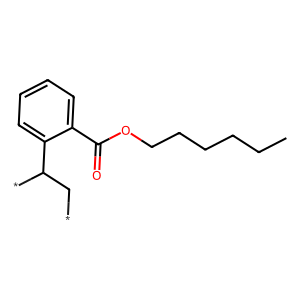

In [15]:
mol = Molecule(subset_df['SMILES'][0], input_type='smiles')
mol.visualize()

In [16]:
df = pd.read_csv(subset_path)
print(f"Loaded {len(df)} molecules.")

Loaded 7973 molecules.


In [17]:
df.head(5)

,SMILES,Tg,FFV,Tc,Density,Rg
0,*C=Cc1ccc2c3ccc(*)cc3n(-c3ccc(OCCCCCCCCCC)c(OC...,NaN,0.386695,NaN,NaN,NaN
1,*CC(=O)NCCCCCCNC(=O)Cc1ccc(O*)cc1,NaN,0.335504,NaN,NaN,NaN
2,*CC(*)c1ccccc1C(=O)NC,NaN,0.355580,0.183667,NaN,NaN
3,*c1ccc2c(c1)C(=O)N(c1ccc(Oc3ccc(N4C(=O)c5ccc(-...,NaN,0.401573,NaN,NaN,NaN
4,*CC(*)OC(=O)c1ccc(-c2ccccc2)cc1,NaN,0.353609,NaN,NaN,NaN


In [18]:
missing_values = df.isnull().sum()
total_rows = len(df)
percent_missing = (missing_values / total_rows) * 100

missing_df = pd.DataFrame({
    'Total Missing': missing_values,
    'Percent Missing': percent_missing
})

print("Missing Values by Column:")
print(missing_df)
print("\nFeature Statistics (Min, Max, Mean, etc.):")
print(df[['Tg', 'FFV', 'Tc', 'Density', 'Rg']].describe())

Missing Values by Column:
         Total Missing  Percent Missing
SMILES               0         0.000000
Tg                7462        93.590869
FFV                943        11.827418
Tc                7236        90.756303
Density           7360        92.311551
Rg                7359        92.299009

Feature Statistics (Min, Max, Mean, etc.):
               Tg          FFV          Tc     Density          Rg
count  511.000000  7030.000000  737.000000  613.000000  614.000000
mean    96.452314     0.367212    0.256334    0.985484   16.419787
std    111.228279     0.029609    0.089538    0.146189    4.608640
min   -148.029738     0.226992    0.046500    0.748691    9.728355
25%     13.674509     0.349549    0.186000    0.890243   12.540328
50%     74.040183     0.364264    0.236000    0.948193   15.052194
75%    161.147595     0.380790    0.330500    1.062096   20.411067
max    472.250000     0.777097    0.524000    1.840999   34.672906


The only property that appears will succeed with a simple imputation strategy is FFV. All other properties contain very high percent missing. Therefore, I will impute median for FFV, train a model for FFV, and train separate models for other properties. I will attempt to filter out missing values for each property. If this yields uncessful, I may explore sampling techniques or use the trained model to impute values to train a secondaery model. |

# Tg Model

In [19]:
# 1. Create a new DataFrame with only the SMILES and Tg columns
df_tg = df[['SMILES', 'Tg']].copy()

print("Initial Tg DataFrame shape:", df_tg.shape)
print("Initial Tg Missing Values:")
print(df_tg.isnull().sum())

# 2. Drop all rows where the 'Tg' value is missing
df_tg.dropna(subset=['Tg'], inplace=True)

print("\nCleaned Tg DataFrame shape:", df_tg.shape)
print("Cleaned Tg Missing Values:")
print(df_tg.isnull().sum())

Initial Tg DataFrame shape: (7973, 2)
Initial Tg Missing Values:
SMILES       0
Tg        7462
dtype: int64

Cleaned Tg DataFrame shape: (511, 2)
Cleaned Tg Missing Values:
SMILES    0
Tg        0
dtype: int64


In [20]:
from rdkit.Chem import AllChem, Descriptors, HybridizationType, SanitizeFlags
def rdkit_ogb_agree(smi: str) -> bool:
    m = Chem.MolFromSmiles(smi)
    if m is None:
        return False
    return m.GetNumAtoms() == smiles2graph(smi)["num_nodes"]

def canonicalize_polymer_smiles(smiles: str, cap_atomic_num: int = 6) -> str:
    """
    Turn every '*' (dummy atom) into a real atom (default C) in the RDKit graph,
    preserving existing bond orders/stereo; sanitize, remove explicit Hs, and
    return canonical isomeric SMILES.
    """
    mol = Chem.MolFromSmiles(smiles, sanitize=False)
    if mol is None:
        raise ValueError(f"RDKit could not parse SMILES: {smiles}")

    rw = Chem.RWMol(mol)
    for a in rw.GetAtoms():
        if a.GetAtomicNum() == 0:   # '*'
            a.SetAtomicNum(cap_atomic_num)  # 6 = carbon
            a.SetFormalCharge(0)
            a.SetIsAromatic(False)
            a.SetNoImplicit(False)
            a.SetNumExplicitHs(0)

    mol2 = rw.GetMol()
    try:
        Chem.SanitizeMol(mol2)
    except Exception:
        Chem.SanitizeMol(mol2, sanitizeOps=SanitizeFlags.SANITIZE_ALL ^ SanitizeFlags.SANITIZE_KEKULIZE)
        Chem.Kekulize(mol2, clearAromaticFlags=True)

    mol2 = Chem.RemoveHs(mol2)
    return Chem.MolToSmiles(mol2, isomericSmiles=True, canonical=True)

In [21]:
# Build the molecule list
valid_mol_objs = []
valid_targets = []  # Now stores an array with one value per molecule

for i, row in df_tg.iterrows():
    smi = row['SMILES']
    
    # 2.a Clean the SMILES first
    cleaned_smiles = canonicalize_polymer_smiles(smi)

    try:
        # 2.b Create your custom Molecule from the cleaned string
        mol = Molecule(cleaned_smiles, input_type='smiles')
        mol.hydrogens('add')
        mol.to_xyz(optimizer='MMFF', maxIters=200)

        # 2.c Only keep molecules that got a 3-D geometry
        if mol.xyz is not None:
            valid_mol_objs.append(mol)
            
            # Keep only the 'Tg' target column as a NumPy array
            valid_targets.append(
                row[['Tg']].values
            )
        else:
            print(f"Skipped bc missing xyz: {smi}")

    except Exception as e:
        print(f"Failed on {smi} | Reason: {e}")

print(f"Kept {len(valid_mol_objs)} molecules after filtering.")

df_clean = pd.DataFrame({
    'SMILES': [m.smiles for m in valid_mol_objs],
    'Tg':     [t[0] for t in valid_targets],
})
print(f"Kept {len(df_clean)} molecules after filtering.")
df_clean.to_csv('cleaned_tg_dataset.csv', index=False)
print("Saved cleaned Tg dataset to 'cleaned_tg_dataset.csv'.")

y = np.array([t[0] for t in valid_targets])
print("Target shape:", y.shape)

# Your feature computation will now work correctly
fp_featurizer = RDKitFingerprint(
    fingerprint_type='morgan', vector='bit', n_bits=1024, radius=3
)
X_fp = fp_featurizer.represent(valid_mol_objs)

print("RDKit FP shape:", X_fp.shape)

Failed on *CC(*)(C)C(=O)OCCOC(=O)c1cc(OC(=O)c2ccc(N=Nc3ccc(OCCCCCCC)cc3)cc2)cc(OC(=O)c2ccc(N=Nc3ccc(OCCCCCCC)cc3)cc2)c1 | Reason: Bad Conformer Id
Failed on *c1ccc(-c2cc(Oc3ccc(S(=O)(=O)O[Na])cc3)c(*)cc2Oc2ccc(S(=O)(=O)O[Na])cc2)cc1 | Reason: The MMFF parameters are not available for all of the molecule's atoms.
Failed on *C#CC(Cn1c2ccc(CCCCCCCCCCCCCCCC)cc2c2cc(CCCCCCCCCCCCCCCC)ccc21)=C(*)Cn1c2ccc(CCCCCCCCCCCCCCCC)cc2c2cc(CCCCCCCCCCCCCCCC)ccc21 | Reason: Bad Conformer Id
Failed on *C#Cc1cc(OC(COCCOCCOCCOC)COCCOCCOCCOC)c(C#Cc2cc(OCCOCCOCCOCCC(=O)O[Na])c(*)cc2OCCOCCOCCOCCC(=O)O[Na])cc1OC(COCCOCCOCCOC)COCCOCCOCCOC | Reason: The MMFF parameters are not available for all of the molecule's atoms.
Failed on *Oc1ccc(C(c2ccc(Oc3ccc(C(=O)c4ccc(*)cc4)cc3)cc2)c2ccccc2C(=O)O[Na])cc1 | Reason: The MMFF parameters are not available for all of the molecule's atoms.
Failed on *Nc1ccc(NC(=O)c2cc(C(*)=O)c(C(=O)O)cc2C(=O)O)cc1S(=O)(=O)O[Na] | Reason: The MMFF parameters are not available for all of the mo

In [22]:
# # 1. make separate train/test splits for both scaled and unscaled targets
# # scaled targets (MLP, KRR, GNN)
# X_train_fp_scaled, X_test_fp_scaled, y_train_scaled, y_test_scaled = train_test_split(
#     X_fp, y, test_size=0.2, random_state=42
# )
# # X_train_cm_scaled, X_test_cm_scaled, _, _ = train_test_split(
# #     X_cm, y, test_size=0.2, random_state=42
# # )

# xscaler_fp = StandardScaler()
# # xscaler_cm = StandardScaler()
# yscaler = StandardScaler()

# X_train_fp_scaled = xscaler_fp.fit_transform(X_train_fp_scaled)
# X_test_fp_scaled  = xscaler_fp.transform(X_test_fp_scaled)

# # X_train_cm_scaled = xscaler_cm.fit_transform(X_train_cm_scaled)
# # X_test_cm_scaled  = xscaler_cm.transform(X_test_cm_scaled)

# y_train_scaled = yscaler.fit_transform(y_train_scaled)
# y_test_scaled  = yscaler.transform(y_test_scaled)

# # b) unscaled targets (Random Forest)
# y_unscaled = y              
# X_train_fp_unscaled, X_test_fp_unscaled, y_train_unscaled, y_test_unscaled = train_test_split(
#     X_fp, y_unscaled, test_size=0.2, random_state=42
# )

# # 2. show shapes
# tools.display_dataframe_to_user(
#     name="Cleaned Feature Splits",
#     dataframe=pd.DataFrame({
#         "Split": [
#             "X_train_fp_scaled", "X_test_fp_scaled",
#             # "X_train_cm_scaled", "X_test_cm_scaled",
#             "y_train_scaled",   "y_test_scaled",
#             "X_train_fp_unscaled", "X_test_fp_unscaled",
#             "y_train_unscaled",   "y_test_unscaled"
#         ],
#         "Shape": [
#             X_train_fp_scaled.shape, X_test_fp_scaled.shape,
#             # X_train_cm_scaled.shape, X_test_cm_scaled.shape,
#             y_train_scaled.shape,   y_test_scaled.shape,
#             X_train_fp_unscaled.shape, X_test_fp_unscaled.shape,
#             y_train_unscaled.shape,   y_test_unscaled.shape
#         ]
#     })
# )

# 1. make separate train/test splits for both scaled and unscaled targets
# a) Scaled targets (for KRR)
# Your y is now a 1D array of FFV values.
X_train_fp, X_test_fp, y_train, y_test = train_test_split(
    X_fp, y, test_size=0.2, random_state=42
)

xscaler_fp = StandardScaler()
yscaler = StandardScaler()

X_train_fp_scaled = xscaler_fp.fit_transform(X_train_fp)
X_test_fp_scaled = xscaler_fp.transform(X_test_fp)

# Reshape y arrays for the StandardScaler
y_train_scaled = yscaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = yscaler.transform(y_test.reshape(-1, 1))

# b) Unscaled targets (for models that don't need scaling, like Random Forest)
# These are the original, unscaled splits. You can use the variables you already created.
X_train_fp_unscaled = X_train_fp
X_test_fp_unscaled = X_test_fp
y_train_unscaled = y_train
y_test_unscaled = y_test

# 2. show shapes
# The shape display now reflects the single target variable
tools.display_dataframe_to_user(
    name="Cleaned Feature Splits",
    dataframe=pd.DataFrame({
        "Split": [
            "X_train_fp_scaled", "X_test_fp_scaled",
            "y_train_scaled", "y_test_scaled",
            "X_train_fp_unscaled", "X_test_fp_unscaled",
            "y_train_unscaled", "y_test_unscaled"
        ],
        "Shape": [
            X_train_fp_scaled.shape, X_test_fp_scaled.shape,
            y_train_scaled.shape, y_test_scaled.shape,
            X_train_fp_unscaled.shape, X_test_fp_unscaled.shape,
            y_train_unscaled.shape, y_test_unscaled.shape
        ]
    })
)

Cleaned Feature Splits


## Kernel Ridge Regression baseline first

In [23]:
# Kernel Ridge on RDKit fingerprints
krr = KernelRidge(kernel='rbf', alpha=1.0)
krr.fit(X_train_fp_scaled, y_train_scaled)

# predict on scaled test set
y_pred_krr_scaled = krr.predict(X_test_fp_scaled)

# Inverse transform predictions and test targets to compare with unscaled values
# You must reshape y_pred_krr_scaled and y_test_scaled to 2D before inverse transforming
y_pred_krr = yscaler.inverse_transform(y_pred_krr_scaled.reshape(-1, 1)).flatten()
y_test_krr = yscaler.inverse_transform(y_test_scaled).flatten()

# Eval against true unscaled test target
print("Kernel Ridge (RDKit FP)")
metrics_krr = regression_metrics(y_test_krr, y_pred_krr)
print(metrics_krr[['MAE', 'RMSE', 'r_squared']])

Kernel Ridge (RDKit FP)
         MAE       RMSE  r_squared
0  63.695431  85.338681   0.415116


## Random Forest Regression baseline 

In [24]:
# Random Forest (RDKit FP) 
rfr = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=42)
rfr.fit(X_train_fp_unscaled, y_train_unscaled)
# predict
y_pred_rfr = rfr.predict(X_test_fp_unscaled)
# eval
print("Random Forest (RDKit FP)")
metrics_rfr = regression_metrics(y_test_unscaled, y_pred_rfr)
print(metrics_rfr[['MAE', 'RMSE', 'r_squared']])

Random Forest (RDKit FP)
         MAE       RMSE  r_squared
0  54.404863  73.313325   0.568338


## Multi-Layer Perceptron with Morgan Fingerprints baseline 

In [25]:
# MLP (Fingerprint)
mlp_fp = MLP(
    engine='tensorflow',
    nfeatures=X_train_fp_scaled.shape[1],
    nneurons=[64, 128], # These are the hidden layers
    activations=['ReLU', 'ReLU'],
    learning_rate=0.01,
    alpha=0.001,
    nepochs=200,
    batch_size=64,
    loss='mean_squared_error',
    is_regression=True
)

mlp_fp.fit(X=X_train_fp_scaled, y=y_train_scaled.ravel()) # Use .ravel() to convert to 1D
y_pred_fp_scaled = mlp_fp.predict(X_test_fp_scaled)
# Reshape the output from predict() to 2D before inverse transforming
y_pred_fp = yscaler.inverse_transform(y_pred_fp_scaled.reshape(-1, 1)).flatten()
y_test_fp = yscaler.inverse_transform(y_test_scaled).flatten()

# Eval against true unscaled test target
print("MLP (RDKit FP)")
metrics_mlp = regression_metrics(y_test, y_pred_fp)
print(metrics_mlp[['MAE', 'RMSE', 'r_squared']])

Epoch 1/200
7/7 [==============================] - 0s 2ms/step - loss: 1.7492
Epoch 2/200
7/7 [==============================] - 0s 2ms/step - loss: 0.7733
Epoch 3/200
7/7 [==============================] - 0s 2ms/step - loss: 0.4898
Epoch 4/200
7/7 [==============================] - 0s 2ms/step - loss: 0.3715
Epoch 5/200
7/7 [==============================] - 0s 3ms/step - loss: 0.3138
Epoch 6/200
7/7 [==============================] - 0s 2ms/step - loss: 0.2750
Epoch 7/200
7/7 [==============================] - 0s 3ms/step - loss: 0.2553
Epoch 8/200
7/7 [==============================] - 0s 2ms/step - loss: 0.2350
Epoch 9/200
7/7 [==============================] - 0s 3ms/step - loss: 0.2241
Epoch 10/200
7/7 [==============================] - 0s 2ms/step - loss: 0.2168
Epoch 11/200
7/7 [==============================] - 0s 2ms/step - loss: 0.2126
Epoch 12/200
7/7 [==============================] - 0s 2ms/step - loss: 0.2080
Epoch 13/200
7/7 [==============================] - 0s 2ms/st

## Multi-Layer Perceptron with Coulomb Matrix representation baseline 

In [26]:
# # MLP (Coulomb matrix)
# mlp_cm = MLP(
#     engine='tensorflow', 
#     nfeatures=X_train_cm_scaled.shape[1], 
#     nneurons=[64, 128], 
#     activations=['ReLU', 'ReLU'],
#     learning_rate=0.0001, 
#     alpha=0.001, 
#     nepochs=100, 
#     batch_size=64, 
#     loss='mean_squared_error', 
#     is_regression=True
#     )

# mlp_cm.fit(X=X_train_cm_scaled, y=y_train_scaled)
# y_pred_cm_scaled = mlp_cm.predict(X_test_cm_scaled)
# y_pred_cm = yscaler.inverse_transform(y_pred_cm_scaled)
# y_test_cm = yscaler.inverse_transform(y_test_scaled)

In [27]:
# eval
results = {"Kernel Ridge (RDKit FP)": regression_metrics(y_test_krr, y_pred_krr),
           "Random Forest (RDKit FP)": regression_metrics(y_test_unscaled, y_pred_rfr),
           "MLP (RDKit FP)": regression_metrics(y_test_fp, y_pred_fp),
        #    "MLP (Coulomb Matrix)": regression_metrics(y_test_cm, y_pred_cm)
        }

# display
print("Final Model Comparison")
for name, metrics_df in results.items():
    print(f"\n{name}")
    print(metrics_df[['MAE', 'RMSE', 'r_squared']])

Final Model Comparison

Kernel Ridge (RDKit FP)
         MAE       RMSE  r_squared
0  63.695431  85.338681   0.415116

Random Forest (RDKit FP)
         MAE       RMSE  r_squared
0  54.404863  73.313325   0.568338

MLP (RDKit FP)
         MAE       RMSE  r_squared
0  54.560681  75.902175   0.537314


## Parity Plots and Residuals Histograms

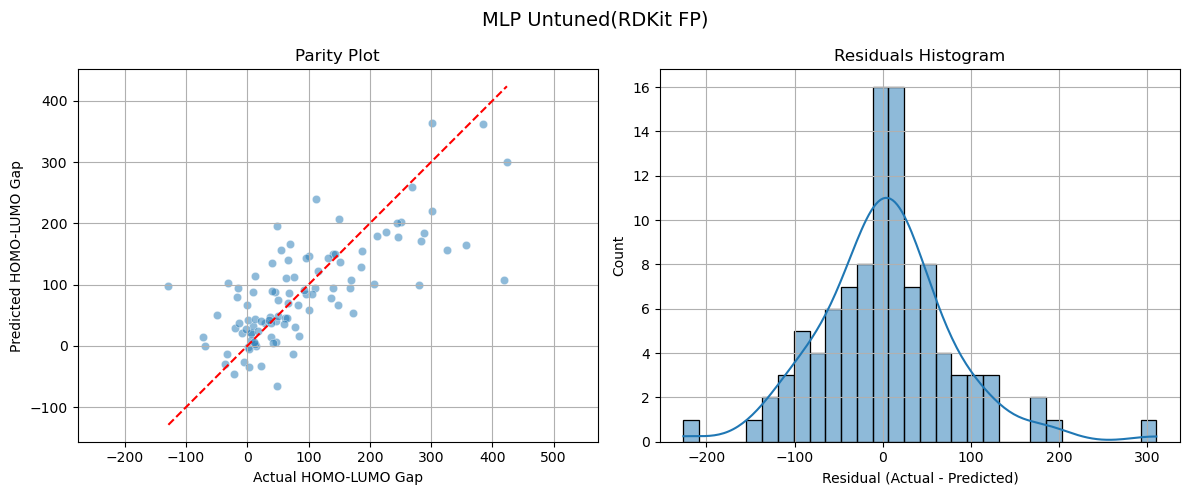

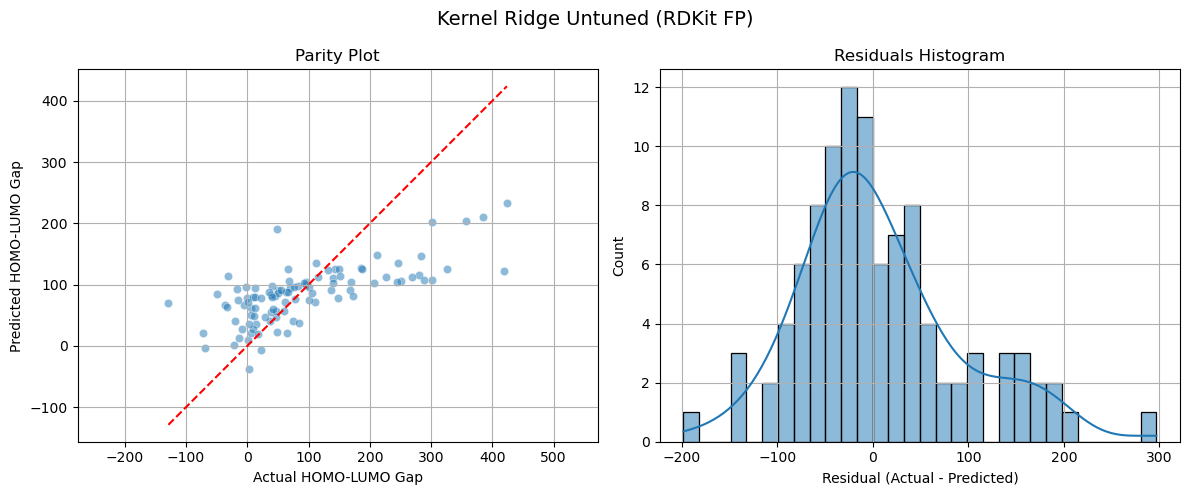

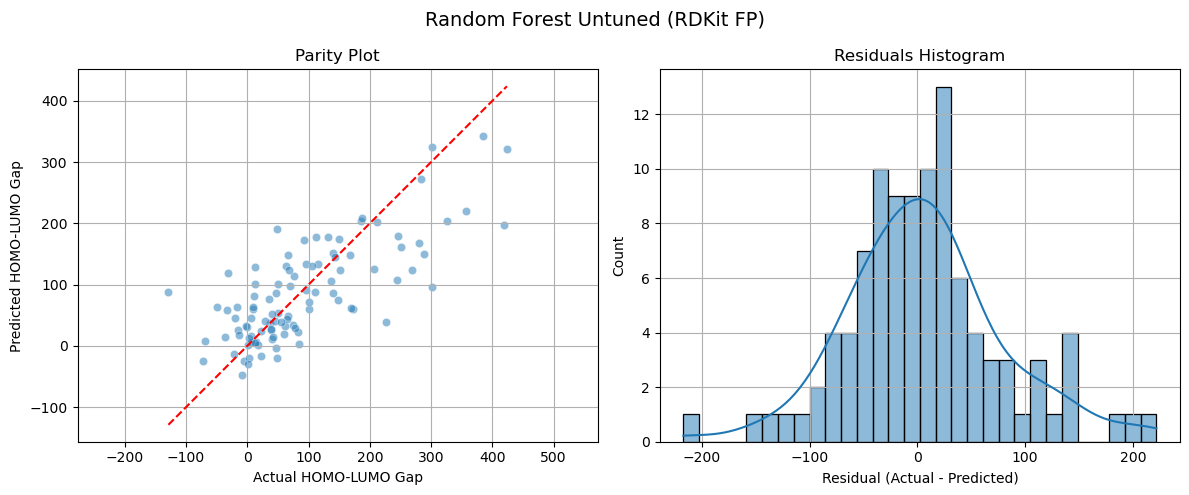

In [28]:
def plot_regression_results(y_true, y_pred, title="Model Evaluation", save_dir="plots"):
    residuals = y_true.flatten() - y_pred.flatten()
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # parity plot
    sns.scatterplot(ax=axes[0], x=y_true.flatten(), y=y_pred.flatten(), alpha=0.5)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], '--r')
    axes[0].set_xlabel("Actual HOMO-LUMO Gap")
    axes[0].set_ylabel("Predicted HOMO-LUMO Gap")
    axes[0].set_title("Parity Plot")
    axes[0].grid(True)
    axes[0].axis('equal')

    # residuals histogram
    sns.histplot(ax=axes[1], data=residuals, bins=30, kde=True)
    axes[1].set_title("Residuals Histogram")
    axes[1].set_xlabel("Residual (Actual - Predicted)")
    axes[1].grid(True)

    # overall title
    fig.suptitle(title, fontsize=14)

    # save fig as pdf for best overleaf upload format 
    os.makedirs(save_dir, exist_ok=True)
    filename = os.path.join(save_dir, f"{title.lower().replace(' ', '_')}_plots.pdf")
    fig.savefig(filename, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

plot_regression_results(y_test_fp, y_pred_fp, title="MLP Untuned(RDKit FP)")
# plot_regression_results(y_test_cm, y_pred_cm, title="MLP Untuned (Coulomb Matrix)")
plot_regression_results(y_test_krr, y_pred_krr, title="Kernel Ridge Untuned (RDKit FP)")
plot_regression_results(y_test_unscaled, y_pred_rfr, title="Random Forest Untuned (RDKit FP)")

## Tune hyperparameters for baseline models with Optuna 

In [29]:
def objective_krr(trial):
    alpha = trial.suggest_float('alpha', 0.01, 1.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly'])
    gamma = trial.suggest_float('gamma', 1e-5, 1.0, log=True) if kernel == 'rbf' else None
    model = KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma) if gamma else KernelRidge(alpha=alpha, kernel=kernel)
    model.fit(X_train_fp_scaled, y_train_scaled)
    preds_scaled = model.predict(X_test_fp_scaled).reshape(-1, 1)
    preds = yscaler.inverse_transform(preds_scaled)
    y_test_inv = yscaler.inverse_transform(y_test_scaled)
    metrics = regression_metrics(y_test_inv, preds)
    return metrics['MAE'][0]

study_krr = optuna.create_study(direction='minimize')
study_krr.optimize(objective_krr, n_trials=100)

[I 2025-09-04 18:07:31,274] A new study created in memory with name: no-name-2c5544dd-a13f-4e25-84e0-408d9fef1e39
[I 2025-09-04 18:07:31,289] Trial 0 finished with value: 52.47805602991537 and parameters: {'alpha': 0.06586033910839106, 'kernel': 'poly'}. Best is trial 0 with value: 52.47805602991537.
[I 2025-09-04 18:07:31,303] Trial 1 finished with value: 55.412910810865775 and parameters: {'alpha': 0.01189927541556288, 'kernel': 'rbf', 'gamma': 0.0001648963316314988}. Best is trial 0 with value: 52.47805602991537.
[I 2025-09-04 18:07:31,316] Trial 2 finished with value: 52.14000842310857 and parameters: {'alpha': 0.26346624549357756, 'kernel': 'poly'}. Best is trial 2 with value: 52.14000842310857.
[I 2025-09-04 18:07:31,328] Trial 3 finished with value: 52.09947380024483 and parameters: {'alpha': 0.7923779405719946, 'kernel': 'poly'}. Best is trial 3 with value: 52.09947380024483.
[I 2025-09-04 18:07:31,340] Trial 4 finished with value: 52.32335741706265 and parameters: {'alpha': 0.

In [30]:
def objective_rfr(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300, step=50)
    max_depth = trial.suggest_int("max_depth", 10, 100, step=10)
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)
    model.fit(X_train_fp_unscaled, y_train_unscaled)
    preds = model.predict(X_test_fp_unscaled)
    metrics = regression_metrics(y_test_unscaled, preds)
    return metrics['MAE'][0]

study_rfr = optuna.create_study(direction='minimize')
study_rfr.optimize(objective_rfr, n_trials=100)

[I 2025-09-04 18:07:36,340] A new study created in memory with name: no-name-571e3f03-3bb2-49d7-9e5b-88944aa83273
[I 2025-09-04 18:07:36,695] Trial 0 finished with value: 54.611500266146024 and parameters: {'n_estimators': 100, 'max_depth': 60}. Best is trial 0 with value: 54.611500266146024.
[I 2025-09-04 18:07:37,127] Trial 1 finished with value: 53.24178721398811 and parameters: {'n_estimators': 200, 'max_depth': 10}. Best is trial 1 with value: 53.24178721398811.
[I 2025-09-04 18:07:37,730] Trial 2 finished with value: 52.84979616026849 and parameters: {'n_estimators': 300, 'max_depth': 10}. Best is trial 2 with value: 52.84979616026849.
[I 2025-09-04 18:07:38,343] Trial 3 finished with value: 54.05674128710554 and parameters: {'n_estimators': 200, 'max_depth': 40}. Best is trial 2 with value: 52.84979616026849.
[I 2025-09-04 18:07:38,560] Trial 4 finished with value: 54.704354298388026 and parameters: {'n_estimators': 50, 'max_depth': 80}. Best is trial 2 with value: 52.8497961602

In [32]:
def objective_mlp_fp(trial):
    lr = trial.suggest_float('lr', 1e-4, 2e-2, log=True)
    alpha = trial.suggest_float('alpha', 1e-4, 5e-2, log=True)
    act = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid', 'gelu'])
    n1 = trial.suggest_int('n1', 128, 384, step=64)
    n2 = trial.suggest_int('n2', 128, 384, step=64)

    model = MLP(engine='tensorflow', nfeatures=X_train_fp_scaled.shape[1], nneurons=[n1, n2],
                activations=[act, act], learning_rate=lr, alpha=alpha,
                nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)
    
    model.fit(X_train_fp_scaled, y_train_scaled)
    preds_scaled = model.predict(X_test_fp_scaled).reshape(-1, 1)
    preds = yscaler.inverse_transform(preds_scaled)
    y_test_inv = yscaler.inverse_transform(y_test_scaled)
    metrics = regression_metrics(y_test_inv, preds)
    return metrics['MAE'][0]

study_mlp_fp = optuna.create_study(direction='minimize')
study_mlp_fp.optimize(objective_mlp_fp, n_trials=100)

[I 2025-09-04 20:07:24,914] A new study created in memory with name: no-name-4ab51d06-e6c2-4787-94b5-1e523db9ae9a


Epoch 1/100
7/7 [==============================] - 0s 3ms/step - loss: 13.0463
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 12.5493
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 12.0623
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 11.7880
Epoch 5/100
7/7 [==============================] - 0s 3ms/step - loss: 11.6493
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 11.5376
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 11.4500
Epoch 8/100
7/7 [==============================] - 0s 3ms/step - loss: 11.3826
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 11.3276
Epoch 10/100
7/7 [==============================] - 0s 3ms/step - loss: 11.2778
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 11.2318
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 11.1888
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:07:32,502] Trial 0 finished with value: 65.97623144240474 and parameters: {'lr': 0.0006131707246017513, 'alpha': 0.014757403572832895, 'activation': 'relu', 'n1': 320, 'n2': 256}. Best is trial 0 with value: 65.97623144240474.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 2.0463
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2119
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9368
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7513
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6307
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5531
Epoch 7/100
7/7 [==============================] - 0s 1ms/step - loss: 0.5196
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4819
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4692
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4585
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4498
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4446
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:07:34,264] Trial 1 finished with value: 61.46685337652091 and parameters: {'lr': 0.007037316607790657, 'alpha': 0.0009259457413312761, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 1 with value: 61.46685337652091.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 2.4335
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.8620
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.5381
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3505
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2835
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2151
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1895
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1468
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1299
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1167
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1062
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0995
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:07:36,083] Trial 2 finished with value: 59.99714808365374 and parameters: {'lr': 0.007103555042896184, 'alpha': 0.001803930832367276, 'activation': 'gelu', 'n1': 256, 'n2': 192}. Best is trial 2 with value: 59.99714808365374.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 2.1853
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1944
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0524
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9098
Epoch 5/100
7/7 [==============================] - 0s 1ms/step - loss: 0.8578
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8153
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7964
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7762
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 0.7648
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7566
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7523
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7489
Epoch 13/100
7/7 [==============================] - 0s 1ms/st

[I 2025-09-04 20:07:37,651] Trial 3 finished with value: 59.55488712192801 and parameters: {'lr': 0.004657392505497789, 'alpha': 0.0021561184888452835, 'activation': 'relu', 'n1': 128, 'n2': 128}. Best is trial 3 with value: 59.55488712192801.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.8280
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1476
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9408
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8615
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8108
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7829
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7879
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7556
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7404
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7325
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7278
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7225
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:07:39,472] Trial 4 finished with value: 59.83959769023511 and parameters: {'lr': 0.005391205538210505, 'alpha': 0.001257192903748666, 'activation': 'gelu', 'n1': 192, 'n2': 384}. Best is trial 3 with value: 59.55488712192801.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3738
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3670
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3664
Epoch 4/100
7/7 [==============================] - 0s 1ms/step - loss: 1.3614
Epoch 5/100
7/7 [==============================] - 0s 1ms/step - loss: 1.3317
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3240
Epoch 7/100
7/7 [==============================] - 0s 1ms/step - loss: 1.3112
Epoch 8/100
7/7 [==============================] - 0s 1ms/step - loss: 1.3013
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2926
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2734
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2624
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 1.2540
Epoch 13/100
7/7 [==============================] - 0s 1ms/st

[I 2025-09-04 20:07:41,049] Trial 5 finished with value: 57.95134360880324 and parameters: {'lr': 0.0010252295697744435, 'alpha': 0.000894687368799269, 'activation': 'sigmoid', 'n1': 128, 'n2': 256}. Best is trial 5 with value: 57.95134360880324.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 17.7150
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 17.6512
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 17.5593
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 17.4668
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 17.3681
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 17.2775
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 17.1930
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 17.1197
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 17.0473
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 16.9818
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 16.9202
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 16.8640
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:07:42,714] Trial 6 finished with value: 72.7612765917017 and parameters: {'lr': 0.00011936108934714092, 'alpha': 0.04139892684630957, 'activation': 'relu', 'n1': 128, 'n2': 256}. Best is trial 5 with value: 57.95134360880324.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 21.2594
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 20.9850
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 20.7148
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 20.5996
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 20.4031
Epoch 6/100
7/7 [==============================] - 0s 1ms/step - loss: 20.2582
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 20.0912
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 19.9319
Epoch 9/100
7/7 [==============================] - 0s 3ms/step - loss: 19.7817
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 19.6202
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 19.4729
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 19.3153
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:07:44,394] Trial 7 finished with value: 57.49475406130353 and parameters: {'lr': 0.0007068994556534392, 'alpha': 0.03869731508263629, 'activation': 'sigmoid', 'n1': 192, 'n2': 192}. Best is trial 7 with value: 57.49475406130353.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 4.2655
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 4.1104
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 3.9899
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 3.8382
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 3.7176
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 3.6132
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 3.5277
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 3.4574
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 3.4002
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 3.3516
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 3.3067
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 3.2706
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:07:45,990] Trial 8 finished with value: 78.30218485723917 and parameters: {'lr': 0.00012402581332656212, 'alpha': 0.003015430821816265, 'activation': 'relu', 'n1': 384, 'n2': 384}. Best is trial 7 with value: 57.49475406130353.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 9.2297
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 9.0752
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 8.8669
Epoch 4/100
7/7 [==============================] - 0s 1ms/step - loss: 8.6755
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 8.5013
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 8.3621
Epoch 7/100
7/7 [==============================] - 0s 1ms/step - loss: 8.2509
Epoch 8/100
7/7 [==============================] - 0s 1ms/step - loss: 8.1622
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 8.0873
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 8.0249
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 7.9719
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 7.9249
Epoch 13/100
7/7 [==============================] - 0s 1ms/st

[I 2025-09-04 20:07:47,652] Trial 9 finished with value: 83.68321030912738 and parameters: {'lr': 0.00014305628101450837, 'alpha': 0.013006000625615206, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 7 with value: 57.49475406130353.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1573
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1453
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1421
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1357
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1233
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1150
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1061
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1006
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0935
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0831
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0795
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0682
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:07:49,264] Trial 10 finished with value: 57.97517346034134 and parameters: {'lr': 0.00036853845956751074, 'alpha': 0.00015476639458539238, 'activation': 'sigmoid', 'n1': 320, 'n2': 320}. Best is trial 7 with value: 57.49475406130353.


Epoch 1/100
7/7 [==============================] - 0s 1ms/step - loss: 1.3986
Epoch 2/100
7/7 [==============================] - 0s 1ms/step - loss: 1.2354
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1900
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1557
Epoch 5/100
7/7 [==============================] - 0s 1ms/step - loss: 1.0989
Epoch 6/100
7/7 [==============================] - 0s 1ms/step - loss: 1.0824
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0562
Epoch 8/100
7/7 [==============================] - 0s 1ms/step - loss: 1.0351
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 1.0155
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9839
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9570
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 0.9367
Epoch 13/100
7/7 [==============================] - 0s 1ms/st

[I 2025-09-04 20:07:50,859] Trial 11 finished with value: 57.14954265060914 and parameters: {'lr': 0.001519422226672702, 'alpha': 0.00034349596510678093, 'activation': 'sigmoid', 'n1': 192, 'n2': 192}. Best is trial 11 with value: 57.14954265060914.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3800
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6918
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5007
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3052
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2524
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.1969
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 0.1562
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.1365
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.1178
Epoch 10/100
7/7 [==============================] - 0s 1ms/step - loss: 0.1070
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0975
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0906
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:07:52,487] Trial 12 finished with value: 70.68801466047385 and parameters: {'lr': 0.0016197931101672725, 'alpha': 0.00012750602782036794, 'activation': 'tanh', 'n1': 192, 'n2': 192}. Best is trial 11 with value: 57.14954265060914.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1879
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1610
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1446
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1327
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0977
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 1.0490
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 1.0140
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9793
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 0.9600
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9283
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8867
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8583
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:07:54,123] Trial 13 finished with value: 61.0425012665679 and parameters: {'lr': 0.002137765007936263, 'alpha': 0.00028448720470978487, 'activation': 'sigmoid', 'n1': 192, 'n2': 192}. Best is trial 11 with value: 57.14954265060914.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 5.1571
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 4.7166
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 4.2476
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 3.9758
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 3.7779
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 3.5826
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 3.4175
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 3.2727
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 3.1898
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 3.0606
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9383
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 2.8365
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:07:55,778] Trial 14 finished with value: 63.52409774657985 and parameters: {'lr': 0.019547295308692616, 'alpha': 0.00597785411675189, 'activation': 'sigmoid', 'n1': 256, 'n2': 192}. Best is trial 11 with value: 57.14954265060914.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.8739
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.4172
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3025
Epoch 4/100
7/7 [==============================] - 0s 1ms/step - loss: 1.2784
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2100
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1982
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1830
Epoch 8/100
7/7 [==============================] - 0s 1ms/step - loss: 1.1791
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1679
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1612
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1567
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 1.1495
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:07:57,330] Trial 15 finished with value: 58.562715955041384 and parameters: {'lr': 0.00035676340184542766, 'alpha': 0.0003903578866662198, 'activation': 'sigmoid', 'n1': 192, 'n2': 320}. Best is trial 11 with value: 57.14954265060914.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 37.3357
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 35.7575
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 34.4924
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 33.3279
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 32.0825
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 30.9001
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 29.7407
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 28.6266
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 27.5528
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 26.5195
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 25.5254
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 24.5685
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:07:58,960] Trial 16 finished with value: 65.87201327033065 and parameters: {'lr': 0.002699479695264986, 'alpha': 0.04927873066015183, 'activation': 'tanh', 'n1': 320, 'n2': 192}. Best is trial 11 with value: 57.14954265060914.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2194
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2184
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2144
Epoch 4/100
7/7 [==============================] - 0s 1ms/step - loss: 1.2083
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1662
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1577
Epoch 7/100
7/7 [==============================] - 0s 1ms/step - loss: 1.1518
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1463
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 1.1381
Epoch 10/100
7/7 [==============================] - 0s 1ms/step - loss: 1.1191
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 1.1112
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1075
Epoch 13/100
7/7 [==============================] - 0s 1ms/st

[I 2025-09-04 20:08:00,497] Trial 17 finished with value: 54.887397256505984 and parameters: {'lr': 0.0008268674952260534, 'alpha': 0.0004886784355305433, 'activation': 'sigmoid', 'n1': 128, 'n2': 320}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3388
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2017
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2134
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1775
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1779
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1659
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1627
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1599
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1569
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1519
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1499
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 1.1447
Epoch 13/100
7/7 [==============================] - 0s 1ms/st

[I 2025-09-04 20:08:02,146] Trial 18 finished with value: 67.32759250313498 and parameters: {'lr': 0.0003127506277317366, 'alpha': 0.0004365005994739172, 'activation': 'sigmoid', 'n1': 128, 'n2': 320}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2263
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2193
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2167
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 1.2134
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1880
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1817
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1694
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1597
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1534
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1338
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1243
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1167
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:03,805] Trial 19 finished with value: 57.10359805375634 and parameters: {'lr': 0.0008688529977470843, 'alpha': 0.000620431612666866, 'activation': 'sigmoid', 'n1': 128, 'n2': 256}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 1s 2ms/step - loss: 1.7689
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1850
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8495
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7121
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6139
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5447
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4978
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4623
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4338
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4118
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3914
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3746
Epoch 13/100
7/7 [==============================] - 0s 3ms/st

[I 2025-09-04 20:08:06,036] Trial 20 finished with value: 73.66704382072314 and parameters: {'lr': 0.0008042694329300243, 'alpha': 0.0005797064995685693, 'activation': 'tanh', 'n1': 128, 'n2': 320}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1884
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1026
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0988
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0897
Epoch 5/100
7/7 [==============================] - 0s 1ms/step - loss: 1.0430
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0291
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0180
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0056
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9991
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9743
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 0.9463
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 0.9314
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:07,773] Trial 21 finished with value: 58.82215589005639 and parameters: {'lr': 0.001293822559519647, 'alpha': 0.00024436757942165546, 'activation': 'sigmoid', 'n1': 128, 'n2': 256}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3108
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3166
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2347
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2158
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2174
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1865
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1839
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0888
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0550
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0148
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9777
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9462
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:09,500] Trial 22 finished with value: 64.36580875396851 and parameters: {'lr': 0.0027744557006031084, 'alpha': 0.0005827368166316126, 'activation': 'sigmoid', 'n1': 128, 'n2': 320}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1227
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1163
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1142
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1092
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0922
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0885
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0737
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0690
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0630
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0481
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0467
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0334
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:11,192] Trial 23 finished with value: 57.49350968555152 and parameters: {'lr': 0.0005666118553888679, 'alpha': 0.0001988065057044844, 'activation': 'sigmoid', 'n1': 192, 'n2': 256}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3773
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3157
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3248
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3085
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3075
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3054
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3003
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2988
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2953
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2923
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 1.2891
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2846
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:12,843] Trial 24 finished with value: 74.36739544316448 and parameters: {'lr': 0.00025402258047026735, 'alpha': 0.0007753327889135206, 'activation': 'sigmoid', 'n1': 128, 'n2': 256}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2495
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2632
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1705
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1598
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1449
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1124
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0825
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0557
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0465
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0257
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9973
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9867
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:14,554] Trial 25 finished with value: 56.17399134753914 and parameters: {'lr': 0.0014832161187332013, 'alpha': 0.0003380614603970123, 'activation': 'sigmoid', 'n1': 192, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0639
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0594
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0600
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0590
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0424
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 1.0436
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0326
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0283
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0291
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0154
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 1.0145
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 1.0106
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:16,155] Trial 26 finished with value: 59.40491410688315 and parameters: {'lr': 0.0005225852011665604, 'alpha': 0.00010234367597197874, 'activation': 'sigmoid', 'n1': 128, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 1ms/step - loss: 3.1172
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 2.8391
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 2.8782
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 2.8105
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 2.8106
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 2.7910
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 2.7895
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 2.7833
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 2.7771
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 2.7728
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 2.7697
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 2.7649
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:17,827] Trial 27 finished with value: 71.64389253822792 and parameters: {'lr': 0.00021514221254018622, 'alpha': 0.0031128939043399, 'activation': 'sigmoid', 'n1': 192, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.4629
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9092
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6181
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4800
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3813
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3246
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2872
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2563
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2338
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2171
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2028
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.1915
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:19,511] Trial 28 finished with value: 75.46315048873812 and parameters: {'lr': 0.0009504018362641837, 'alpha': 0.00018772816978607088, 'activation': 'tanh', 'n1': 256, 'n2': 320}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 2.7843
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 2.4013
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 2.0503
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.8431
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.7014
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.6210
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.5649
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.5178
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.4877
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.4598
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 1.4382
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 1.4192
Epoch 13/100
7/7 [==============================] - 0s 1ms/st

[I 2025-09-04 20:08:21,285] Trial 29 finished with value: 75.71937928748969 and parameters: {'lr': 0.0005303842432961027, 'alpha': 0.0013844633386373548, 'activation': 'gelu', 'n1': 384, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3925
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3866
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3192
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2998
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3019
Epoch 6/100
7/7 [==============================] - 0s 1ms/step - loss: 1.2609
Epoch 7/100
7/7 [==============================] - 0s 1ms/step - loss: 1.2246
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1668
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1574
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1118
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 1.1015
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0686
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:22,790] Trial 30 finished with value: 58.70081934525798 and parameters: {'lr': 0.0023123022936027016, 'alpha': 0.000586292422524495, 'activation': 'sigmoid', 'n1': 128, 'n2': 320}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.4406
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2482
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2420
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2164
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1433
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1048
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0885
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0609
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0454
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0189
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9778
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9526
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:24,422] Trial 31 finished with value: 56.794680817555815 and parameters: {'lr': 0.0014571610387418346, 'alpha': 0.0003171968403787017, 'activation': 'sigmoid', 'n1': 256, 'n2': 256}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2442
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1869
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1735
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1582
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1157
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1004
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0806
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0644
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0472
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0173
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9942
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9784
Epoch 13/100
7/7 [==============================] - 0s 1ms/st

[I 2025-09-04 20:08:25,988] Trial 32 finished with value: 58.5561709359424 and parameters: {'lr': 0.001095587620589835, 'alpha': 0.00026712732781587935, 'activation': 'sigmoid', 'n1': 256, 'n2': 256}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.5063
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3945
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3300
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 1.2198
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1490
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0795
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0829
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9526
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8738
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8330
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7997
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7218
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:27,679] Trial 33 finished with value: 62.33236491380777 and parameters: {'lr': 0.0034300013336170374, 'alpha': 0.0004402987574185776, 'activation': 'sigmoid', 'n1': 256, 'n2': 256}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 2.4266
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.6878
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.4347
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3238
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2447
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1838
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1467
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1168
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1036
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0935
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0868
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0811
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:29,496] Trial 34 finished with value: 65.05443481641218 and parameters: {'lr': 0.001715196401300293, 'alpha': 0.0013219123216076413, 'activation': 'gelu', 'n1': 320, 'n2': 320}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.5447
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.6048
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.5959
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.4039
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3133
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2508
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2523
Epoch 8/100
7/7 [==============================] - 0s 1ms/step - loss: 1.1808
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1575
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0340
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9694
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8834
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:31,102] Trial 35 finished with value: 64.18843170252426 and parameters: {'lr': 0.003637777667057363, 'alpha': 0.0007445754898470012, 'activation': 'sigmoid', 'n1': 192, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 2.6763
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.8767
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3659
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2203
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1269
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0628
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0219
Epoch 8/100
7/7 [==============================] - 0s 3ms/step - loss: 0.9953
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9736
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9600
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9483
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9394
Epoch 13/100
7/7 [==============================] - 0s 3ms/st

[I 2025-09-04 20:08:32,954] Trial 36 finished with value: 76.06853375116097 and parameters: {'lr': 0.000781099390239808, 'alpha': 0.0011604181674921877, 'activation': 'gelu', 'n1': 320, 'n2': 256}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.7803
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.4847
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2502
Epoch 4/100
7/7 [==============================] - 0s 1ms/step - loss: 1.1572
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1039
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0207
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0013
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9800
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9742
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9433
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9062
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8878
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:34,555] Trial 37 finished with value: 58.24711478208619 and parameters: {'lr': 0.0012659580917846744, 'alpha': 0.00019105348920217408, 'activation': 'sigmoid', 'n1': 128, 'n2': 256}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.5300
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5876
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3921
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3307
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3053
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2785
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2508
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2260
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2198
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2131
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2071
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2065
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:36,234] Trial 38 finished with value: 59.783804825071115 and parameters: {'lr': 0.008061907712918122, 'alpha': 0.0003608613311849593, 'activation': 'relu', 'n1': 192, 'n2': 320}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9989
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9940
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9925
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9871
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9691
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9663
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9510
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9440
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9417
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9242
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9209
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9131
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:37,843] Trial 39 finished with value: 55.55557160710136 and parameters: {'lr': 0.0004500254115521539, 'alpha': 0.0027582362290749732, 'activation': 'sigmoid', 'n1': 256, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 5.1542
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 4.6544
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 4.1112
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 3.8658
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 3.7405
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 3.6371
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 3.5616
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 3.5115
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 3.4783
Epoch 10/100
7/7 [==============================] - 0s 1ms/step - loss: 3.4426
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 3.4151
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 3.3944
Epoch 13/100
7/7 [==============================] - 0s 1ms/st

[I 2025-09-04 20:08:39,458] Trial 40 finished with value: 78.5477734197659 and parameters: {'lr': 0.000442128886129882, 'alpha': 0.004572804169783657, 'activation': 'relu', 'n1': 256, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 2.5943
Epoch 2/100
7/7 [==============================] - 0s 1ms/step - loss: 2.5951
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 2.5846
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 2.5808
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 2.5555
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 2.5252
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 2.5149
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 2.4990
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 2.4951
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 2.4708
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 2.4431
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 2.4281
Epoch 13/100
7/7 [==============================] - 0s 1ms/st

[I 2025-09-04 20:08:41,003] Trial 41 finished with value: 57.85965679787283 and parameters: {'lr': 0.000924801486507968, 'alpha': 0.0022087628583511336, 'activation': 'sigmoid', 'n1': 256, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 6.9288
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 6.9218
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 6.8928
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 6.8753
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 6.8195
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 6.7913
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 6.7761
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 6.7600
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 6.7419
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 6.7101
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 6.6857
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 6.6706
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:42,655] Trial 42 finished with value: 56.009657313499055 and parameters: {'lr': 0.000698821200582735, 'alpha': 0.008196610165303004, 'activation': 'sigmoid', 'n1': 256, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 8.6672
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 8.6602
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 8.6441
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 8.6243
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 8.5610
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 8.5345
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 8.5095
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 8.4853
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 8.4594
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 8.4258
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 8.4014
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 8.3815
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:44,296] Trial 43 finished with value: 55.42133869615102 and parameters: {'lr': 0.0006530219627934531, 'alpha': 0.010667358653405856, 'activation': 'sigmoid', 'n1': 256, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8646
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8464
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8431
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8321
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8243
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8161
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8065
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7989
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7902
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7808
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7726
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7624
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:45,876] Trial 44 finished with value: 74.18297710794084 and parameters: {'lr': 0.0001801887393834703, 'alpha': 0.012333680001063628, 'activation': 'sigmoid', 'n1': 256, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 1ms/step - loss: 19.9119
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 19.8497
Epoch 3/100
7/7 [==============================] - 0s 1ms/step - loss: 19.7820
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 19.7075
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 19.6122
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 19.5295
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 19.4401
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 19.3555
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 19.2736
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 19.1790
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 19.0918
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 19.0112
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:08:47,462] Trial 45 finished with value: 54.434319211628384 and parameters: {'lr': 0.000648662551024776, 'alpha': 0.02260346133324402, 'activation': 'sigmoid', 'n1': 320, 'n2': 384}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 22.3387
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 21.8465
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 21.4531
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 21.2060
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 21.0383
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 20.8949
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 20.7618
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 20.6426
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 20.5361
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 20.4308
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 20.3320
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 20.2363
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:08:49,265] Trial 46 finished with value: 69.39861457218095 and parameters: {'lr': 0.0006674482071770976, 'alpha': 0.022344366281202434, 'activation': 'gelu', 'n1': 384, 'n2': 384}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 8.7258
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 8.4953
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 8.1855
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 8.1632
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 8.1495
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 8.1068
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 8.0929
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 8.0763
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 8.0583
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 8.0388
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 8.0265
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 8.0091
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:50,839] Trial 47 finished with value: 57.86262325052492 and parameters: {'lr': 0.00042339336152147746, 'alpha': 0.008543526188068818, 'activation': 'sigmoid', 'n1': 320, 'n2': 384}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 23.6998
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 23.4304
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 23.1473
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 22.9178
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 22.7111
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 22.5653
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 22.4352
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 22.3336
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 22.2422
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 22.1612
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 22.0852
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 22.0151
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:08:52,462] Trial 48 finished with value: 76.45138356723437 and parameters: {'lr': 0.0002693783264055018, 'alpha': 0.02658771263919912, 'activation': 'relu', 'n1': 320, 'n2': 384}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 16.7953
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 16.3826
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 16.0338
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 15.8243
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 15.6738
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 15.5535
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 15.4559
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 15.3734
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 15.3054
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 15.2410
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 15.1819
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 15.1270
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:08:54,029] Trial 49 finished with value: 79.13577456217612 and parameters: {'lr': 0.0004616504188371658, 'alpha': 0.018294769482185606, 'activation': 'tanh', 'n1': 320, 'n2': 384}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 9.9157
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8939
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8720
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8502
Epoch 5/100
7/7 [==============================] - 0s 1ms/step - loss: 9.8136
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7884
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7569
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7299
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7066
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 9.6699
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 9.6453
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 9.6214
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:55,671] Trial 50 finished with value: 56.475750969483066 and parameters: {'lr': 0.0006453727281820407, 'alpha': 0.009790137385693147, 'activation': 'sigmoid', 'n1': 384, 'n2': 320}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 5.4690
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 5.3381
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 5.0930
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 5.0201
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 5.0244
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 4.9868
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 4.9400
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 4.9155
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 4.8965
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 4.8730
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 4.8403
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 4.8211
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:57,236] Trial 51 finished with value: 55.88046729443471 and parameters: {'lr': 0.0010990602884344404, 'alpha': 0.005651126370097854, 'activation': 'sigmoid', 'n1': 256, 'n2': 384}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 5.5178
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 5.4785
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 5.4338
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 5.3938
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 5.3172
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 5.2957
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 5.2816
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 5.2678
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 5.2496
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 5.2254
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 5.2100
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 5.2015
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:58,918] Trial 52 finished with value: 57.723269285538926 and parameters: {'lr': 0.0006604875383176219, 'alpha': 0.006040681144711947, 'activation': 'sigmoid', 'n1': 256, 'n2': 384}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 3.5580
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 3.5606
Epoch 3/100
7/7 [==============================] - 0s 1ms/step - loss: 3.5344
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 3.5249
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 3.5081
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 3.4702
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 3.4437
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 3.4204
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 3.4113
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 3.3955
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 3.3615
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 3.3462
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:09:00,509] Trial 53 finished with value: 60.72872794413582 and parameters: {'lr': 0.001117578516471097, 'alpha': 0.003561639301935277, 'activation': 'sigmoid', 'n1': 256, 'n2': 384}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 7.1988
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 6.7092
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 6.3117
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 6.3195
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 6.2243
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 6.1622
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 6.1497
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 6.1359
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 6.1169
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 6.0996
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 6.0932
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 6.0749
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:09:02,338] Trial 54 finished with value: 59.69757891514321 and parameters: {'lr': 0.0003889726320747716, 'alpha': 0.0072501034517637765, 'activation': 'sigmoid', 'n1': 256, 'n2': 384}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 5.1943
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 4.8422
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 4.6778
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 4.6902
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 4.6086
Epoch 6/100
7/7 [==============================] - 0s 1ms/step - loss: 4.6265
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 4.5958
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 4.5915
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 4.5875
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 4.5745
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 4.5717
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 4.5596
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:09:03,959] Trial 55 finished with value: 60.41195850551317 and parameters: {'lr': 0.0003051940280185812, 'alpha': 0.004336887877957567, 'activation': 'sigmoid', 'n1': 320, 'n2': 384}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 23.7395
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 23.5572
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 23.1991
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 22.8287
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 22.4537
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 22.0319
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 21.6169
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 21.2083
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 20.8271
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 20.4383
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 20.0526
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 19.6961
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:05,534] Trial 56 finished with value: 52.81048543606694 and parameters: {'lr': 0.00194612835157685, 'alpha': 0.03280636474326703, 'activation': 'sigmoid', 'n1': 256, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 25.5355
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 25.2679
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 24.7919
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 24.4116
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 23.9927
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 23.5828
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 23.1784
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 22.7700
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 22.3899
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 22.0046
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 21.6104
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 21.2492
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:07,270] Trial 57 finished with value: 55.33884713276276 and parameters: {'lr': 0.0017224473897670786, 'alpha': 0.035158247086843245, 'activation': 'sigmoid', 'n1': 256, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 26.0702
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 25.7136
Epoch 3/100
7/7 [==============================] - 0s 1ms/step - loss: 25.4195
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 25.0374
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 24.6779
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 24.2724
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 23.8658
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 23.4719
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 23.1093
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 22.7363
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 22.3624
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 22.0171
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:08,900] Trial 58 finished with value: 56.920772943434145 and parameters: {'lr': 0.001785481306795398, 'alpha': 0.03079649038272542, 'activation': 'sigmoid', 'n1': 320, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 29.5054
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 27.8108
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 26.3308
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 24.7305
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 23.1206
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 21.5899
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 20.1644
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 18.8073
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 17.5496
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 16.3704
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 15.2707
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 14.2460
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:10,469] Trial 59 finished with value: 62.95734778948861 and parameters: {'lr': 0.00578184151227972, 'alpha': 0.04098935941014275, 'activation': 'tanh', 'n1': 256, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 15.6384
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 15.5813
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 15.3928
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 15.2103
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 15.0376
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 14.8439
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 14.6762
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 14.4114
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 14.2090
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 14.0161
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 13.8349
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 13.6436
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:12,140] Trial 60 finished with value: 56.696271028300565 and parameters: {'lr': 0.002461490694915656, 'alpha': 0.016151784191946968, 'activation': 'sigmoid', 'n1': 384, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 25.2478
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 25.0172
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 24.6292
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 24.2039
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 23.7728
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 23.3084
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 22.8436
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 22.3769
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 21.9510
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 21.5081
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 21.0783
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 20.6730
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:13,780] Trial 61 finished with value: 55.08044581208695 and parameters: {'lr': 0.001958106556908009, 'alpha': 0.034984303463819054, 'activation': 'sigmoid', 'n1': 256, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 24.1616
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 23.8200
Epoch 3/100
7/7 [==============================] - 0s 1ms/step - loss: 23.3166
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 22.5923
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 21.9211
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 21.2497
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 20.6290
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 19.9602
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 19.3305
Epoch 10/100
7/7 [==============================] - 0s 1ms/step - loss: 18.7055
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 18.1374
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 17.5334
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:15,332] Trial 62 finished with value: 56.70197451274833 and parameters: {'lr': 0.0032422305194448643, 'alpha': 0.033385227441928095, 'activation': 'sigmoid', 'n1': 256, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 35.5160
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 34.3798
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 33.6214
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 32.6235
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 31.7705
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 30.9054
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 30.0474
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 29.1749
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 28.3661
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 27.5506
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 26.7811
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 26.0299
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:17,022] Trial 63 finished with value: 54.66146450273181 and parameters: {'lr': 0.0020581756490388532, 'alpha': 0.048516082802718796, 'activation': 'sigmoid', 'n1': 256, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 34.6021
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 34.1687
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 33.4120
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 32.6096
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 31.7844
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 30.9139
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 30.0611
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 29.2258
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 28.4434
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 27.6504
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 26.8943
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 26.1686
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:18,657] Trial 64 finished with value: 54.59184485389007 and parameters: {'lr': 0.0020123123607267567, 'alpha': 0.048452573091974704, 'activation': 'sigmoid', 'n1': 256, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 27.5493
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 26.5576
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 26.0548
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 25.3595
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 24.7560
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 24.1291
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 23.4954
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 22.8784
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 22.3208
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 21.7350
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 21.1715
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 20.6448
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:20,374] Trial 65 finished with value: 54.29691622536134 and parameters: {'lr': 0.001974353041603855, 'alpha': 0.045875023609623755, 'activation': 'sigmoid', 'n1': 192, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 26.6103
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 25.7891
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 25.2425
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 24.5463
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 23.9425
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 23.3232
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 22.7147
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 22.0731
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 21.4991
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 20.9076
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 20.3549
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 19.8116
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:22,067] Trial 66 finished with value: 54.65766232421647 and parameters: {'lr': 0.00214220020753589, 'alpha': 0.04442101481643664, 'activation': 'sigmoid', 'n1': 192, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 27.5023
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 26.9981
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 26.3848
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 25.7039
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 25.0389
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 24.3509
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 23.6681
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 22.9667
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 22.3211
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 21.6706
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 21.0593
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 20.4583
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:23,734] Trial 67 finished with value: 54.38580421337003 and parameters: {'lr': 0.0021726256722235855, 'alpha': 0.04672479114420974, 'activation': 'sigmoid', 'n1': 192, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 28.3087
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 27.8229
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 27.2061
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 26.5029
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 25.8105
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 25.0884
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 24.3734
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 23.6497
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 22.9900
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 22.3084
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 21.6713
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 21.0465
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:25,411] Trial 68 finished with value: 53.91736794297466 and parameters: {'lr': 0.0021248397770244963, 'alpha': 0.048452239153924805, 'activation': 'sigmoid', 'n1': 192, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 15.9031
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 14.8734
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 14.0875
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 13.6943
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 13.3314
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 13.0074
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 12.7043
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 12.4272
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 12.1568
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 11.8977
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 11.6449
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 11.4002
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:27,057] Trial 69 finished with value: 57.01057855341436 and parameters: {'lr': 0.002957590254938874, 'alpha': 0.02509315814409954, 'activation': 'relu', 'n1': 192, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 23.3545
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 21.7899
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 20.7643
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 19.7079
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 18.6886
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 17.6936
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 16.7475
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 15.8459
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 14.9941
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 14.1884
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 13.4264
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 12.7061
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:28,835] Trial 70 finished with value: 54.224988136544084 and parameters: {'lr': 0.0041223405551542875, 'alpha': 0.046427939714433056, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 25.0043
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 23.4276
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 22.1737
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 20.9376
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 19.7125
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 18.5382
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 17.4376
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 16.3893
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 15.4064
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 14.4842
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 13.6185
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 12.8052
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:30,657] Trial 71 finished with value: 54.6606564701801 and parameters: {'lr': 0.004286202090680954, 'alpha': 0.04966097050391106, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 21.2335
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 19.8185
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 18.8566
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 17.9104
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 16.9524
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 16.0168
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 15.1403
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 14.3042
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 13.5138
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 12.7733
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 12.0739
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 11.4131
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:32,452] Trial 72 finished with value: 54.31076159649843 and parameters: {'lr': 0.00463546788420104, 'alpha': 0.042097378084847925, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 11.3571
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 10.3923
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7418
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 9.1521
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 8.6424
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 8.1813
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 7.7388
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 7.3208
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 6.9304
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 6.5679
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 6.2221
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 5.8977
Epoch 13/100
7/7 [==============================] - 0s 3ms/

[I 2025-09-04 20:09:34,296] Trial 73 finished with value: 54.453783915730945 and parameters: {'lr': 0.008804173964550322, 'alpha': 0.0210942773834046, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 11.1602
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 10.3501
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8385
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 9.0344
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 8.5121
Epoch 6/100
7/7 [==============================] - 0s 1ms/step - loss: 8.0055
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 7.5523
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 7.1098
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 6.7050
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 6.3242
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 5.9643
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 5.6289
Epoch 13/100
7/7 [==============================] - 0s 2ms/

[I 2025-09-04 20:09:36,065] Trial 74 finished with value: 54.531885326614606 and parameters: {'lr': 0.009520095859857844, 'alpha': 0.021031807479581142, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 15.3046
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 13.9278
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 13.1760
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 12.5194
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 11.8814
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 11.3370
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 10.8032
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 10.2895
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8090
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 9.3519
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 8.9165
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 8.5046
Epoch 13/100
7/7 [==============================] - 0

[I 2025-09-04 20:09:37,882] Trial 75 finished with value: 53.330981826575204 and parameters: {'lr': 0.005745559099222646, 'alpha': 0.028691482524501436, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 16.0167
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 14.7525
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 14.0323
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 13.4488
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 12.7890
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 12.1962
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 11.6028
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 11.0486
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 10.5240
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 10.0268
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 9.5543
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 9.1043
Epoch 13/100
7/7 [==============================] -

[I 2025-09-04 20:09:39,708] Trial 76 finished with value: 54.142874385042184 and parameters: {'lr': 0.00542159070491758, 'alpha': 0.030944388344594388, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 14.7769
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 13.5807
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 12.8940
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 12.2812
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 11.6773
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 11.0996
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 10.5574
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 10.0287
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 9.5273
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 9.0544
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 8.6076
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 8.1826
Epoch 13/100
7/7 [==============================] - 0

[I 2025-09-04 20:09:41,473] Trial 77 finished with value: 54.22571804367231 and parameters: {'lr': 0.006210474656590668, 'alpha': 0.028307470595575146, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 15.1699
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 13.7354
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 12.8764
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 11.4395
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 10.4069
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 9.4765
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 8.5810
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 7.7839
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 7.0600
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 6.4057
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 5.8138
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 5.2756
Epoch 13/100
7/7 [==============================] - 0s 2

[I 2025-09-04 20:09:43,311] Trial 78 finished with value: 56.19758879906386 and parameters: {'lr': 0.011394619525542356, 'alpha': 0.02876680619016224, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 19.5619
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 18.1673
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 17.0264
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 15.9782
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 14.9261
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 13.9291
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 12.9906
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 12.1082
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 11.2878
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 10.5235
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8132
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 9.1507
Epoch 13/100
7/7 [==============================] -

[I 2025-09-04 20:09:45,139] Trial 79 finished with value: 54.92387933984133 and parameters: {'lr': 0.006219573309194602, 'alpha': 0.03869730855519753, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 9.5796
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 8.6544
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 8.2432
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 8.0026
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 7.7814
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 7.5707
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 7.3843
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 7.1970
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 7.0254
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 6.8595
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 6.6986
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 6.5422
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:09:46,953] Trial 80 finished with value: 55.47997905097739 and parameters: {'lr': 0.004761660891407249, 'alpha': 0.017383691919961128, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 15.4726
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 14.1791
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 13.6582
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 13.2170
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 12.7532
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 12.3150
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 11.9053
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 11.5091
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 11.1267
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 10.7606
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 10.4082
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 10.0673
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:48,734] Trial 81 finished with value: 55.27014748184249 and parameters: {'lr': 0.003966510983459755, 'alpha': 0.029436816394541963, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 20.0846
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 18.4511
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 17.4634
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 16.5710
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 15.6677
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 14.8086
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 13.9886
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 13.2101
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 12.4768
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 11.7873
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 11.1367
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 10.5225
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:50,522] Trial 82 finished with value: 54.747110517986215 and parameters: {'lr': 0.005044296075894868, 'alpha': 0.03898893704105874, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 14.1712
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 13.1082
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 12.4294
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 11.8799
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 11.3212
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 10.7576
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 10.2468
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7421
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 9.2772
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 8.8353
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 8.4160
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 8.0178
Epoch 13/100
7/7 [==============================] - 0s

[I 2025-09-04 20:09:52,644] Trial 83 finished with value: 54.60401935582229 and parameters: {'lr': 0.006680939529286577, 'alpha': 0.025221417860610478, 'activation': 'gelu', 'n1': 192, 'n2': 192}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 18.2609
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 16.9057
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 15.6846
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 14.5373
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 13.4546
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 12.4352
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 11.5014
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 10.6267
Epoch 9/100
7/7 [==============================] - 0s 3ms/step - loss: 9.8254
Epoch 10/100
7/7 [==============================] - 0s 3ms/step - loss: 9.0821
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 8.3972
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 7.7652
Epoch 13/100
7/7 [==============================] - 0

[I 2025-09-04 20:09:54,447] Trial 84 finished with value: 55.2301306889337 and parameters: {'lr': 0.007559863856886031, 'alpha': 0.035507594224455964, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 22.1100
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 20.1282
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 17.9910
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 15.5752
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 13.4630
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 11.6171
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 10.0027
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 8.5823
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 7.3675
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 6.3295
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 5.4319
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 4.6669
Epoch 13/100
7/7 [==============================] - 0s

[I 2025-09-04 20:09:56,307] Trial 85 finished with value: 54.38135509720895 and parameters: {'lr': 0.011372490571262574, 'alpha': 0.043753669347685945, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 16.3589
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 15.0197
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 13.6719
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 12.0422
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 10.6142
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 9.3706
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 8.2413
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 7.2324
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 6.3587
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 5.5845
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 4.9082
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 4.3142
Epoch 13/100
7/7 [==============================] - 0s 2

[I 2025-09-04 20:09:58,113] Trial 86 finished with value: 55.949863005042836 and parameters: {'lr': 0.013245679779290231, 'alpha': 0.032390335022136216, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 19.5125
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 17.4318
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 15.3427
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 13.2672
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 11.4022
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7736
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 8.3242
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 7.0855
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 6.0264
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 5.1226
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 4.3576
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 3.7072
Epoch 13/100
7/7 [==============================] - 0s 2

[I 2025-09-04 20:09:59,979] Trial 87 finished with value: 57.13412939449313 and parameters: {'lr': 0.013753092965148251, 'alpha': 0.038327108731713286, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 14.5395
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 13.3995
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 12.7529
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 12.2619
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 11.7653
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 11.2932
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 10.8385
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 10.4261
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 10.0254
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 9.6424
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 9.2763
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 8.9265
Epoch 13/100
7/7 [==============================] - 

[I 2025-09-04 20:10:01,777] Trial 88 finished with value: 54.13674064855176 and parameters: {'lr': 0.005266479996662898, 'alpha': 0.02548226942571884, 'activation': 'gelu', 'n1': 192, 'n2': 192}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 6.1876
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 5.3958
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 5.1493
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 5.0015
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 4.8501
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 4.7229
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 4.6050
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 4.4999
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 4.3984
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 4.3023
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 4.2086
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 4.1187
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:10:03,621] Trial 89 finished with value: 51.87719012805435 and parameters: {'lr': 0.005659908689217048, 'alpha': 0.013367428810420565, 'activation': 'gelu', 'n1': 128, 'n2': 192}. Best is trial 89 with value: 51.87719012805435.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 7.0343
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 6.0685
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 5.7975
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 5.5824
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 5.4653
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 5.3267
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 5.2184
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 5.1173
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 5.0260
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 4.9389
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 4.8531
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 4.7715
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:10:05,502] Trial 90 finished with value: 58.129531107344214 and parameters: {'lr': 0.003931747065517547, 'alpha': 0.014788267825545398, 'activation': 'gelu', 'n1': 128, 'n2': 192}. Best is trial 89 with value: 51.87719012805435.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 8.6282
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 7.7252
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 7.3552
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 7.1177
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 6.8124
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 6.5910
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 6.3921
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 6.1991
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 6.0099
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 5.8331
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 5.6654
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 5.5047
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:10:07,384] Trial 91 finished with value: 56.448921305401946 and parameters: {'lr': 0.005212677116400229, 'alpha': 0.019241661342297642, 'activation': 'gelu', 'n1': 128, 'n2': 192}. Best is trial 89 with value: 51.87719012805435.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 15.6721
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 14.1908
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 13.4788
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 12.8803
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 12.2981
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 11.7365
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 11.1883
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 10.6943
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 10.2248
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7745
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 9.3465
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 8.9400
Epoch 13/100
7/7 [==============================] - 

[I 2025-09-04 20:10:09,177] Trial 92 finished with value: 53.66051793603558 and parameters: {'lr': 0.005706785231232192, 'alpha': 0.02717730570168838, 'activation': 'gelu', 'n1': 192, 'n2': 192}. Best is trial 89 with value: 51.87719012805435.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 14.4230
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 13.2813
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 12.6719
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 12.1149
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 11.5863
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 11.0802
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 10.5963
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 10.1262
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 9.6824
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 9.2603
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 8.8572
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 8.4732
Epoch 13/100
7/7 [==============================] - 0

[I 2025-09-04 20:10:11,006] Trial 93 finished with value: 55.13825186992917 and parameters: {'lr': 0.006023648939669022, 'alpha': 0.025608930381952826, 'activation': 'gelu', 'n1': 192, 'n2': 192}. Best is trial 89 with value: 51.87719012805435.


Epoch 1/100
7/7 [==============================] - 0s 1ms/step - loss: 8.2661
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 7.4897
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 7.1263
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 6.9051
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 6.7195
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 6.5040
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 6.3225
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 6.1144
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 5.9333
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 5.7622
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 5.5967
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 5.4283
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:10:12,831] Trial 94 finished with value: 55.18334923023347 and parameters: {'lr': 0.007249996136264344, 'alpha': 0.014062824067704701, 'activation': 'gelu', 'n1': 192, 'n2': 192}. Best is trial 89 with value: 51.87719012805435.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 12.0250
Epoch 2/100
7/7 [==============================] - 0s 1ms/step - loss: 11.3852
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 10.9268
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 10.5371
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 10.2529
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 9.9803
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7584
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 9.5522
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 9.3441
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 9.1443
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 8.9548
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 8.7715
Epoch 13/100
7/7 [==============================] - 0s 2

[I 2025-09-04 20:10:14,712] Trial 95 finished with value: 54.400481701617174 and parameters: {'lr': 0.0025573425263952228, 'alpha': 0.028210335093461072, 'activation': 'gelu', 'n1': 128, 'n2': 192}. Best is trial 89 with value: 51.87719012805435.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 13.7481
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 12.6631
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 12.2909
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 11.9439
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 11.6741
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 11.3850
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 11.1206
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 10.8751
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 10.6384
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 10.4115
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 10.1906
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 9.9758
Epoch 13/100
7/7 [==============================] 

[I 2025-09-04 20:10:16,571] Trial 96 finished with value: 55.179252811348114 and parameters: {'lr': 0.003132280531967108, 'alpha': 0.023861343794290158, 'activation': 'gelu', 'n1': 192, 'n2': 192}. Best is trial 89 with value: 51.87719012805435.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 5.9706
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 5.1561
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 4.9325
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 4.7667
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 4.6790
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 4.5910
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 4.5139
Epoch 8/100
7/7 [==============================] - 0s 3ms/step - loss: 4.4429
Epoch 9/100
7/7 [==============================] - 0s 3ms/step - loss: 4.3787
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 4.3190
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 4.2604
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 4.2037
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:10:18,389] Trial 97 finished with value: 67.3344204733916 and parameters: {'lr': 0.003667060694435729, 'alpha': 0.01251252893772502, 'activation': 'gelu', 'n1': 128, 'n2': 192}. Best is trial 89 with value: 51.87719012805435.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 16.3530
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 15.0170
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 14.2973
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 13.6584
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 12.9925
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 12.3343
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 11.7154
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 11.1308
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 10.5841
Epoch 10/100
7/7 [==============================] - 0s 3ms/step - loss: 10.0634
Epoch 11/100
7/7 [==============================] - 0s 3ms/step - loss: 9.5696
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 9.1012
Epoch 13/100
7/7 [==============================] -

[I 2025-09-04 20:10:20,253] Trial 98 finished with value: 55.53417099862192 and parameters: {'lr': 0.005553259285402389, 'alpha': 0.031422762431068584, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 89 with value: 51.87719012805435.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 11.7737
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 10.7919
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 10.3475
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8931
Epoch 5/100
7/7 [==============================] - 0s 1ms/step - loss: 9.4857
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 9.1215
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 8.7553
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 8.4123
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 8.0940
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 7.7823
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 7.4852
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 7.2009
Epoch 13/100
7/7 [==============================] - 0s 2ms

[I 2025-09-04 20:10:21,794] Trial 99 finished with value: 62.044510384425536 and parameters: {'lr': 0.006585817412694317, 'alpha': 0.020427505645992144, 'activation': 'tanh', 'n1': 192, 'n2': 192}. Best is trial 89 with value: 51.87719012805435.


In [33]:
# def objective_mlp_cm(trial):
#     lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
#     alpha = trial.suggest_float('alpha', 1e-6, 1e-1, log=True)
#     act = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid', 'gelu'])
#     n1 = trial.suggest_int('n1', 64, 256, step=64)
#     n2 = trial.suggest_int('n2', 64, 256, step=64)

#     model = MLP(engine='tensorflow', nfeatures=X_train_cm_scaled.shape[1], nneurons=[n1, n2],
#                 activations=[act, act], learning_rate=lr, alpha=alpha,
#                 nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)

#     model.fit(X_train_cm_scaled, y_train_scaled)
#     preds_scaled = model.predict(X_test_cm_scaled).reshape(-1, 1)
#     preds = yscaler.inverse_transform(preds_scaled)
#     y_test_inv = yscaler.inverse_transform(y_test_scaled)
#     metrics = regression_metrics(y_test_inv, preds)
#     return metrics['MAE'][0]

# study_mlp_cm = optuna.create_study(direction='minimize')
# study_mlp_cm.optimize(objective_mlp_cm, n_trials=100)

## Retrain Models with Best Parameters Found in Respective Optuna Studies

In [34]:
best_krr = study_krr.best_params

# build final model using best params
if best_krr['kernel'] == 'rbf':
    final_krr = KernelRidge(alpha=best_krr['alpha'], kernel='rbf', gamma=best_krr['gamma'])
else:
    final_krr = KernelRidge(alpha=best_krr['alpha'], kernel=best_krr['kernel'])

# train on scaled data
final_krr.fit(X_train_fp_scaled, y_train_scaled)
# predict on test set (scaled)
final_preds_krr_scaled = final_krr.predict(X_test_fp_scaled).reshape(-1, 1)
# inverse transform both predictions and gt
final_preds_krr = yscaler.inverse_transform(final_preds_krr_scaled)
y_test_krr = yscaler.inverse_transform(y_test_scaled)
# eval
final_metrics_krr = regression_metrics(y_test_krr, final_preds_krr)
print("Final Tuned Kernel Ridge (RDKit FP):")
print(final_metrics_krr[['MAE', 'RMSE', 'r_squared']])

Final Tuned Kernel Ridge (RDKit FP):
         MAE       RMSE  r_squared
0  51.961371  69.519814   0.611854


In [35]:
# rebuild and retrain the RFR model
best_rfr = study_rfr.best_params
final_rfr = RandomForestRegressor(n_estimators=best_rfr['n_estimators'], max_depth=best_rfr['max_depth'], random_state=42)
final_rfr.fit(X_train_fp_unscaled, y_train_unscaled)

# predict on test set
final_preds_rfr = final_rfr.predict(X_test_fp_unscaled)

# eval using unscaled targets
final_metrics_rfr = regression_metrics(y_test_unscaled, final_preds_rfr)
print("Final Tuned Random Forest (RDKit FP):")
print(final_metrics_rfr[['MAE', 'RMSE', 'r_squared']])

Final Tuned Random Forest (RDKit FP):
         MAE       RMSE  r_squared
0  52.849796  72.147222   0.581961


In [36]:
best_fp = study_mlp_fp.best_params
final_mlp_fp = MLP(
    engine='tensorflow', 
    nfeatures=X_train_fp_scaled.shape[1], 
    nneurons=[best_fp['n1'], best_fp['n2']], 
    activations=[best_fp['activation'], best_fp['activation']], 
    learning_rate=best_fp['lr'], 
    alpha=best_fp['alpha'], 
    nepochs=100, 
    batch_size=64, 
    loss='mean_squared_error', 
    is_regression=True
    )

# train on scaled data
final_mlp_fp.fit(X_train_fp_scaled, y_train_scaled)

# predict and inverse transform
final_preds_fp_scaled = final_mlp_fp.predict(X_test_fp_scaled).reshape(-1, 1)
final_preds_inv_fp = yscaler.inverse_transform(final_preds_fp_scaled)
y_test_inv_fp = yscaler.inverse_transform(y_test_scaled)

# eval in eV
final_metrics_fp = regression_metrics(y_test_inv_fp, final_preds_inv_fp)
print("Final Tuned MLP (RDKit FP):")
print(final_metrics_fp[['MAE', 'RMSE', 'r_squared']])

Epoch 1/100
7/7 [==============================] - 0s 4ms/step - loss: 6.1200
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 5.3776
Epoch 3/100
7/7 [==============================] - 0s 5ms/step - loss: 5.1536
Epoch 4/100
7/7 [==============================] - 0s 5ms/step - loss: 4.9777
Epoch 5/100
7/7 [==============================] - 0s 5ms/step - loss: 4.8416
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 4.7229
Epoch 7/100
7/7 [==============================] - 0s 4ms/step - loss: 4.6043
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 4.4930
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 4.3931
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 4.2974
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 4.2036
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 4.1140
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

In [37]:
# best_cm = study_mlp_cm.best_params
# final_mlp_cm = MLP(engine='tensorflow', nfeatures=X_train_cm_scaled.shape[1], nneurons=[best_cm['n1'], best_cm['n2']], activations=[best_cm['activation'], best_cm['activation']], learning_rate=best_cm['lr'], alpha=best_cm['alpha'], nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)

# # train on scaled data
# final_mlp_cm.fit(X_train_cm_scaled, y_train_scaled)

# # predict and inverse transform
# final_preds_cm_scaled = final_mlp_cm.predict(X_test_cm_scaled).reshape(-1, 1)
# final_preds_inv_cm = yscaler.inverse_transform(final_preds_cm_scaled)
# y_test_inv_cm = yscaler.inverse_transform(y_test_scaled)

# # eval in eV
# final_metrics_cm = regression_metrics(y_test_inv_cm, final_preds_inv_cm)
# print("Final Tuned MLP (Coulomb Matrix):")
# print(final_metrics_cm[['MAE', 'RMSE', 'r_squared']])

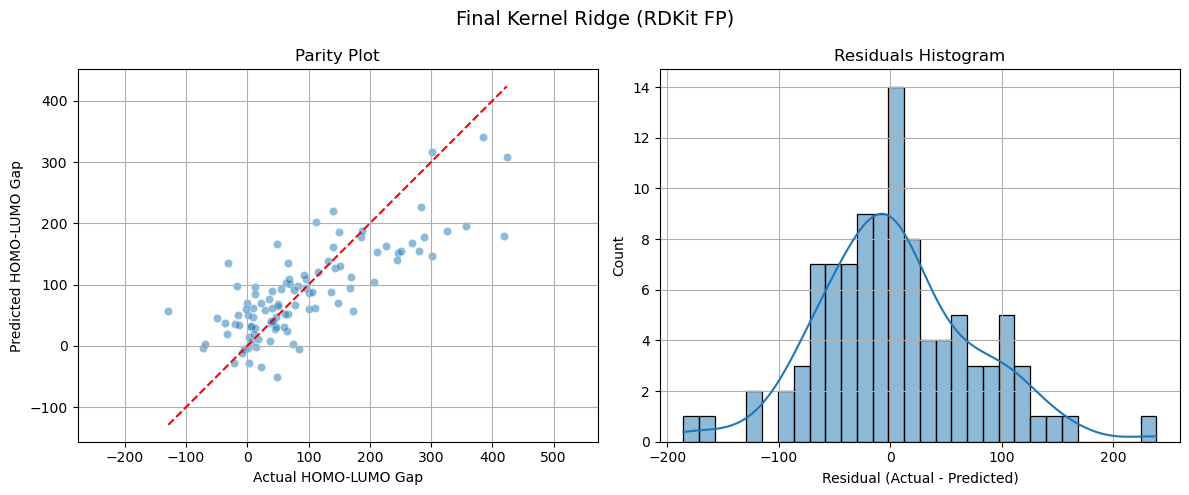

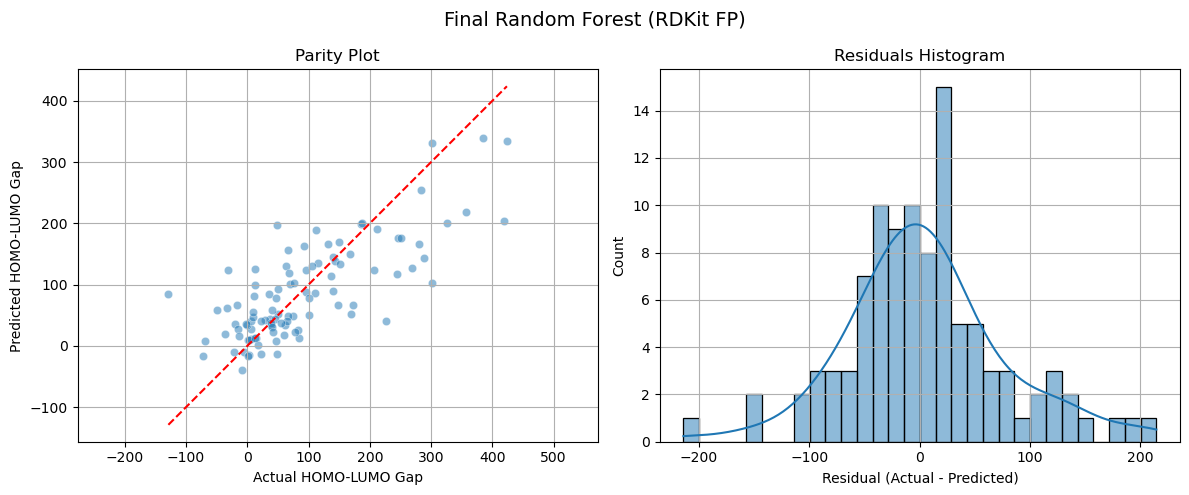

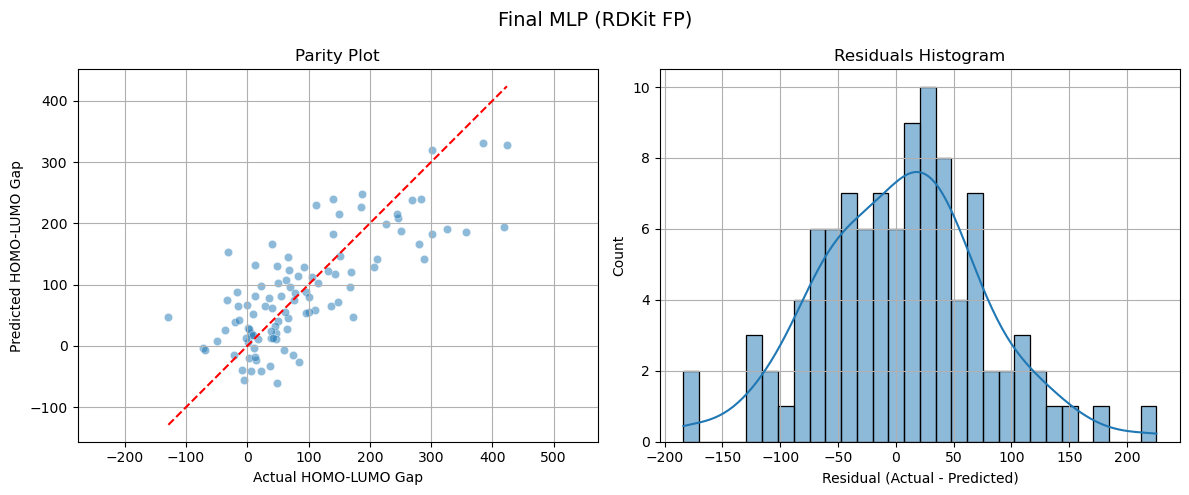

In [38]:
plot_regression_results(y_test_krr, final_preds_krr, title="Final Kernel Ridge (RDKit FP)", save_dir="plots")
plot_regression_results(y_test_unscaled, final_preds_rfr, title="Final Random Forest (RDKit FP)", save_dir="plots")
plot_regression_results(y_test_inv_fp, final_preds_inv_fp, title="Final MLP (RDKit FP)", save_dir="plots")
# plot_regression_results(y_test_inv_cm, final_preds_inv_cm, title="Final MLP (Coulomb Matrix)", save_dir="plots")


| Model Type             | Featurization        |   MAE |  RMSE |   R² | Notes             |
|------------------------|----------------------|-------|-------|------|-------------------|
| MLP (Tuned)          | RDKit Fingerprints   | 0.426 | 0.574 | 0.798 | Strong performance across all metrics   |
| KRR (Tuned)          | RDKit Fingerprints   | 0.454 | 0.593 | 0.784 | Good overall, slightly lower R² than MLP|
| RF (Tuned)           | RDKit Fingerprints   | 0.423| 0.583 | 0.791  | Top MAE, but slightly higher R²/RMSE    |
| MLP (Tuned)          | Coulomb Matrix       | 0.636 | 0.819 | 0.588 | Significantly worse than FP models      |
| MLP (Untuned Baseline) | RDKit Fingerprints | 0.467 | 0.609 | 0.772 | Reasonable baseline performance         |
| KRR (Untuned Baseline) | RDKit Fingerprints | 0.519 | 0.668 | 0.726 | Noticeable drop from tuned KRR          |
| RF (Untuned Baseline) | RDKit Fingerprints  | 0.426| 0.587 | 0.788  | Surprisingly strong untuned performance |
| MLP (Untuned Baseline) | Coulomb Matrix     | 0.663 | 0.847 | 0.559 | Confirms Coulomb Matrix as weak         |

Save best model and metrics

In [39]:
# create a save directory
os.makedirs("saved_models_Tg", exist_ok=True)

# save the final trained MLP model (Keras backend)
final_mlp_fp.model.save("saved_models_Tg/best_mlp_fp_model_keras")

# save the X and Y scalers
joblib.dump(xscaler_fp, "saved_models_Tg/xscaler_fp.pkl")
joblib.dump(yscaler, "saved_models_Tg/yscaler.pkl")

# save evaluation metrics
final_metrics_fp.to_csv("saved_models_Tg/best_mlp_fp_metrics.csv", index=False)

INFO:tensorflow:Assets written to: saved_models_Tg/best_mlp_fp_model_keras\assets


If you wanted to reload these later...

In [40]:
# from tensorflow.keras.models import load_model

# # load model and scalersand metrics
# mlp_model = load_model("saved_models/best_mlp_fp_model_keras")
# xscaler_fp = joblib.load("saved_models/xscaler_fp.pkl")
# yscaler = joblib.load("saved_models/yscaler.pkl")
# metrics_df = pd.read_csv("saved_models/best_mlp_fp_metrics.csv")

# Training a Baseline GNN with ChemML
ChemML's `tensorise_molecules` generates its own graph. Its important to note this graph is not the official graph from PCQM4Mv2. It may miss out on features OGB uses like formal charge, aromatacity flags, atomic chirality, and explicit hydrogens. However, tensorise_molecules is a good choice for quick prototyping and it handles graph generation and tensor formatting in a numpy-friendly way which was easier for me to understand. Final training will use smiles2graph for compatability with OGB splits and better feature representation. 

In [41]:
# tensorize molecules
X_atoms, X_bonds, X_edges = tensorise_molecules(valid_mol_objs)
y = df_clean['Tg'].values.reshape(-1, 1)

# train test split (80/20)
split = int(0.8 * len(y))
X_atoms_train, X_atoms_test = X_atoms[:split], X_atoms[split:]
X_bonds_train, X_bonds_test = X_bonds[:split], X_bonds[split:]
X_edges_train, X_edges_test = X_edges[:split], X_edges[split:]
y_train, y_test = y[:split], y[split:]

# scale target
yscaler = StandardScaler()
y_train_scaled = yscaler.fit_transform(y_train)

# model input shapes
max_atoms = X_atoms.shape[1]
max_degree = X_bonds.shape[2]
num_atom_features = X_atoms.shape[-1]
num_bond_features = X_bonds.shape[-1]

# input layers
atoms_input = Input(shape=(max_atoms, num_atom_features), name="atom_inputs")
bonds_input = Input(shape=(max_atoms, max_degree, num_bond_features), name="bond_inputs")
edges_input = Input(shape=(max_atoms, max_degree), name="edge_inputs", dtype="int32")

# GNN layers
conv1 = NeuralGraphHidden(8, activation='relu')([atoms_input, bonds_input, edges_input])
conv2 = NeuralGraphHidden(8, activation='relu')([conv1, bonds_input, edges_input])

fp1 = NeuralGraphOutput(128, activation='relu')([atoms_input, bonds_input, edges_input])
fp2 = NeuralGraphOutput(128, activation='relu')([conv1, bonds_input, edges_input])
fp3 = NeuralGraphOutput(128, activation='relu')([conv2, bonds_input, edges_input])

# fingerprint aggregation
fingerprint = Add()([fp1, fp2, fp3])

# dense layers
dense1 = Dense(128, activation='relu')(fingerprint)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(1, activation='linear')(dense2)

# model compilation
model = Model(inputs=[atoms_input, bonds_input, edges_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# model training
model.fit([X_atoms_train, X_bonds_train, X_edges_train], y_train_scaled, epochs=100, batch_size=64, verbose=1, validation_split=0.1)

# preds and eval
y_pred = model.predict([X_atoms_test, X_bonds_test, X_edges_test])
y_pred = yscaler.inverse_transform(y_pred)
metrics = regression_metrics(y_test, y_pred)
print("\nGNN Model Results:")
print(metrics[['MAE', 'RMSE', 'r_squared']])

Tensorising molecules in batches of 3000 ...
504/504 [==================================================] - 10s 21ms/step
Merging batch tensors ...    [DONE]
Epoch 1/100
6/6 [==============================] - 1s 89ms/step - loss: 211.7961 - val_loss: 4.2279
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 46.4533 - val_loss: 14.0274
Epoch 3/100
6/6 [==============================] - 0s 9ms/step - loss: 28.2108 - val_loss: 3.2301
Epoch 4/100
6/6 [==============================] - 0s 9ms/step - loss: 14.4109 - val_loss: 1.5478
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 8.2681 - val_loss: 1.6073
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 5.2334 - val_loss: 0.9518
Epoch 7/100
6/6 [==============================] - 0s 8ms/step - loss: 2.8695 - val_loss: 1.7679
Epoch 8/100
6/6 [==============================] - 0s 8ms/step - loss: 1.8212 - val_loss: 0.9395
Epoch 9/100
6/6 [==============================] - 0s 9ms/s

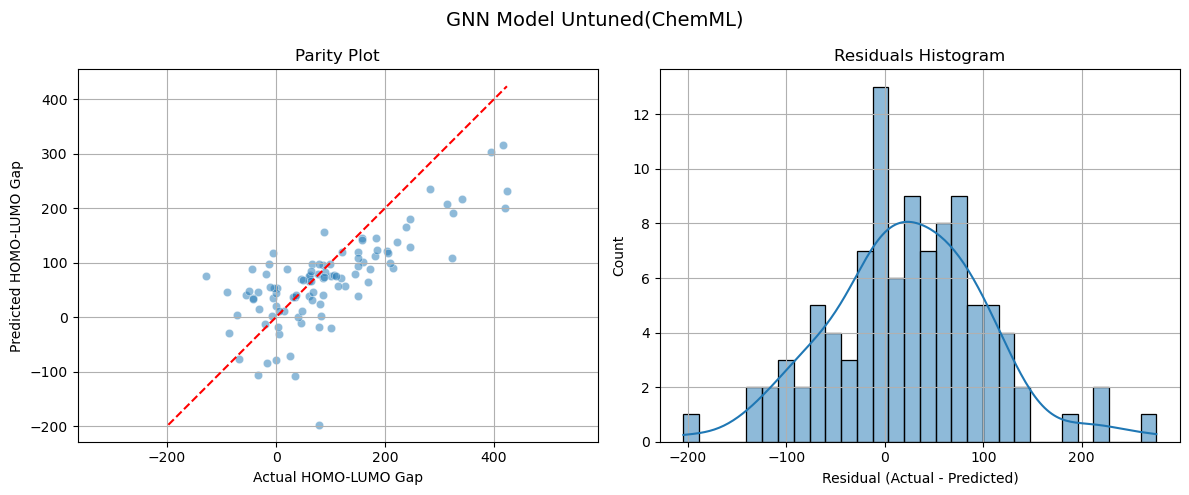

In [42]:
# plot results
plot_regression_results(y_test, y_pred, title="GNN Model Untuned(ChemML)", save_dir="plots")

In [43]:
from tensorflow.keras.metrics import MeanAbsoluteError

def objective_gnn(trial):
    conv_width = trial.suggest_categorical('conv_width', [8, 16, 32])
    fp_length = trial.suggest_categorical('fp_length', [96, 128, 160])
    n1 = trial.suggest_int('n1', 128, 192, step=32)
    n2 = trial.suggest_int('n2', 64, 96, step=32)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    alpha = trial.suggest_float('alpha', 1e-8, 1e-4, log=True)
    activation = 'relu'

    # model definition
    atoms_input = Input(shape=(max_atoms, num_atom_features), name="atom_inputs")
    bonds_input = Input(shape=(max_atoms, max_degree, num_bond_features), name="bond_inputs")
    edges_input = Input(shape=(max_atoms, max_degree), name="edge_inputs", dtype="int32")

    conv1 = NeuralGraphHidden(conv_width, activation=activation)([atoms_input, bonds_input, edges_input])
    conv2 = NeuralGraphHidden(conv_width, activation=activation)([conv1, bonds_input, edges_input])

    fp1 = NeuralGraphOutput(fp_length, activation=activation)([atoms_input, bonds_input, edges_input])
    fp2 = NeuralGraphOutput(fp_length, activation=activation)([conv1, bonds_input, edges_input])
    fp3 = NeuralGraphOutput(fp_length, activation=activation)([conv2, bonds_input, edges_input])
    fingerprint = Add()([fp1, fp2, fp3])

    dense1 = Dense(n1, activation=activation, kernel_regularizer=regularizers.l2(alpha))(fingerprint)
    dense2 = Dense(n2, activation=activation, kernel_regularizer=regularizers.l2(alpha))(dense1)
    output = Dense(1, activation='linear')(dense2)

    model = Model(inputs=[atoms_input, bonds_input, edges_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mean_squared_error', metrics=[MeanAbsoluteError()])

    history = model.fit([X_atoms_train, X_bonds_train, X_edges_train], y_train_scaled, epochs=100, batch_size=64, verbose=0, validation_split=0.2)

    # return best validation MAE
    val_mae = min(history.history["val_mean_absolute_error"])  
    return val_mae

study_gnn = optuna.create_study(direction='minimize')  
study_gnn.optimize(objective_gnn, n_trials=50)

[I 2025-09-04 20:17:31,688] A new study created in memory with name: no-name-db90c8e1-5bb4-4a60-b540-debf549064f0
[I 2025-09-04 20:17:38,194] Trial 0 finished with value: 0.5784119963645935 and parameters: {'conv_width': 16, 'fp_length': 160, 'n1': 160, 'n2': 64, 'lr': 0.0074779903531160775, 'alpha': 1.1713607039847262e-05}. Best is trial 0 with value: 0.5784119963645935.
[I 2025-09-04 20:17:44,489] Trial 1 finished with value: 0.6189797520637512 and parameters: {'conv_width': 8, 'fp_length': 160, 'n1': 192, 'n2': 96, 'lr': 2.0096572916443418e-05, 'alpha': 6.93435054090891e-07}. Best is trial 0 with value: 0.5784119963645935.
[I 2025-09-04 20:17:50,936] Trial 2 finished with value: 1.3424192667007446 and parameters: {'conv_width': 16, 'fp_length': 96, 'n1': 192, 'n2': 96, 'lr': 1.0740694360574098e-05, 'alpha': 4.07655092722975e-07}. Best is trial 0 with value: 0.5784119963645935.
[I 2025-09-04 20:17:57,470] Trial 3 finished with value: 0.6044057607650757 and parameters: {'conv_width': 

## Retraining ChemML GNN with Best Parameter Found in Optuna Search

In [44]:
params = study_gnn.best_params

# redefine and compile using best params
atoms_input = Input(shape=(max_atoms, num_atom_features), name="atom_inputs")
bonds_input = Input(shape=(max_atoms, max_degree, num_bond_features), name="bond_inputs")
edges_input = Input(shape=(max_atoms, max_degree), name="edge_inputs", dtype="int32")

conv1 = NeuralGraphHidden(params['conv_width'], activation='relu')([atoms_input, bonds_input, edges_input])
conv2 = NeuralGraphHidden(params['conv_width'], activation='relu')([conv1, bonds_input, edges_input])

fp1 = NeuralGraphOutput(params['fp_length'], activation='relu')([atoms_input, bonds_input, edges_input])
fp2 = NeuralGraphOutput(params['fp_length'],activation='relu')([conv1, bonds_input, edges_input])
fp3 = NeuralGraphOutput(params['fp_length'], activation='relu')([conv2, bonds_input, edges_input])
fingerprint = Add()([fp1, fp2, fp3])

dense1 = Dense(params['n1'], activation='relu', kernel_regularizer=regularizers.l2(params['alpha']))(fingerprint)
dense2 = Dense(params['n2'], activation='relu', kernel_regularizer=regularizers.l2(params['alpha']))(dense1)
output = Dense(1, activation='linear')(dense2)

final_gnn = Model(inputs=[atoms_input, bonds_input, edges_input], outputs=output)
final_gnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['lr']), loss='mean_squared_error')

final_gnn.fit([X_atoms_train, X_bonds_train, X_edges_train], y_train_scaled, epochs=200, batch_size=64, verbose=1)

# final eval
y_pred_final = final_gnn.predict([X_atoms_test, X_bonds_test, X_edges_test])
y_pred_final = yscaler.inverse_transform(y_pred_final)
final_metrics = regression_metrics(y_test, y_pred_final)
print("\nFinal Tuned GNN Results:")
print(final_metrics[['MAE', 'RMSE', 'r_squared']])

Epoch 1/200
7/7 [==============================] - 1s 29ms/step - loss: 1828.2208
Epoch 2/200
7/7 [==============================] - 0s 22ms/step - loss: 83.8997
Epoch 3/200
7/7 [==============================] - 0s 5ms/step - loss: 36.6573
Epoch 4/200
7/7 [==============================] - 0s 5ms/step - loss: 12.0149
Epoch 5/200
7/7 [==============================] - 0s 5ms/step - loss: 2.5238
Epoch 6/200
7/7 [==============================] - 0s 4ms/step - loss: 1.7810
Epoch 7/200
7/7 [==============================] - 0s 6ms/step - loss: 0.9541
Epoch 8/200
7/7 [==============================] - 0s 5ms/step - loss: 0.6475
Epoch 9/200
7/7 [==============================] - 0s 4ms/step - loss: 0.6104
Epoch 10/200
7/7 [==============================] - 0s 4ms/step - loss: 0.5773
Epoch 11/200
7/7 [==============================] - 0s 4ms/step - loss: 0.6357
Epoch 12/200
7/7 [==============================] - 0s 4ms/step - loss: 0.5952
Epoch 13/200
7/7 [==============================] - 0

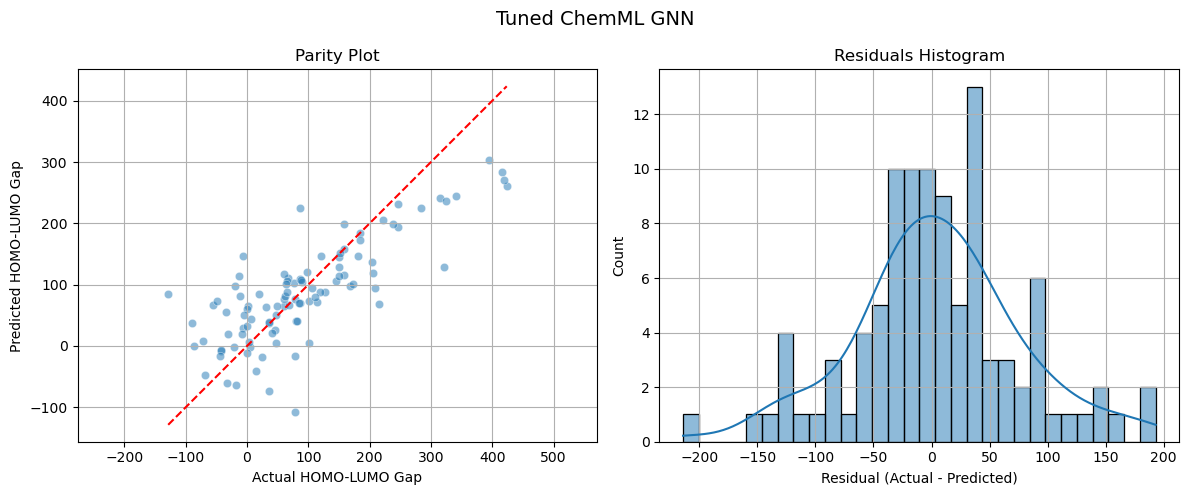

In [45]:
plot_regression_results(y_test, y_pred_final, title="Tuned ChemML GNN", save_dir="plots")

In [46]:
import json

# make a directory for this specific model
save_dir = "saved_models_Tg/gnn_tensorise_molecules_model"
os.makedirs(save_dir, exist_ok=True)

# 1. save the trained GNN model
final_gnn.save(os.path.join(save_dir, "gnn_tensorise_molecules_model_tf"), save_format="tf")

# 2. save the y target scaler
with open(os.path.join(save_dir, "gnn_tensorise_molecules_target_scaler.pkl"), "wb") as f:
    pickle.dump(yscaler, f)

# 3. save the final metrics
final_metrics.to_csv(os.path.join(save_dir, "gnn_tensorise_molecules_metrics.csv"), index=False)

# 4. save predictions
pred_df = pd.DataFrame({"true_gap": y_test.flatten(), "predicted_gap": y_pred_final.flatten()})
pred_df.to_csv(os.path.join(save_dir, "gnn_tensorise_molecules_predictions.csv"), index=False)

# 5. save the best hyperparameters
with open(os.path.join(save_dir, "gnn_tensorise_molecules_best_params.json"), "w") as f:
    json.dump(params, f, indent=4)

INFO:tensorflow:Assets written to: saved_models_Tg/gnn_tensorise_molecules_model\gnn_tensorise_molecules_model_tf\assets


## ChemML GNN Model Results
| Model Type             | Featurization        |   MAE |  RMSE |   R² | Notes             |
|------------------------|----------------------|-------|-------|------|-------------------|
| GNN (Tuned)            | tensorise_molecules Graph   | 0.302 | 0.411 | 0.900 | Best performance across all metrics   |
| GNN (Untuned)          | tensorise_molecules Graph   | 0.400 | 0.519 | 0.841 | Good overall|


---
# Final Model Training

Having explored different molecular graph representations and model architectures, I am now moving to training what is expected to be the best-performing model using the full dataset. The earlier GNN model was based on `tensorise_molecules` (ChemML) graphs and had strong performance with a **mean absolute error (MAE) around 0.30**. These graphs are based on RDKit's internal descriptors and do not reflect the original PCQM4Mv2 graph structure used in the Open Graph Benchmark (OGB). Therefore, I will shift focus to the `smiles2graph` representation provided by OGB, which aligns more directly with the benchmark's evaluation setup and top-performing models on the leaderboard.


| Source                         | Atom/Bond Features                                                 | Format                                          | Customizable?     | Alignment with PCQM4Mv2?  |
| ------------------------------ | ------------------------------------------------------------------ | ----------------------------------------------- | ----------------- | ---------------------- |
| `tensorise_molecules` (ChemML) | RDKit-based descriptors (ex: atom number, degree, hybridization) | NumPy tensors (`X_atoms`, `X_bonds`, `X_edges`) | Limited           |  Not aligned          |
| `smiles2graph` (OGB / PyG)     | Predefined categorical features from PCQM4Mv2                      | PyTorch Geometric `Data` objects                |  Highly flexible |  Matches OGB standard |

By using `smiles2graph`, we:

* Use OGB-standard graph construction and feature encoding for fair comparisons with leaderboard models
* Include learnable AtomEncoder and BondEncoder embeddings from `ogb.graphproppred.mol_encoder`, which improve model expressiveness
* Maintain compatibility with PyTorch Geometric, DGL, and OGB tools

I will also concatenate GNN-derived embeddings with SMILES-based RDKit descriptors, feeding this hybrid representation into MLP head. This allows you to combine structural and cheminformatics perspectives for improved prediction accuracy. With this setup, I aim to improve upon the MAE of \~0.30 achieved earlier and push closer toward state-of-the-art performance.


## Step 1: Load PyG-Compatible Dataset



In [47]:
def check_cuda():
    print("PyTorch version:", torch.__version__)
    print("CUDA available? ", torch.cuda.is_available())
    
    if torch.cuda.is_available():
        print("Device count:", torch.cuda.device_count())
        print("GPU Name:", torch.cuda.get_device_name(0))
        print("Current device:", torch.cuda.current_device())
    else:
        print("Running on CPU")

check_cuda()

PyTorch version: 2.4.1+cu118
CUDA available?  True
Device count: 1
GPU Name: NVIDIA GeForce RTX 3070 Ti
Current device: 0


In [48]:
# 1. load OGB dataset 
df_tg = pd.read_csv('cleaned_tg_dataset.csv')


#  Step 2: Extract SMILES from Original Dataset

In [49]:
# 2. Extract SMILES and FFV targets
# Your `df_ffv` already contains the SMILES and FFV columns.
smiles_list = df_tg['SMILES'].tolist()
ffv_list = df_tg['Tg'].tolist()

num_mols = len(smiles_list)
print(f"Loaded {num_mols} molecules.")

Loaded 504 molecules.


In [51]:
def compute_rdkit_features(smiles):
    cleaned_smiles = canonicalize_polymer_smiles(smiles)
    mol = Chem.MolFromSmiles(cleaned_smiles)
    if mol is None:
        return [np.nan] * 9  # Update the number of NaNs to match new features

    # Check for empty molecule
    if mol.GetNumAtoms() == 0:
        return [np.nan] * 9

    # Add features that capture size, shape, and interactions
    return [
        Descriptors.MolWt(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.RingCount(mol),
        Descriptors.FractionCSP3(mol),  # New: Fraction of sp3 hybridized carbons
        Descriptors.MolLogP(mol),      # New: Octanol-water partition coefficient
        Descriptors.NumSaturatedRings(mol) # New: Number of saturated rings
    ]

rdkit_features = np.array([compute_rdkit_features(smi) for smi in smiles_list])
print(f"Shape of RDKit features: {rdkit_features.shape}") # Should be (N, 9)

Shape of RDKit features: (504, 9)


In [52]:
# Remove rows with NaN values (failed RDKit featurization)
valid_indices = ~np.isnan(rdkit_features).any(axis=1)
rdkit_features = rdkit_features[valid_indices]
smiles_list = np.array(smiles_list)[valid_indices].tolist()
ffv_list = np.array(ffv_list)[valid_indices].tolist()

print(f"Kept {len(smiles_list)} molecules with valid RDKit features.")

Kept 504 molecules with valid RDKit features.


# Step 4: attach RDKit features to PyG data objects

In [53]:
import torch
from torch_geometric.data import Data, DataLoader

# Assuming your previous cells have loaded and processed the data into these lists:
# smiles_list: list of SMILES strings
# rdkit_features: numpy array of RDKit features (N, 6)
# ffv_list: list of FFV values (N,)

# 1. Create a list of PyG Data objects
rdkit_features_tensor = torch.tensor(rdkit_features, dtype=torch.float32)
ffv_targets_tensor = torch.tensor(ffv_list, dtype=torch.float32).view(-1, 1)

data_list = []
for i in range(len(smiles_list)):
    # smiles2graph returns a dictionary
    graph_dict = smiles2graph(smiles_list[i])
    
    # Create the Data object from the dictionary keys, converting to tensors
    # Convert node and edge features to LongTensor 
    data = Data(
        x=torch.tensor(graph_dict['node_feat'], dtype=torch.long),
        edge_index=torch.tensor(graph_dict['edge_index'], dtype=torch.long),
        edge_attr=torch.tensor(graph_dict['edge_feat'], dtype=torch.long),
        rdkit_feats=rdkit_features_tensor[i],
        y=ffv_targets_tensor[i]
    )
    data_list.append(data)

# 2. Split the dataset
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, random_state=42)

# 3. Create PyG DataLoaders
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

# 4. Verification
for batch in train_loader:
    print(batch)
    print("Batch's node features shape:", batch.x.shape)
    print("Batch's RDKit features shape:", batch.rdkit_feats.shape)
    print("Batch's targets shape:", batch.y.shape)
    print("Batch's 'batch' attribute shape:", batch.batch.shape)
    break

DataBatch(x=[1032, 9], edge_index=[2, 2182], edge_attr=[2182, 3], y=[32], rdkit_feats=[288], batch=[1032], ptr=[33])
Batch's node features shape: torch.Size([1032, 9])
Batch's RDKit features shape: torch.Size([288])
Batch's targets shape: torch.Size([32])
Batch's 'batch' attribute shape: torch.Size([1032])


c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Step 5: Define the Hybrid GNN Model

The final architecture uses both structural and cheminformatics data by combining GNN-learned graph embeddings with SMILES-derived RDKit descriptors. This Hybrid GNN model uses `smiles2graph` for graph construction and augments it with RDKit-based molecular features for improved prediction accuracy.

### Model Components:

* **AtomEncoder / BondEncoder**
  Transforms categorical atom and bond features (provided by OGB) into learnable embeddings using the encoders from `ogb.graphproppred.mol_encoder`. These provide a strong foundation for expressive graph learning.

* **GINEConv Layers (x2)**
  I use two stacked GINEConv layers (Graph Isomorphism Network with Edge features). These layers perform neighborhood aggregation based on edge attributes, allowing the model to capture localized chemical environments.

* **Global Mean Pooling**
  After message passing, node level embeddings are aggregated into a fixed size graph level representation using `global_mean_pool`.

* **Concatenation with RDKit Descriptors**
  The pooled GNN embedding is concatenated with external RDKit descriptors, which capture global molecular properties not easily inferred from graph data alone.

* **MLP Prediction Head**
  A multilayer perceptron processes the combined feature vector with ReLU activations, dropout regularization, and linear layers to predict the HOMO–LUMO gap.

In [54]:
class HybridGNN(Module):
    def __init__(self, gnn_dim, rdkit_dim, hidden_dim, dropout_rate=0.2):
        super().__init__()
        self.gnn_dim = gnn_dim
        self.rdkit_dim = rdkit_dim

        self.atom_encoder = AtomEncoder(emb_dim=gnn_dim)
        self.bond_encoder = BondEncoder(emb_dim=gnn_dim)

        self.conv1 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), ReLU(), Linear(gnn_dim, gnn_dim)))
        self.conv2 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), ReLU(), Linear(gnn_dim, gnn_dim)))
        self.pool = global_mean_pool

        self.mlp = Sequential(Linear(gnn_dim + rdkit_dim, hidden_dim), ReLU(), 
                              Dropout(dropout_rate),
                              Linear(hidden_dim, hidden_dim // 2), ReLU(), 
                              Dropout(dropout_rate),
                              Linear(hidden_dim // 2, 1))

    def forward(self, data):
        # encode atoms and bonds
        x = self.atom_encoder(data.x)
        edge_attr = self.bond_encoder(data.edge_attr)

        # GNN convolutions
        x = self.conv1(x, data.edge_index, edge_attr)
        x = self.conv2(x, data.edge_index, edge_attr)
        x = self.pool(x, data.batch)

        # handle RDKit features
        rdkit_feats = getattr(data, 'rdkit_feats', None)
        if rdkit_feats is not None:
            # Reshape the RDKit features tensor to be (batch_size, rdkit_dim)
            # The number of samples in the batch is given by x.shape[0] after pooling
            reshaped_rdkit_feats = rdkit_feats.view(x.shape[0], self.rdkit_dim)
            
            # The check for shape mismatch is now more accurate
            if x.shape[0] != reshaped_rdkit_feats.shape[0]:
                raise ValueError(f"Shape mismatch: GNN output ({x.shape[0]}) vs rdkit_feats ({reshaped_rdkit_feats.shape[0]})")
            
            x = torch.cat([x, reshaped_rdkit_feats], dim=1)
        else:
            raise ValueError("RDKit features not found in the data object")

        return self.mlp(x)

# Step 7: training loop 

In [55]:
# initialize model
model = HybridGNN(gnn_dim=128, rdkit_dim=rdkit_features.shape[1], hidden_dim=256)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
best_val_loss = float('inf')
patience = 10
patience_counter = 0

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            preds.append(pred.cpu())
            targets.append(batch.y.view(-1, 1).cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    loss = F.mse_loss(preds, targets)
    return loss.item(), preds, targets

# training loop
for epoch in range(1, 101): # long since early stopping
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch:02d}"):
        batch = batch.to(device)
        pred = model(batch)
        loss = F.mse_loss(pred, batch.y.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs

    train_loss = total_loss / len(train_loader.dataset)
    val_loss, val_preds, val_targets = evaluate(model, valid_loader)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        save_dir = "saved_models/gnn_smiles2graph_model"
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(save_dir, "hybridgnn_untuned.pt"))
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

# final eval on val set
model.load_state_dict(torch.load(os.path.join(save_dir, "hybridgnn_untuned.pt")))
model.eval()
_, final_preds, final_targets = evaluate(model, valid_loader)
metrics = regression_metrics(final_targets.numpy(), final_preds.numpy())
print("\nGNN Evaluation:")
print(metrics[['MAE', 'RMSE', 'r_squared']])

Epoch 01: 100%|██████████| 13/13 [00:00<00:00, 56.19it/s]


Epoch 01 | Train Loss: 14966.3594 | Val Loss: 11512.8027


Epoch 02: 100%|██████████| 13/13 [00:00<00:00, 108.91it/s]


Epoch 02 | Train Loss: 11906.9951 | Val Loss: 10899.3535


Epoch 03: 100%|██████████| 13/13 [00:00<00:00, 146.67it/s]


Epoch 03 | Train Loss: 10743.5882 | Val Loss: 9611.4268


Epoch 04: 100%|██████████| 13/13 [00:00<00:00, 143.66it/s]


Epoch 04 | Train Loss: 8785.2728 | Val Loss: 7241.0376


Epoch 05: 100%|██████████| 13/13 [00:00<00:00, 174.18it/s]


Epoch 05 | Train Loss: 7528.4167 | Val Loss: 5260.0454


Epoch 06: 100%|██████████| 13/13 [00:00<00:00, 174.39it/s]


Epoch 06 | Train Loss: 6511.8596 | Val Loss: 4957.6357


Epoch 07: 100%|██████████| 13/13 [00:00<00:00, 189.79it/s]


Epoch 07 | Train Loss: 6373.2477 | Val Loss: 4830.2041


Epoch 08: 100%|██████████| 13/13 [00:00<00:00, 181.92it/s]


Epoch 08 | Train Loss: 6298.0631 | Val Loss: 5033.8071


Epoch 09: 100%|██████████| 13/13 [00:00<00:00, 185.13it/s]


Epoch 09 | Train Loss: 6202.5309 | Val Loss: 5345.5386


Epoch 10: 100%|██████████| 13/13 [00:00<00:00, 179.89it/s]


Epoch 10 | Train Loss: 6072.5673 | Val Loss: 4692.9863


Epoch 11: 100%|██████████| 13/13 [00:00<00:00, 182.53it/s]


Epoch 11 | Train Loss: 5881.2335 | Val Loss: 4204.9956


Epoch 12: 100%|██████████| 13/13 [00:00<00:00, 187.21it/s]


Epoch 12 | Train Loss: 6033.7601 | Val Loss: 4466.8452


Epoch 13: 100%|██████████| 13/13 [00:00<00:00, 188.90it/s]


Epoch 13 | Train Loss: 5463.4788 | Val Loss: 4294.0400


Epoch 14: 100%|██████████| 13/13 [00:00<00:00, 190.59it/s]


Epoch 14 | Train Loss: 5408.3220 | Val Loss: 4383.6260


Epoch 15: 100%|██████████| 13/13 [00:00<00:00, 188.27it/s]


Epoch 15 | Train Loss: 5344.6625 | Val Loss: 4296.7295


Epoch 16: 100%|██████████| 13/13 [00:00<00:00, 160.91it/s]

Epoch 16 | Train Loss: 5411.0325 | Val Loss: 3983.4153

Epoch 17: 100%|██████████| 13/13 [00:00<00:00, 192.69it/s]


Epoch 17 | Train Loss: 5319.1668 | Val Loss: 4663.2109


Epoch 18: 100%|██████████| 13/13 [00:00<00:00, 180.17it/s]


Epoch 18 | Train Loss: 5129.0778 | Val Loss: 4066.8186


Epoch 19: 100%|██████████| 13/13 [00:00<00:00, 186.87it/s]


Epoch 19 | Train Loss: 5256.7686 | Val Loss: 3979.9561


Epoch 20: 100%|██████████| 13/13 [00:00<00:00, 189.55it/s]


Epoch 20 | Train Loss: 5255.6155 | Val Loss: 3947.0869


Epoch 21: 100%|██████████| 13/13 [00:00<00:00, 187.20it/s]


Epoch 21 | Train Loss: 5253.9092 | Val Loss: 4706.0840


Epoch 22: 100%|██████████| 13/13 [00:00<00:00, 186.81it/s]


Epoch 22 | Train Loss: 5246.5679 | Val Loss: 3758.7673


Epoch 23: 100%|██████████| 13/13 [00:00<00:00, 190.94it/s]


Epoch 23 | Train Loss: 5158.5457 | Val Loss: 4060.2219


Epoch 24: 100%|██████████| 13/13 [00:00<00:00, 182.36it/s]


Epoch 24 | Train Loss: 5331.8837 | Val Loss: 3814.5479


Epoch 25: 100%|██████████| 13/13 [00:00<00:00, 195.77it/s]


Epoch 25 | Train Loss: 5026.8245 | Val Loss: 3753.6323


Epoch 26: 100%|██████████| 13/13 [00:00<00:00, 193.54it/s]


Epoch 26 | Train Loss: 5182.1413 | Val Loss: 3896.1770


Epoch 27: 100%|██████████| 13/13 [00:00<00:00, 180.88it/s]


Epoch 27 | Train Loss: 5047.7241 | Val Loss: 4028.5186


Epoch 28: 100%|██████████| 13/13 [00:00<00:00, 181.82it/s]


Epoch 28 | Train Loss: 4811.0276 | Val Loss: 3648.0947


Epoch 29: 100%|██████████| 13/13 [00:00<00:00, 194.23it/s]


Epoch 29 | Train Loss: 5646.3687 | Val Loss: 4162.8652


Epoch 30: 100%|██████████| 13/13 [00:00<00:00, 191.09it/s]


Epoch 30 | Train Loss: 4846.5465 | Val Loss: 3878.0186


Epoch 31: 100%|██████████| 13/13 [00:00<00:00, 191.07it/s]


Epoch 31 | Train Loss: 6162.0335 | Val Loss: 4631.7622


Epoch 32: 100%|██████████| 13/13 [00:00<00:00, 158.61it/s]


Epoch 32 | Train Loss: 5209.3660 | Val Loss: 3894.0901


Epoch 33: 100%|██████████| 13/13 [00:00<00:00, 145.37it/s]


Epoch 33 | Train Loss: 4992.0203 | Val Loss: 3679.9302


Epoch 34: 100%|██████████| 13/13 [00:00<00:00, 190.67it/s]


Epoch 34 | Train Loss: 4755.7412 | Val Loss: 4186.1157


Epoch 35: 100%|██████████| 13/13 [00:00<00:00, 188.54it/s]


Epoch 35 | Train Loss: 4899.7240 | Val Loss: 4629.9097


Epoch 36: 100%|██████████| 13/13 [00:00<00:00, 190.05it/s]


Epoch 36 | Train Loss: 5413.9676 | Val Loss: 3831.4146


Epoch 37: 100%|██████████| 13/13 [00:00<00:00, 189.17it/s]


Epoch 37 | Train Loss: 5086.3598 | Val Loss: 3549.2380


Epoch 38: 100%|██████████| 13/13 [00:00<00:00, 197.74it/s]


Epoch 38 | Train Loss: 4901.6471 | Val Loss: 3913.9961


Epoch 39: 100%|██████████| 13/13 [00:00<00:00, 186.42it/s]


Epoch 39 | Train Loss: 5115.3100 | Val Loss: 3815.6223


Epoch 40: 100%|██████████| 13/13 [00:00<00:00, 191.28it/s]


Epoch 40 | Train Loss: 5137.0548 | Val Loss: 3621.1484


Epoch 41: 100%|██████████| 13/13 [00:00<00:00, 190.03it/s]


Epoch 41 | Train Loss: 4767.4431 | Val Loss: 3557.8435


Epoch 42: 100%|██████████| 13/13 [00:00<00:00, 197.13it/s]


Epoch 42 | Train Loss: 4819.3917 | Val Loss: 3636.8264


Epoch 43: 100%|██████████| 13/13 [00:00<00:00, 186.03it/s]


Epoch 43 | Train Loss: 4575.3529 | Val Loss: 4151.1333


Epoch 44: 100%|██████████| 13/13 [00:00<00:00, 188.72it/s]


Epoch 44 | Train Loss: 4343.1091 | Val Loss: 3672.1860


Epoch 45: 100%|██████████| 13/13 [00:00<00:00, 186.25it/s]


Epoch 45 | Train Loss: 4261.4937 | Val Loss: 3389.3625


Epoch 46: 100%|██████████| 13/13 [00:00<00:00, 193.50it/s]


Epoch 46 | Train Loss: 4333.4151 | Val Loss: 3795.0637


Epoch 47: 100%|██████████| 13/13 [00:00<00:00, 197.49it/s]


Epoch 47 | Train Loss: 4247.1842 | Val Loss: 3430.1091


Epoch 48: 100%|██████████| 13/13 [00:00<00:00, 194.18it/s]


Epoch 48 | Train Loss: 4515.8931 | Val Loss: 3460.2070


Epoch 49: 100%|██████████| 13/13 [00:00<00:00, 199.39it/s]


Epoch 49 | Train Loss: 4662.5827 | Val Loss: 3846.5139


Epoch 50: 100%|██████████| 13/13 [00:00<00:00, 196.82it/s]


Epoch 50 | Train Loss: 4598.3637 | Val Loss: 3573.2383


Epoch 51: 100%|██████████| 13/13 [00:00<00:00, 158.14it/s]


Epoch 51 | Train Loss: 4344.3891 | Val Loss: 3504.3071


Epoch 52: 100%|██████████| 13/13 [00:00<00:00, 196.16it/s]


Epoch 52 | Train Loss: 4150.7536 | Val Loss: 3829.3174


Epoch 53: 100%|██████████| 13/13 [00:00<00:00, 189.94it/s]


Epoch 53 | Train Loss: 4090.6537 | Val Loss: 3471.9014


Epoch 54: 100%|██████████| 13/13 [00:00<00:00, 182.10it/s]


Epoch 54 | Train Loss: 4166.8423 | Val Loss: 4461.0220


Epoch 55: 100%|██████████| 13/13 [00:00<00:00, 187.35it/s]

Epoch 55 | Train Loss: 4184.6097 | Val Loss: 3463.1172
Early stopping triggered at epoch 55

GNN Evaluation:
         MAE       RMSE  r_squared
0  41.288761  58.218231   0.727795



C:\Users\mattg\AppData\Local\Temp\ipykernel_31444\2343932047.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(save_dir, "h

# Step 8: Optuna tuning of Hybrid GNN

In [63]:
class HybridGNN(Module):
    def __init__(self, gnn_dim, rdkit_dim, hidden_dim, dropout_rate=0.2, activation='ReLU'):
        super().__init__()
        act_map = {'ReLU': torch.nn.ReLU(), 'ELU': torch.nn.ELU(), 'GELU': torch.nn.GELU(), 'LeakyReLU': torch.nn.LeakyReLU(), 'PReLU': torch.nn.PReLU(), 'Swish': torch.nn.SiLU()}
        act_fn = act_map[activation]
        self.gnn_dim = gnn_dim
        self.rdkit_dim = rdkit_dim

        self.atom_encoder = AtomEncoder(emb_dim=gnn_dim)
        self.bond_encoder = BondEncoder(emb_dim=gnn_dim)

        self.conv1 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), act_fn, Linear(gnn_dim, gnn_dim)))
        self.conv2 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), act_fn, Linear(gnn_dim, gnn_dim)))
        self.pool = global_mean_pool

        self.mlp = Sequential(Linear(gnn_dim + rdkit_dim, hidden_dim), act_fn, 
                              Dropout(dropout_rate), 
                              Linear(hidden_dim, hidden_dim // 2), act_fn, 
                              Dropout(dropout_rate), 
                              Linear(hidden_dim // 2, 1))

    def forward(self, data):
        # encode atoms and bonds
        x = self.atom_encoder(data.x)
        edge_attr = self.bond_encoder(data.edge_attr)

        # GNN convolutions
        x = self.conv1(x, data.edge_index, edge_attr)
        x = self.conv2(x, data.edge_index, edge_attr)
        x = self.pool(x, data.batch)

        # handle RDKit features
        rdkit_feats = getattr(data, 'rdkit_feats', None)
        if rdkit_feats is not None:
            # Reshape the RDKit features tensor to be (batch_size, rdkit_dim)
            # The number of samples in the batch is given by x.shape[0] after pooling
            reshaped_rdkit_feats = rdkit_feats.view(x.shape[0], self.rdkit_dim)
            
            # The check for shape mismatch is now more accurate
            if x.shape[0] != reshaped_rdkit_feats.shape[0]:
                raise ValueError(f"Shape mismatch: GNN output ({x.shape[0]}) vs rdkit_feats ({reshaped_rdkit_feats.shape[0]})")
            
            x = torch.cat([x, reshaped_rdkit_feats], dim=1)
        else:
            raise ValueError("RDKit features not found in the data object")

        return self.mlp(x)

Multiple rounds of tuning have suggested to refine my search space to ReLU, GELU, and Swish activation functions and Adam and AdamW optimizers. Therefore, I have commented out unused parameters like momentum for SGD and the unused optimizers. 

In [67]:
def objective(trial):
    # hyperparameter search space
    gnn_dim = trial.suggest_categorical("gnn_dim", [384, 512, 1024])
    hidden_dim = trial.suggest_categorical("hidden_dim", [256, 384, 512])
    dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.4)
    lr = trial.suggest_float("lr", 8e-6, 1e-3, log=True)
    activation = trial.suggest_categorical("activation", ['ReLU', 'GELU', 'Swish'])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD", "RMSprop"])
    momentum = trial.suggest_float("momentum", 0.8, 0.99, log=True) if optimizer_name == "SGD" else None
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    # Corrected Data Splitting for Polymer Data 
    # Split the full data_list into train, validation, and test sets.
    # Note: `data_list` should be created in a previous cell.
    train_val_set, test_set = train_test_split(data_list, test_size=0.2, random_state=42)
    train_set, val_set = train_test_split(train_val_set, test_size=0.25, random_state=42)
    
    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
    valid_loader = DataLoader(val_set, batch_size=64)
    
    # model instantiation
    # The rdkit_dim is dynamically taken from the pre-processed features.
    model = HybridGNN(
        gnn_dim=gnn_dim,
        rdkit_dim=rdkit_features.shape[1],
        hidden_dim=hidden_dim,
        dropout_rate=dropout_rate,
        activation=activation
    )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # optimizer instantiation
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Optimizer '{optimizer_name}' not supported")

    # training loop with NaN check and early stopping
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(1, 100):
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss = F.mse_loss(pred, batch.y.view(-1, 1))

            if torch.isnan(loss).any():
                print(f"Trial {trial.number} | Epoch {epoch:02d} | NaN loss detected so pruning trial")
                trial.report(float('inf'), epoch)
                raise optuna.TrialPruned()

            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs
        train_loss /= len(train_loader.dataset)

        # validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in valid_loader:
                batch = batch.to(device)
                pred = model(batch)
                val_loss += F.mse_loss(pred, batch.y.view(-1, 1)).item() * batch.num_graphs
        val_loss /= len(valid_loader.dataset)

        # logging, reporting, pruning, early stopping
        print(f"Trial {trial.number} | Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Optimizer: {optimizer_name}")
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Trial {trial.number} - Early stopping triggered at epoch {epoch}")
                break

    return best_val_loss

if __name__ == '__main__':
    study_name = "final_2d_gnn_study_Tg_4"
    storage_name = f"sqlite:///{study_name}.db"
    study = optuna.create_study(study_name=study_name, storage=storage_name, direction="minimize", pruner=optuna.pruners.MedianPruner())

    def save_study_callback(study, trial):
        pass

    study.optimize(objective, n_trials=500, callbacks=[save_study_callback])
    print(study.best_params)
    joblib.dump(study, f"{study_name}_final.pkl")
    
    # final plots
    vis = optuna.visualization
    fig = vis.plot_optimization_history(study)
    fig.show()
    fig_params = vis.plot_param_importances(study)
    fig_params.show()
    fig_intermediate = vis.plot_intermediate_values(study)
    fig_intermediate.show()
    fig_parallel_coordinate = vis.plot_parallel_coordinate(study)
    fig_parallel_coordinate.show()
    fig_slice = vis.plot_slice(study)
    fig_slice.show()

[I 2025-09-04 20:32:50,405] A new study created in RDB with name: final_2d_gnn_study_Tg_4
c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead



Trial 0 | Epoch 01 | Train Loss: 22615.4778 | Val Loss: 24309.1672 | Optimizer: Adam
Trial 0 | Epoch 02 | Train Loss: 22246.0442 | Val Loss: 23994.1601 | Optimizer: Adam
Trial 0 | Epoch 03 | Train Loss: 21980.5986 | Val Loss: 23684.7207 | Optimizer: Adam
Trial 0 | Epoch 04 | Train Loss: 21612.3958 | Val Loss: 23385.0100 | Optimizer: Adam
Trial 0 | Epoch 05 | Train Loss: 21344.4977 | Val Loss: 23090.7039 | Optimizer: Adam
Trial 0 | Epoch 06 | Train Loss: 21109.8644 | Val Loss: 22797.8876 | Optimizer: Adam
Trial 0 | Epoch 07 | Train Loss: 20819.2765 | Val Loss: 22505.9068 | Optimizer: Adam
Trial 0 | Epoch 08 | Train Loss: 20556.8369 | Val Loss: 22203.4485 | Optimizer: Adam
Trial 0 | Epoch 09 | Train Loss: 20250.1706 | Val Loss: 21891.5765 | Optimizer: Adam
Trial 0 | Epoch 10 | Train Loss: 19961.2807 | Val Loss: 21563.0911 | Optimizer: Adam
Trial 0 | Epoch 11 | Train Loss: 19638.6439 | Val Loss: 21221.8345 | Optimizer: Adam
Trial 0 | Epoch 12 | Train Loss: 19396.7511 | Val Loss: 20872.669

[I 2025-09-04 20:32:55,969] Trial 0 finished with value: 6458.3331190052595 and parameters: {'gnn_dim': 384, 'hidden_dim': 512, 'dropout_rate': 0.3114341269529591, 'lr': 2.259564567566569e-05, 'activation': 'ReLU', 'optimizer': 'Adam', 'weight_decay': 1.6988711084377392e-06}. Best is trial 0 with value: 6458.3331190052595.


Trial 0 | Epoch 99 | Train Loss: 7003.8059 | Val Loss: 6477.6510 | Optimizer: Adam
Trial 1 | Epoch 01 | Train Loss: 20828.6091 | Val Loss: 22035.8284 | Optimizer: RMSprop
Trial 1 | Epoch 02 | Train Loss: 19948.8897 | Val Loss: 21343.6321 | Optimizer: RMSprop
Trial 1 | Epoch 03 | Train Loss: 19216.1397 | Val Loss: 20591.3654 | Optimizer: RMSprop
Trial 1 | Epoch 04 | Train Loss: 18560.1985 | Val Loss: 19650.2190 | Optimizer: RMSprop
Trial 1 | Epoch 05 | Train Loss: 17722.9433 | Val Loss: 18435.8160 | Optimizer: RMSprop
Trial 1 | Epoch 06 | Train Loss: 16546.4409 | Val Loss: 16935.1610 | Optimizer: RMSprop
Trial 1 | Epoch 07 | Train Loss: 15046.4045 | Val Loss: 15237.5526 | Optimizer: RMSprop
Trial 1 | Epoch 08 | Train Loss: 13602.8463 | Val Loss: 13750.5290 | Optimizer: RMSprop
Trial 1 | Epoch 09 | Train Loss: 12135.6541 | Val Loss: 12400.6063 | Optimizer: RMSprop
Trial 1 | Epoch 10 | Train Loss: 11069.5191 | Val Loss: 11519.3872 | Optimizer: RMSprop
Trial 1 | Epoch 11 | Train Loss: 1018

[I 2025-09-04 20:33:00,910] Trial 1 finished with value: 6176.655341120049 and parameters: {'gnn_dim': 384, 'hidden_dim': 256, 'dropout_rate': 0.279674211400994, 'lr': 2.6204602506041883e-05, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 9.585616350224761e-06}. Best is trial 1 with value: 6176.655341120049.


Trial 1 | Epoch 99 | Train Loss: 6898.1923 | Val Loss: 6176.6553 | Optimizer: RMSprop
Trial 2 | Epoch 01 | Train Loss: 20582.0657 | Val Loss: 20821.8570 | Optimizer: Adam
Trial 2 | Epoch 02 | Train Loss: 18057.5555 | Val Loss: 17460.6442 | Optimizer: Adam
Trial 2 | Epoch 03 | Train Loss: 13466.6776 | Val Loss: 11086.3165 | Optimizer: Adam
Trial 2 | Epoch 04 | Train Loss: 11673.1376 | Val Loss: 10528.1342 | Optimizer: Adam
Trial 2 | Epoch 05 | Train Loss: 9967.3166 | Val Loss: 10457.7427 | Optimizer: Adam
Trial 2 | Epoch 06 | Train Loss: 9864.9967 | Val Loss: 9364.2067 | Optimizer: Adam
Trial 2 | Epoch 07 | Train Loss: 8623.7742 | Val Loss: 7958.8890 | Optimizer: Adam
Trial 2 | Epoch 08 | Train Loss: 8450.6232 | Val Loss: 7461.8945 | Optimizer: Adam
Trial 2 | Epoch 09 | Train Loss: 8130.6314 | Val Loss: 7597.0396 | Optimizer: Adam
Trial 2 | Epoch 10 | Train Loss: 7645.9180 | Val Loss: 6198.2959 | Optimizer: Adam
Trial 2 | Epoch 11 | Train Loss: 7196.8555 | Val Loss: 6265.8615 | Optimize

[I 2025-09-04 20:33:03,125] Trial 2 finished with value: 5066.432979772587 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.2954992251671889, 'lr': 0.000359806924945697, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 9.784632875052921e-05}. Best is trial 2 with value: 5066.432979772587.


Trial 2 | Epoch 40 | Train Loss: 4990.5533 | Val Loss: 5158.2643 | Optimizer: Adam
Trial 2 | Epoch 41 | Train Loss: 5316.0933 | Val Loss: 5188.9939 | Optimizer: Adam
Trial 2 - Early stopping triggered at epoch 41
Trial 3 | Epoch 01 | Train Loss: 20294.8619 | Val Loss: 23701.0880 | Optimizer: SGD
Trial 3 | Epoch 02 | Train Loss: 20785.9923 | Val Loss: 11416.8872 | Optimizer: SGD
Trial 3 | Epoch 03 | Train Loss: 15812.2334 | Val Loss: 22964.4979 | Optimizer: SGD
Trial 3 | Epoch 04 | Train Loss: 18984.2436 | Val Loss: 23531.4586 | Optimizer: SGD
Trial 3 | Epoch 05 | Train Loss: 21613.3964 | Val Loss: 23480.7724 | Optimizer: SGD
Trial 3 | Epoch 06 | Train Loss: 21561.6076 | Val Loss: 23431.0366 | Optimizer: SGD
Trial 3 | Epoch 07 | Train Loss: 21518.8821 | Val Loss: 23394.9444 | Optimizer: SGD
Trial 3 | Epoch 08 | Train Loss: 21491.9968 | Val Loss: 23375.7330 | Optimizer: SGD
Trial 3 | Epoch 09 | Train Loss: 21473.4174 | Val Loss: 23357.8303 | Optimizer: SGD
Trial 3 | Epoch 10 | Train Loss

[I 2025-09-04 20:33:03,760] Trial 3 finished with value: 11416.88718285891 and parameters: {'gnn_dim': 384, 'hidden_dim': 256, 'dropout_rate': 0.27004144501157257, 'lr': 1.6130666533531174e-05, 'activation': 'ReLU', 'optimizer': 'SGD', 'momentum': 0.8078316510437843, 'weight_decay': 2.5197851309764388e-05}. Best is trial 2 with value: 5066.432979772587.


Trial 4 | Epoch 01 | Train Loss: 21108.2479 | Val Loss: 22499.7998 | Optimizer: Adam
Trial 4 | Epoch 02 | Train Loss: 20354.1674 | Val Loss: 21774.7888 | Optimizer: Adam
Trial 4 | Epoch 03 | Train Loss: 19768.8500 | Val Loss: 20995.7016 | Optimizer: Adam
Trial 4 | Epoch 04 | Train Loss: 19050.8290 | Val Loss: 20076.8817 | Optimizer: Adam
Trial 4 | Epoch 05 | Train Loss: 17960.2417 | Val Loss: 18806.3985 | Optimizer: Adam
Trial 4 | Epoch 06 | Train Loss: 16631.9339 | Val Loss: 16841.4042 | Optimizer: Adam
Trial 4 | Epoch 07 | Train Loss: 14442.4576 | Val Loss: 13810.8011 | Optimizer: Adam
Trial 4 | Epoch 08 | Train Loss: 11614.8852 | Val Loss: 11053.7547 | Optimizer: Adam
Trial 4 | Epoch 09 | Train Loss: 11369.6263 | Val Loss: 11195.3047 | Optimizer: Adam
Trial 4 | Epoch 10 | Train Loss: 10356.0719 | Val Loss: 10394.4846 | Optimizer: Adam
Trial 4 | Epoch 11 | Train Loss: 9972.8905 | Val Loss: 10384.9702 | Optimizer: Adam
Trial 4 | Epoch 12 | Train Loss: 9766.0867 | Val Loss: 9835.2212 |

[I 2025-09-04 20:33:09,191] Trial 4 finished with value: 4884.735221031869 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.2855393115752087, 'lr': 0.00010785040998541331, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 6.181383857104351e-05}. Best is trial 4 with value: 4884.735221031869.


Trial 4 | Epoch 97 | Train Loss: 4818.5021 | Val Loss: 4913.0885 | Optimizer: Adam
Trial 4 | Epoch 98 | Train Loss: 5169.4385 | Val Loss: 5000.8569 | Optimizer: Adam
Trial 4 | Epoch 99 | Train Loss: 4811.7896 | Val Loss: 5131.5078 | Optimizer: Adam
Trial 4 - Early stopping triggered at epoch 99


[I 2025-09-04 20:33:09,342] Trial 5 pruned. 
[I 2025-09-04 20:33:09,493] Trial 6 pruned. 


Trial 5 | Epoch 01 | Train Loss: 21470.5019 | Val Loss: 22512.6190 | Optimizer: AdamW
Trial 6 | Epoch 01 | Train Loss: 21534.0195 | Val Loss: 23147.7430 | Optimizer: RMSprop


[I 2025-09-04 20:33:09,590] Trial 7 pruned. 


Trial 7 | Epoch 01 | NaN loss detected so pruning trial
Trial 8 | Epoch 01 | Train Loss: 18279.4363 | Val Loss: 13247.2091 | Optimizer: RMSprop
Trial 8 | Epoch 02 | Train Loss: 12073.5674 | Val Loss: 10872.7915 | Optimizer: RMSprop
Trial 8 | Epoch 03 | Train Loss: 9942.4329 | Val Loss: 9473.4938 | Optimizer: RMSprop
Trial 8 | Epoch 04 | Train Loss: 9137.9622 | Val Loss: 8720.4748 | Optimizer: RMSprop
Trial 8 | Epoch 05 | Train Loss: 8099.5203 | Val Loss: 7851.2888 | Optimizer: RMSprop
Trial 8 | Epoch 06 | Train Loss: 8075.6828 | Val Loss: 7265.3741 | Optimizer: RMSprop
Trial 8 | Epoch 07 | Train Loss: 7621.8743 | Val Loss: 7014.5474 | Optimizer: RMSprop
Trial 8 | Epoch 08 | Train Loss: 7843.0348 | Val Loss: 7810.5635 | Optimizer: RMSprop
Trial 8 | Epoch 09 | Train Loss: 7870.2962 | Val Loss: 6790.0211 | Optimizer: RMSprop
Trial 8 | Epoch 10 | Train Loss: 7619.0797 | Val Loss: 6780.4913 | Optimizer: RMSprop
Trial 8 | Epoch 11 | Train Loss: 7556.3600 | Val Loss: 6528.8556 | Optimizer: RM

[I 2025-09-04 20:33:12,825] Trial 8 finished with value: 5153.819055538366 and parameters: {'gnn_dim': 512, 'hidden_dim': 512, 'dropout_rate': 0.38647214299409266, 'lr': 8.184948648838637e-05, 'activation': 'GELU', 'optimizer': 'RMSprop', 'weight_decay': 1.4045095239369073e-05}. Best is trial 4 with value: 4884.735221031869.
[I 2025-09-04 20:33:12,932] Trial 9 pruned. 


Trial 8 | Epoch 60 | Train Loss: 5973.6327 | Val Loss: 5183.9962 | Optimizer: RMSprop
Trial 8 - Early stopping triggered at epoch 60
Trial 9 | Epoch 01 | Train Loss: 21347.2123 | Val Loss: 23172.1336 | Optimizer: AdamW


[I 2025-09-04 20:33:13,052] Trial 10 pruned. 


Trial 10 | Epoch 01 | Train Loss: 22248.0734 | Val Loss: 23666.7557 | Optimizer: Adam
Trial 11 | Epoch 01 | Train Loss: 20829.7745 | Val Loss: 21486.3354 | Optimizer: Adam
Trial 11 | Epoch 02 | Train Loss: 19069.4527 | Val Loss: 19131.5603 | Optimizer: Adam
Trial 11 | Epoch 03 | Train Loss: 16312.2804 | Val Loss: 15272.7141 | Optimizer: Adam
Trial 11 | Epoch 04 | Train Loss: 12221.8207 | Val Loss: 11269.9803 | Optimizer: Adam
Trial 11 | Epoch 05 | Train Loss: 11508.2263 | Val Loss: 10481.9567 | Optimizer: Adam
Trial 11 | Epoch 06 | Train Loss: 10113.6274 | Val Loss: 10934.5436 | Optimizer: Adam
Trial 11 | Epoch 07 | Train Loss: 10062.5310 | Val Loss: 9727.4533 | Optimizer: Adam
Trial 11 | Epoch 08 | Train Loss: 9123.3747 | Val Loss: 8319.3348 | Optimizer: Adam
Trial 11 | Epoch 09 | Train Loss: 8544.9009 | Val Loss: 7673.2426 | Optimizer: Adam
Trial 11 | Epoch 10 | Train Loss: 7993.3461 | Val Loss: 7702.6019 | Optimizer: Adam
Trial 11 | Epoch 11 | Train Loss: 7655.6682 | Val Loss: 6536.

[I 2025-09-04 20:33:17,230] Trial 11 finished with value: 4846.0888671875 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.29301594324415503, 'lr': 0.0002714126951500106, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 9.667669781987394e-05}. Best is trial 11 with value: 4846.0888671875.


Trial 11 | Epoch 74 | Train Loss: 4687.4568 | Val Loss: 4906.1127 | Optimizer: Adam
Trial 11 | Epoch 75 | Train Loss: 4966.2586 | Val Loss: 4851.4250 | Optimizer: Adam
Trial 11 | Epoch 76 | Train Loss: 4908.5821 | Val Loss: 5349.6235 | Optimizer: Adam
Trial 11 - Early stopping triggered at epoch 76


[I 2025-09-04 20:33:17,362] Trial 12 pruned. 
[I 2025-09-04 20:33:17,496] Trial 13 pruned. 


Trial 12 | Epoch 01 | Train Loss: 21189.3381 | Val Loss: 22138.7909 | Optimizer: Adam
Trial 13 | Epoch 01 | Train Loss: 21450.1851 | Val Loss: 22592.3709 | Optimizer: Adam
Trial 14 | Epoch 01 | Train Loss: 20511.5070 | Val Loss: 20356.3333 | Optimizer: Adam
Trial 14 | Epoch 02 | Train Loss: 17264.1507 | Val Loss: 15322.1643 | Optimizer: Adam
Trial 14 | Epoch 03 | Train Loss: 12234.9293 | Val Loss: 11845.7909 | Optimizer: Adam
Trial 14 | Epoch 04 | Train Loss: 11097.4948 | Val Loss: 11102.0175 | Optimizer: Adam
Trial 14 | Epoch 05 | Train Loss: 10117.2835 | Val Loss: 9777.0024 | Optimizer: Adam
Trial 14 | Epoch 06 | Train Loss: 9097.7193 | Val Loss: 8101.3998 | Optimizer: Adam
Trial 14 | Epoch 07 | Train Loss: 8506.6445 | Val Loss: 7615.9942 | Optimizer: Adam
Trial 14 | Epoch 08 | Train Loss: 8289.9513 | Val Loss: 7399.4764 | Optimizer: Adam
Trial 14 | Epoch 09 | Train Loss: 7536.4210 | Val Loss: 5821.9428 | Optimizer: Adam
Trial 14 | Epoch 10 | Train Loss: 7019.1754 | Val Loss: 6376.37

[I 2025-09-04 20:33:21,324] Trial 14 finished with value: 4873.60986328125 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.3187463467127898, 'lr': 0.000438907245775387, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 8.136665679414679e-05}. Best is trial 11 with value: 4846.0888671875.


Trial 15 | Epoch 01 | Train Loss: 20209.1246 | Val Loss: 18247.9258 | Optimizer: Adam
Trial 15 | Epoch 02 | Train Loss: 12508.1860 | Val Loss: 14238.9238 | Optimizer: Adam
Trial 15 | Epoch 03 | Train Loss: 10812.3279 | Val Loss: 11399.4610 | Optimizer: Adam
Trial 15 | Epoch 04 | Train Loss: 10554.0751 | Val Loss: 9661.0975 | Optimizer: Adam
Trial 15 | Epoch 05 | Train Loss: 8576.9618 | Val Loss: 8089.3537 | Optimizer: Adam
Trial 15 | Epoch 06 | Train Loss: 8937.6952 | Val Loss: 7970.8856 | Optimizer: Adam
Trial 15 | Epoch 07 | Train Loss: 8335.3669 | Val Loss: 7565.6737 | Optimizer: Adam
Trial 15 | Epoch 08 | Train Loss: 8041.9585 | Val Loss: 7004.0863 | Optimizer: Adam
Trial 15 | Epoch 09 | Train Loss: 7447.3887 | Val Loss: 7122.6990 | Optimizer: Adam
Trial 15 | Epoch 10 | Train Loss: 7862.3477 | Val Loss: 6754.4833 | Optimizer: Adam
Trial 15 | Epoch 11 | Train Loss: 8508.6092 | Val Loss: 8024.9493 | Optimizer: Adam
Trial 15 | Epoch 12 | Train Loss: 8959.5341 | Val Loss: 7551.8475 | O

[I 2025-09-04 20:33:22,149] Trial 15 pruned. 


Trial 15 | Epoch 14 | Train Loss: 7743.5622 | Val Loss: 7499.0941 | Optimizer: Adam
Trial 16 | Epoch 01 | Train Loss: 20321.3145 | Val Loss: 18596.6719 | Optimizer: Adam
Trial 16 | Epoch 02 | Train Loss: 13982.8582 | Val Loss: 10448.0028 | Optimizer: Adam
Trial 16 | Epoch 03 | Train Loss: 10083.5926 | Val Loss: 10992.7728 | Optimizer: Adam
Trial 16 | Epoch 04 | Train Loss: 8989.7336 | Val Loss: 8109.4397 | Optimizer: Adam
Trial 16 | Epoch 05 | Train Loss: 7505.4520 | Val Loss: 8140.0062 | Optimizer: Adam
Trial 16 | Epoch 06 | Train Loss: 7430.4936 | Val Loss: 6103.6015 | Optimizer: Adam
Trial 16 | Epoch 07 | Train Loss: 7052.5916 | Val Loss: 6773.3869 | Optimizer: Adam
Trial 16 | Epoch 08 | Train Loss: 7128.2188 | Val Loss: 6044.4059 | Optimizer: Adam
Trial 16 | Epoch 09 | Train Loss: 7511.0206 | Val Loss: 6804.1212 | Optimizer: Adam
Trial 16 | Epoch 10 | Train Loss: 6601.3437 | Val Loss: 5852.8562 | Optimizer: Adam
Trial 16 | Epoch 11 | Train Loss: 6301.7338 | Val Loss: 6035.8222 | Op

[I 2025-09-04 20:33:25,829] Trial 16 finished with value: 5087.837315323329 and parameters: {'gnn_dim': 1024, 'hidden_dim': 384, 'dropout_rate': 0.3256627759126541, 'lr': 0.0004879332577688947, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 1.006692826269477e-06}. Best is trial 11 with value: 4846.0888671875.


Trial 16 | Epoch 43 | Train Loss: 4845.5991 | Val Loss: 5422.9363 | Optimizer: Adam
Trial 16 - Early stopping triggered at epoch 43
Trial 17 | Epoch 01 | Train Loss: 20883.9487 | Val Loss: 20551.3976 | Optimizer: AdamW
Trial 17 | Epoch 02 | Train Loss: 17456.0502 | Val Loss: 15308.7175 | Optimizer: AdamW
Trial 17 | Epoch 03 | Train Loss: 11584.1281 | Val Loss: 11992.8177 | Optimizer: AdamW
Trial 17 | Epoch 04 | Train Loss: 11025.2797 | Val Loss: 10551.9201 | Optimizer: AdamW
Trial 17 | Epoch 05 | Train Loss: 10138.1744 | Val Loss: 9587.7090 | Optimizer: AdamW
Trial 17 | Epoch 06 | Train Loss: 8949.5203 | Val Loss: 7715.4695 | Optimizer: AdamW
Trial 17 | Epoch 07 | Train Loss: 8572.5036 | Val Loss: 7776.2444 | Optimizer: AdamW
Trial 17 | Epoch 08 | Train Loss: 7847.9508 | Val Loss: 6998.5405 | Optimizer: AdamW
Trial 17 | Epoch 09 | Train Loss: 7397.1628 | Val Loss: 5938.1631 | Optimizer: AdamW
Trial 17 | Epoch 10 | Train Loss: 6581.7983 | Val Loss: 6196.9473 | Optimizer: AdamW
Trial 17 

[I 2025-09-04 20:33:28,776] Trial 17 finished with value: 4976.4566154857675 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.35855691959411123, 'lr': 0.000437006768112207, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 3.014555325100063e-05}. Best is trial 11 with value: 4846.0888671875.
[I 2025-09-04 20:33:28,895] Trial 18 pruned. 


Trial 17 | Epoch 51 | Train Loss: 4787.4010 | Val Loss: 5053.4240 | Optimizer: AdamW
Trial 17 - Early stopping triggered at epoch 51
Trial 18 | Epoch 01 | Train Loss: 493090.7111 | Val Loss: 2677134581771031.0000 | Optimizer: SGD


[I 2025-09-04 20:33:29,128] Trial 19 pruned. 


Trial 19 | Epoch 01 | Train Loss: 20566.4984 | Val Loss: 21025.7727 | Optimizer: Adam
Trial 19 | Epoch 02 | Train Loss: 17890.6230 | Val Loss: 16475.9246 | Optimizer: Adam
Trial 20 | Epoch 01 | Train Loss: 19022.4986 | Val Loss: 15961.6448 | Optimizer: Adam
Trial 20 | Epoch 02 | Train Loss: 12411.4374 | Val Loss: 10400.3121 | Optimizer: Adam
Trial 20 | Epoch 03 | Train Loss: 10121.6602 | Val Loss: 8939.2182 | Optimizer: Adam
Trial 20 | Epoch 04 | Train Loss: 8556.1521 | Val Loss: 6951.9284 | Optimizer: Adam
Trial 20 | Epoch 05 | Train Loss: 7678.0732 | Val Loss: 5474.0226 | Optimizer: Adam
Trial 20 | Epoch 06 | Train Loss: 7350.6140 | Val Loss: 5588.6621 | Optimizer: Adam
Trial 20 | Epoch 07 | Train Loss: 7224.0398 | Val Loss: 6039.6183 | Optimizer: Adam
Trial 20 | Epoch 08 | Train Loss: 7799.3100 | Val Loss: 8396.1523 | Optimizer: Adam
Trial 20 | Epoch 09 | Train Loss: 7601.5630 | Val Loss: 5710.4954 | Optimizer: Adam
Trial 20 | Epoch 10 | Train Loss: 7068.6818 | Val Loss: 6354.5349 |

[I 2025-09-04 20:33:31,030] Trial 20 finished with value: 5053.204797725866 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.3959820471173325, 'lr': 0.0008955535563152082, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 4.2481757087975294e-05}. Best is trial 11 with value: 4846.0888671875.


Trial 20 | Epoch 33 | Train Loss: 5367.0800 | Val Loss: 5871.1535 | Optimizer: Adam
Trial 20 | Epoch 34 | Train Loss: 5213.1507 | Val Loss: 5060.9880 | Optimizer: Adam
Trial 20 | Epoch 35 | Train Loss: 5548.4930 | Val Loss: 5074.8233 | Optimizer: Adam
Trial 20 - Early stopping triggered at epoch 35


[I 2025-09-04 20:33:31,147] Trial 21 pruned. 
[I 2025-09-04 20:33:31,260] Trial 22 pruned. 


Trial 21 | Epoch 01 | Train Loss: 21305.2083 | Val Loss: 22424.1203 | Optimizer: Adam
Trial 22 | Epoch 01 | Train Loss: 21390.2906 | Val Loss: 22799.5198 | Optimizer: Adam


[I 2025-09-04 20:33:31,379] Trial 23 pruned. 
[I 2025-09-04 20:33:31,492] Trial 24 pruned. 


Trial 23 | Epoch 01 | Train Loss: 21092.6200 | Val Loss: 21565.1739 | Optimizer: Adam
Trial 24 | Epoch 01 | Train Loss: 21631.0561 | Val Loss: 23213.2843 | Optimizer: Adam
Trial 25 | Epoch 01 | Train Loss: 19615.0781 | Val Loss: 18581.2195 | Optimizer: Adam
Trial 25 | Epoch 02 | Train Loss: 14620.8432 | Val Loss: 11100.6994 | Optimizer: Adam
Trial 25 | Epoch 03 | Train Loss: 11649.1373 | Val Loss: 11078.4135 | Optimizer: Adam
Trial 25 | Epoch 04 | Train Loss: 10766.3087 | Val Loss: 10964.9803 | Optimizer: Adam
Trial 25 | Epoch 05 | Train Loss: 9847.7837 | Val Loss: 8120.2234 | Optimizer: Adam
Trial 25 | Epoch 06 | Train Loss: 8473.6820 | Val Loss: 6995.3566 | Optimizer: Adam
Trial 25 | Epoch 07 | Train Loss: 8048.5810 | Val Loss: 6029.3503 | Optimizer: Adam
Trial 25 | Epoch 08 | Train Loss: 7107.2939 | Val Loss: 5786.0110 | Optimizer: Adam
Trial 25 | Epoch 09 | Train Loss: 7639.9669 | Val Loss: 5487.8008 | Optimizer: Adam
Trial 25 | Epoch 10 | Train Loss: 7781.8567 | Val Loss: 7059.506

[I 2025-09-04 20:33:34,377] Trial 25 finished with value: 4899.978186881188 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.33494778058802105, 'lr': 0.0005964304841631316, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 3.216413359805328e-05}. Best is trial 11 with value: 4846.0888671875.
[I 2025-09-04 20:33:34,494] Trial 26 pruned. 


Trial 25 | Epoch 52 | Train Loss: 5374.5741 | Val Loss: 5050.9702 | Optimizer: Adam
Trial 25 - Early stopping triggered at epoch 52
Trial 26 | Epoch 01 | Train Loss: 21298.2394 | Val Loss: 21434.9718 | Optimizer: AdamW


[I 2025-09-04 20:33:34,606] Trial 27 pruned. 
[I 2025-09-04 20:33:34,764] Trial 28 pruned. 


Trial 27 | Epoch 01 | NaN loss detected so pruning trial
Trial 28 | Epoch 01 | Train Loss: 20163.0626 | Val Loss: 20654.0111 | Optimizer: RMSprop
Trial 28 | Epoch 02 | Train Loss: 17705.2643 | Val Loss: 16215.2989 | Optimizer: RMSprop


[I 2025-09-04 20:33:34,924] Trial 29 pruned. 


Trial 29 | Epoch 01 | Train Loss: 21541.1643 | Val Loss: 22953.7727 | Optimizer: Adam
Trial 30 | Epoch 01 | Train Loss: 19210.5903 | Val Loss: 16945.9202 | Optimizer: Adam
Trial 30 | Epoch 02 | Train Loss: 13611.5587 | Val Loss: 11245.3658 | Optimizer: Adam


[I 2025-09-04 20:33:35,217] Trial 30 pruned. 


Trial 30 | Epoch 03 | Train Loss: 11666.2520 | Val Loss: 10667.9493 | Optimizer: Adam
Trial 30 | Epoch 04 | Train Loss: 11053.0350 | Val Loss: 11346.6743 | Optimizer: Adam
Trial 30 | Epoch 05 | Train Loss: 11097.8944 | Val Loss: 11124.9072 | Optimizer: Adam
Trial 31 | Epoch 01 | Train Loss: 19256.3119 | Val Loss: 16625.6809 | Optimizer: Adam
Trial 31 | Epoch 02 | Train Loss: 13669.3940 | Val Loss: 10841.5691 | Optimizer: Adam
Trial 31 | Epoch 03 | Train Loss: 10648.0289 | Val Loss: 11653.1487 | Optimizer: Adam
Trial 31 | Epoch 04 | Train Loss: 10631.7175 | Val Loss: 9471.3373 | Optimizer: Adam
Trial 31 | Epoch 05 | Train Loss: 9600.1889 | Val Loss: 7798.3609 | Optimizer: Adam
Trial 31 | Epoch 06 | Train Loss: 8493.5508 | Val Loss: 7131.1121 | Optimizer: Adam
Trial 31 | Epoch 07 | Train Loss: 7406.5723 | Val Loss: 5750.8413 | Optimizer: Adam
Trial 31 | Epoch 08 | Train Loss: 7404.1877 | Val Loss: 6271.5541 | Optimizer: Adam
Trial 31 | Epoch 09 | Train Loss: 7225.0237 | Val Loss: 5816.70

[I 2025-09-04 20:33:37,107] Trial 31 finished with value: 4991.117936842513 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.3418458742399081, 'lr': 0.0007189770870424607, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 3.231936509665378e-05}. Best is trial 11 with value: 4846.0888671875.


Trial 31 | Epoch 32 | Train Loss: 4810.7695 | Val Loss: 5079.8297 | Optimizer: Adam
Trial 31 | Epoch 33 | Train Loss: 5145.4689 | Val Loss: 5124.1796 | Optimizer: Adam
Trial 31 | Epoch 34 | Train Loss: 5332.2251 | Val Loss: 5935.8274 | Optimizer: Adam
Trial 31 | Epoch 35 | Train Loss: 5114.8725 | Val Loss: 5139.6424 | Optimizer: Adam
Trial 31 - Early stopping triggered at epoch 35
Trial 32 | Epoch 01 | Train Loss: 20279.8598 | Val Loss: 19578.9506 | Optimizer: Adam
Trial 32 | Epoch 02 | Train Loss: 15739.6873 | Val Loss: 11595.8695 | Optimizer: Adam
Trial 32 | Epoch 03 | Train Loss: 12548.8450 | Val Loss: 10605.6378 | Optimizer: Adam
Trial 32 | Epoch 04 | Train Loss: 11195.9990 | Val Loss: 12421.8579 | Optimizer: Adam
Trial 32 | Epoch 05 | Train Loss: 11047.0544 | Val Loss: 10280.8355 | Optimizer: Adam


[I 2025-09-04 20:33:37,434] Trial 32 pruned. 


Trial 33 | Epoch 01 | Train Loss: 19635.6133 | Val Loss: 19735.8321 | Optimizer: Adam
Trial 33 | Epoch 02 | Train Loss: 16664.6850 | Val Loss: 15111.6786 | Optimizer: Adam
Trial 33 | Epoch 03 | Train Loss: 11528.3984 | Val Loss: 11436.8225 | Optimizer: Adam
Trial 33 | Epoch 04 | Train Loss: 11013.5016 | Val Loss: 10069.1775 | Optimizer: Adam


[I 2025-09-04 20:33:37,753] Trial 33 pruned. 
[I 2025-09-04 20:33:37,871] Trial 34 pruned. 


Trial 33 | Epoch 05 | Train Loss: 10199.2145 | Val Loss: 10447.7079 | Optimizer: Adam
Trial 34 | Epoch 01 | Train Loss: 21009.7138 | Val Loss: 21565.8145 | Optimizer: Adam
Trial 35 | Epoch 01 | Train Loss: 18308.9952 | Val Loss: 13795.2123 | Optimizer: RMSprop
Trial 35 | Epoch 02 | Train Loss: 14740.4170 | Val Loss: 17541.8665 | Optimizer: RMSprop
Trial 35 | Epoch 03 | Train Loss: 14033.5199 | Val Loss: 9830.9397 | Optimizer: RMSprop
Trial 35 | Epoch 04 | Train Loss: 10078.7600 | Val Loss: 7108.5690 | Optimizer: RMSprop
Trial 35 | Epoch 05 | Train Loss: 8622.2781 | Val Loss: 11531.8442 | Optimizer: RMSprop
Trial 35 | Epoch 06 | Train Loss: 8442.3853 | Val Loss: 5997.5640 | Optimizer: RMSprop
Trial 35 | Epoch 07 | Train Loss: 8289.1253 | Val Loss: 6174.2820 | Optimizer: RMSprop
Trial 35 | Epoch 08 | Train Loss: 6898.0516 | Val Loss: 6084.1636 | Optimizer: RMSprop
Trial 35 | Epoch 09 | Train Loss: 6772.5208 | Val Loss: 5624.8616 | Optimizer: RMSprop
Trial 35 | Epoch 10 | Train Loss: 6675

[I 2025-09-04 20:33:39,967] Trial 35 finished with value: 4950.2066348236385 and parameters: {'gnn_dim': 384, 'hidden_dim': 256, 'dropout_rate': 0.2795496735999456, 'lr': 0.0006474066450772411, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 8.610469228489611e-06}. Best is trial 11 with value: 4846.0888671875.
[I 2025-09-04 20:33:40,087] Trial 36 pruned. 


Trial 35 | Epoch 41 | Train Loss: 5345.4982 | Val Loss: 6759.8921 | Optimizer: RMSprop
Trial 35 - Early stopping triggered at epoch 41
Trial 36 | Epoch 01 | Train Loss: 21203.0503 | Val Loss: 21995.8578 | Optimizer: Adam


[I 2025-09-04 20:33:40,185] Trial 37 pruned. 
[I 2025-09-04 20:33:40,342] Trial 38 pruned. 


Trial 37 | Epoch 01 | NaN loss detected so pruning trial
Trial 38 | Epoch 01 | Train Loss: 21929.6074 | Val Loss: 23825.8477 | Optimizer: Adam


[I 2025-09-04 20:33:40,504] Trial 39 pruned. 


Trial 39 | Epoch 01 | Train Loss: 20502.6826 | Val Loss: 20176.0624 | Optimizer: AdamW
Trial 39 | Epoch 02 | Train Loss: 17329.2823 | Val Loss: 16573.7507 | Optimizer: AdamW
Trial 40 | Epoch 01 | Train Loss: 20236.6547 | Val Loss: 20848.7607 | Optimizer: RMSprop


[I 2025-09-04 20:33:40,621] Trial 40 pruned. 


Trial 41 | Epoch 01 | Train Loss: 18164.0029 | Val Loss: 14468.8596 | Optimizer: RMSprop
Trial 41 | Epoch 02 | Train Loss: 11497.1845 | Val Loss: 8430.7332 | Optimizer: RMSprop
Trial 41 | Epoch 03 | Train Loss: 13141.9744 | Val Loss: 11173.7688 | Optimizer: RMSprop
Trial 41 | Epoch 04 | Train Loss: 8858.6250 | Val Loss: 6989.2716 | Optimizer: RMSprop
Trial 41 | Epoch 05 | Train Loss: 7673.1583 | Val Loss: 8489.0155 | Optimizer: RMSprop
Trial 41 | Epoch 06 | Train Loss: 7918.7804 | Val Loss: 7554.5679 | Optimizer: RMSprop
Trial 41 | Epoch 07 | Train Loss: 7248.4943 | Val Loss: 11259.7657 | Optimizer: RMSprop
Trial 41 | Epoch 08 | Train Loss: 8145.2396 | Val Loss: 5817.1526 | Optimizer: RMSprop
Trial 41 | Epoch 09 | Train Loss: 6759.6830 | Val Loss: 6793.0462 | Optimizer: RMSprop
Trial 41 | Epoch 10 | Train Loss: 7737.3725 | Val Loss: 6219.6398 | Optimizer: RMSprop
Trial 41 | Epoch 11 | Train Loss: 6172.8905 | Val Loss: 5659.8482 | Optimizer: RMSprop
Trial 41 | Epoch 12 | Train Loss: 704

[I 2025-09-04 20:33:42,008] Trial 41 finished with value: 5128.944872563428 and parameters: {'gnn_dim': 384, 'hidden_dim': 256, 'dropout_rate': 0.2761721195674439, 'lr': 0.0005955154334385722, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 7.685258288063121e-06}. Best is trial 11 with value: 4846.0888671875.


Trial 41 | Epoch 23 | Train Loss: 5574.1360 | Val Loss: 5874.1053 | Optimizer: RMSprop
Trial 41 | Epoch 24 | Train Loss: 5909.9749 | Val Loss: 7513.0029 | Optimizer: RMSprop
Trial 41 | Epoch 25 | Train Loss: 5721.4240 | Val Loss: 7538.1079 | Optimizer: RMSprop
Trial 41 | Epoch 26 | Train Loss: 5843.7563 | Val Loss: 5200.3543 | Optimizer: RMSprop
Trial 41 - Early stopping triggered at epoch 26
Trial 42 | Epoch 01 | Train Loss: 18788.6000 | Val Loss: 15041.5131 | Optimizer: RMSprop
Trial 42 | Epoch 02 | Train Loss: 14452.8428 | Val Loss: 14316.3792 | Optimizer: RMSprop
Trial 42 | Epoch 03 | Train Loss: 11806.9046 | Val Loss: 7828.8584 | Optimizer: RMSprop
Trial 42 | Epoch 04 | Train Loss: 8719.5100 | Val Loss: 8196.6507 | Optimizer: RMSprop
Trial 42 | Epoch 05 | Train Loss: 9776.7235 | Val Loss: 6107.0455 | Optimizer: RMSprop
Trial 42 | Epoch 06 | Train Loss: 7479.8304 | Val Loss: 6623.3169 | Optimizer: RMSprop
Trial 42 | Epoch 07 | Train Loss: 7851.5545 | Val Loss: 10049.0434 | Optimize

[I 2025-09-04 20:33:44,346] Trial 42 finished with value: 4722.913093189201 and parameters: {'gnn_dim': 384, 'hidden_dim': 256, 'dropout_rate': 0.26438482774499983, 'lr': 0.0006367169549716812, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 5.193545641666849e-06}. Best is trial 42 with value: 4722.913093189201.
[I 2025-09-04 20:33:44,460] Trial 43 pruned. 


Trial 42 | Epoch 46 | Train Loss: 4960.1209 | Val Loss: 4870.9802 | Optimizer: RMSprop
Trial 42 - Early stopping triggered at epoch 46
Trial 43 | Epoch 01 | Train Loss: 14737.6657 | Val Loss: 53618.2435 | Optimizer: RMSprop
Trial 44 | Epoch 01 | Train Loss: 27784.8303 | Val Loss: 15418.7694 | Optimizer: RMSprop
Trial 44 | Epoch 02 | Train Loss: 12681.4595 | Val Loss: 9936.1393 | Optimizer: RMSprop
Trial 44 | Epoch 03 | Train Loss: 9361.7700 | Val Loss: 8967.1691 | Optimizer: RMSprop
Trial 44 | Epoch 04 | Train Loss: 8306.0979 | Val Loss: 8709.9288 | Optimizer: RMSprop
Trial 44 | Epoch 05 | Train Loss: 8254.3213 | Val Loss: 6508.8343 | Optimizer: RMSprop
Trial 44 | Epoch 06 | Train Loss: 7045.8287 | Val Loss: 6095.2782 | Optimizer: RMSprop
Trial 44 | Epoch 07 | Train Loss: 7901.1035 | Val Loss: 11103.1338 | Optimizer: RMSprop
Trial 44 | Epoch 08 | Train Loss: 7692.6362 | Val Loss: 6004.4323 | Optimizer: RMSprop
Trial 44 | Epoch 09 | Train Loss: 5872.5452 | Val Loss: 5917.9432 | Optimize

[I 2025-09-04 20:33:45,208] Trial 44 pruned. 


Trial 44 | Epoch 11 | Train Loss: 6547.1484 | Val Loss: 5862.5756 | Optimizer: RMSprop
Trial 44 | Epoch 12 | Train Loss: 6225.2640 | Val Loss: 6667.7893 | Optimizer: RMSprop
Trial 44 | Epoch 13 | Train Loss: 6532.1451 | Val Loss: 5824.7417 | Optimizer: RMSprop
Trial 44 | Epoch 14 | Train Loss: 5963.5793 | Val Loss: 5639.3745 | Optimizer: RMSprop
Trial 45 | Epoch 01 | Train Loss: 27861.4812 | Val Loss: 13655.8234 | Optimizer: RMSprop
Trial 45 | Epoch 02 | Train Loss: 12125.0621 | Val Loss: 9906.6293 | Optimizer: RMSprop
Trial 45 | Epoch 03 | Train Loss: 22317.7095 | Val Loss: 16245.0991 | Optimizer: RMSprop
Trial 45 | Epoch 04 | Train Loss: 13911.2419 | Val Loss: 12838.9565 | Optimizer: RMSprop
Trial 45 | Epoch 05 | Train Loss: 10799.7062 | Val Loss: 7669.0542 | Optimizer: RMSprop
Trial 45 | Epoch 06 | Train Loss: 7692.3706 | Val Loss: 7059.2837 | Optimizer: RMSprop
Trial 45 | Epoch 07 | Train Loss: 7120.0889 | Val Loss: 7419.5023 | Optimizer: RMSprop
Trial 45 | Epoch 08 | Train Loss: 8

[I 2025-09-04 20:33:45,977] Trial 45 pruned. 


Trial 45 | Epoch 11 | Train Loss: 6654.9816 | Val Loss: 5693.1181 | Optimizer: RMSprop
Trial 45 | Epoch 12 | Train Loss: 6736.6171 | Val Loss: 10525.8629 | Optimizer: RMSprop
Trial 45 | Epoch 13 | Train Loss: 7462.4950 | Val Loss: 5737.3431 | Optimizer: RMSprop
Trial 45 | Epoch 14 | Train Loss: 6357.7512 | Val Loss: 7132.5683 | Optimizer: RMSprop


[I 2025-09-04 20:33:46,107] Trial 46 pruned. 
[I 2025-09-04 20:33:46,215] Trial 47 pruned. 


Trial 46 | Epoch 01 | Train Loss: 20914.9197 | Val Loss: 22328.3344 | Optimizer: Adam
Trial 47 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-04 20:33:46,379] Trial 48 pruned. 


Trial 48 | Epoch 01 | Train Loss: 20776.9480 | Val Loss: 21585.0841 | Optimizer: AdamW
Trial 49 | Epoch 01 | Train Loss: 19787.1138 | Val Loss: 17368.0385 | Optimizer: Adam
Trial 49 | Epoch 02 | Train Loss: 12306.6725 | Val Loss: 12461.7078 | Optimizer: Adam


[I 2025-09-04 20:33:46,602] Trial 49 pruned. 


Trial 49 | Epoch 03 | Train Loss: 10809.0979 | Val Loss: 12701.2400 | Optimizer: Adam
Trial 50 | Epoch 01 | Train Loss: 18776.4123 | Val Loss: 16306.8491 | Optimizer: Adam
Trial 50 | Epoch 02 | Train Loss: 12904.8482 | Val Loss: 10920.5918 | Optimizer: Adam
Trial 50 | Epoch 03 | Train Loss: 11357.3353 | Val Loss: 10532.1292 | Optimizer: Adam
Trial 50 | Epoch 04 | Train Loss: 10427.7349 | Val Loss: 10294.0882 | Optimizer: Adam
Trial 50 | Epoch 05 | Train Loss: 10157.7906 | Val Loss: 8537.1441 | Optimizer: Adam
Trial 50 | Epoch 06 | Train Loss: 9034.2364 | Val Loss: 7400.2513 | Optimizer: Adam
Trial 50 | Epoch 07 | Train Loss: 8525.0255 | Val Loss: 6183.9227 | Optimizer: Adam
Trial 50 | Epoch 08 | Train Loss: 7218.3947 | Val Loss: 5646.2806 | Optimizer: Adam
Trial 50 | Epoch 09 | Train Loss: 7434.0483 | Val Loss: 6286.2373 | Optimizer: Adam
Trial 50 | Epoch 10 | Train Loss: 6365.0510 | Val Loss: 5671.4051 | Optimizer: Adam
Trial 50 | Epoch 11 | Train Loss: 6717.3703 | Val Loss: 6389.8425

[I 2025-09-04 20:33:48,757] Trial 50 finished with value: 4819.592084525835 and parameters: {'gnn_dim': 384, 'hidden_dim': 512, 'dropout_rate': 0.32975798640947857, 'lr': 0.0005747015618493944, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 5.567961602435076e-05}. Best is trial 42 with value: 4722.913093189201.


Trial 50 - Early stopping triggered at epoch 42
Trial 51 | Epoch 01 | Train Loss: 18547.1440 | Val Loss: 16187.6450 | Optimizer: Adam
Trial 51 | Epoch 02 | Train Loss: 12732.3949 | Val Loss: 11114.3580 | Optimizer: Adam


[I 2025-09-04 20:33:49,130] Trial 51 pruned. 


Trial 51 | Epoch 03 | Train Loss: 11337.4561 | Val Loss: 10673.2974 | Optimizer: Adam
Trial 51 | Epoch 04 | Train Loss: 10701.4056 | Val Loss: 10234.7816 | Optimizer: Adam
Trial 51 | Epoch 05 | Train Loss: 9902.6506 | Val Loss: 8784.4411 | Optimizer: Adam
Trial 51 | Epoch 06 | Train Loss: 9487.2461 | Val Loss: 7608.7296 | Optimizer: Adam


[I 2025-09-04 20:33:49,364] Trial 52 pruned. 


Trial 52 | Epoch 01 | Train Loss: 19475.8810 | Val Loss: 18463.1448 | Optimizer: Adam
Trial 52 | Epoch 02 | Train Loss: 15381.0381 | Val Loss: 13607.1439 | Optimizer: Adam
Trial 52 | Epoch 03 | Train Loss: 12026.7448 | Val Loss: 11222.5603 | Optimizer: Adam
Trial 53 | Epoch 01 | Train Loss: 17419.9665 | Val Loss: 13235.3605 | Optimizer: Adam
Trial 53 | Epoch 02 | Train Loss: 11412.9691 | Val Loss: 10503.7614 | Optimizer: Adam
Trial 53 | Epoch 03 | Train Loss: 11431.4145 | Val Loss: 11139.9763 | Optimizer: Adam
Trial 53 | Epoch 04 | Train Loss: 10388.6046 | Val Loss: 8479.5099 | Optimizer: Adam
Trial 53 | Epoch 05 | Train Loss: 8504.6414 | Val Loss: 6046.2340 | Optimizer: Adam
Trial 53 | Epoch 06 | Train Loss: 7162.9794 | Val Loss: 6587.8412 | Optimizer: Adam
Trial 53 | Epoch 07 | Train Loss: 7487.4914 | Val Loss: 6244.2900 | Optimizer: Adam
Trial 53 | Epoch 08 | Train Loss: 7188.7121 | Val Loss: 5754.4191 | Optimizer: Adam
Trial 53 | Epoch 09 | Train Loss: 7164.2147 | Val Loss: 7335.05

[I 2025-09-04 20:33:51,252] Trial 53 finished with value: 4861.636837194462 and parameters: {'gnn_dim': 384, 'hidden_dim': 512, 'dropout_rate': 0.3089079035570862, 'lr': 0.0008963791620382307, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 4.8494394579087605e-05}. Best is trial 42 with value: 4722.913093189201.


Trial 53 | Epoch 35 | Train Loss: 5148.4224 | Val Loss: 5116.9359 | Optimizer: Adam
Trial 53 | Epoch 36 | Train Loss: 4766.2482 | Val Loss: 5026.1005 | Optimizer: Adam
Trial 53 - Early stopping triggered at epoch 36
Trial 54 | Epoch 01 | Train Loss: 17374.6532 | Val Loss: 12417.8916 | Optimizer: Adam
Trial 54 | Epoch 02 | Train Loss: 12049.3752 | Val Loss: 10897.0906 | Optimizer: Adam


[I 2025-09-04 20:33:51,511] Trial 54 pruned. 


Trial 54 | Epoch 03 | Train Loss: 11106.5054 | Val Loss: 11922.5874 | Optimizer: Adam
Trial 54 | Epoch 04 | Train Loss: 11789.5208 | Val Loss: 11553.0143 | Optimizer: Adam
Trial 55 | Epoch 01 | Train Loss: 18164.9084 | Val Loss: 14146.5585 | Optimizer: Adam
Trial 55 | Epoch 02 | Train Loss: 11617.7596 | Val Loss: 11260.2060 | Optimizer: Adam
Trial 55 | Epoch 03 | Train Loss: 11571.2253 | Val Loss: 10797.5718 | Optimizer: Adam
Trial 55 | Epoch 04 | Train Loss: 10631.6971 | Val Loss: 9398.0329 | Optimizer: Adam
Trial 55 | Epoch 05 | Train Loss: 9007.9046 | Val Loss: 6511.9771 | Optimizer: Adam
Trial 55 | Epoch 06 | Train Loss: 7755.2716 | Val Loss: 5678.8026 | Optimizer: Adam
Trial 55 | Epoch 07 | Train Loss: 7779.8881 | Val Loss: 7868.8010 | Optimizer: Adam
Trial 55 | Epoch 08 | Train Loss: 8158.3792 | Val Loss: 5561.2752 | Optimizer: Adam
Trial 55 | Epoch 09 | Train Loss: 6749.9593 | Val Loss: 5918.6891 | Optimizer: Adam
Trial 55 | Epoch 10 | Train Loss: 6401.1591 | Val Loss: 5582.3429

[I 2025-09-04 20:33:53,433] Trial 55 finished with value: 4919.87127262531 and parameters: {'gnn_dim': 384, 'hidden_dim': 512, 'dropout_rate': 0.3103758592941878, 'lr': 0.0007997078162739047, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 6.512503517476606e-05}. Best is trial 42 with value: 4722.913093189201.


Trial 55 | Epoch 37 | Train Loss: 4814.5289 | Val Loss: 5229.0164 | Optimizer: Adam
Trial 55 | Epoch 38 | Train Loss: 4626.3253 | Val Loss: 4930.8425 | Optimizer: Adam
Trial 55 - Early stopping triggered at epoch 38
Trial 56 | Epoch 01 | Train Loss: 19755.6595 | Val Loss: 18165.3553 | Optimizer: Adam


[I 2025-09-04 20:33:53,616] Trial 56 pruned. 


Trial 56 | Epoch 02 | Train Loss: 14560.2054 | Val Loss: 11655.5638 | Optimizer: Adam


[I 2025-09-04 20:33:53,934] Trial 57 pruned. 


Trial 57 | Epoch 01 | Train Loss: 20146.2244 | Val Loss: 19618.6790 | Optimizer: Adam
Trial 58 | Epoch 01 | Train Loss: 18171.7138 | Val Loss: 14696.2367 | Optimizer: RMSprop
Trial 58 | Epoch 02 | Train Loss: 11664.5294 | Val Loss: 9993.2075 | Optimizer: RMSprop
Trial 58 | Epoch 03 | Train Loss: 9420.1654 | Val Loss: 8902.2804 | Optimizer: RMSprop
Trial 58 | Epoch 04 | Train Loss: 8964.0627 | Val Loss: 8037.8236 | Optimizer: RMSprop


[I 2025-09-04 20:33:54,490] Trial 58 pruned. 


Trial 58 | Epoch 05 | Train Loss: 8421.0290 | Val Loss: 7492.2324 | Optimizer: RMSprop
Trial 58 | Epoch 06 | Train Loss: 7981.1986 | Val Loss: 7684.4601 | Optimizer: RMSprop


[I 2025-09-04 20:33:54,792] Trial 59 pruned. 


Trial 59 | Epoch 01 | Train Loss: 20723.7636 | Val Loss: 21318.9183 | Optimizer: Adam


[I 2025-09-04 20:33:55,232] Trial 60 pruned. 


Trial 60 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-04 20:33:55,364] Trial 61 pruned. 


Trial 61 | Epoch 01 | Train Loss: 21840.0497 | Val Loss: 23334.7652 | Optimizer: Adam
Trial 62 | Epoch 01 | Train Loss: 18429.5908 | Val Loss: 13796.6149 | Optimizer: Adam
Trial 62 | Epoch 02 | Train Loss: 12227.3548 | Val Loss: 11008.5488 | Optimizer: Adam
Trial 62 | Epoch 03 | Train Loss: 11226.0987 | Val Loss: 11470.4880 | Optimizer: Adam
Trial 62 | Epoch 04 | Train Loss: 10521.2963 | Val Loss: 8299.6031 | Optimizer: Adam
Trial 62 | Epoch 05 | Train Loss: 8726.8705 | Val Loss: 6068.9805 | Optimizer: Adam
Trial 62 | Epoch 06 | Train Loss: 8046.3479 | Val Loss: 8252.8094 | Optimizer: Adam
Trial 62 | Epoch 07 | Train Loss: 8795.5277 | Val Loss: 5534.9176 | Optimizer: Adam
Trial 62 | Epoch 08 | Train Loss: 7383.0148 | Val Loss: 6461.3457 | Optimizer: Adam
Trial 62 | Epoch 09 | Train Loss: 7018.7849 | Val Loss: 5985.3614 | Optimizer: Adam
Trial 62 | Epoch 10 | Train Loss: 6676.7753 | Val Loss: 5673.7314 | Optimizer: Adam
Trial 62 | Epoch 11 | Train Loss: 6189.0784 | Val Loss: 5426.3552 |

[I 2025-09-04 20:33:57,986] Trial 62 finished with value: 4904.250406095297 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.3168074810507939, 'lr': 0.0008716967220131983, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 2.2526598945575168e-05}. Best is trial 42 with value: 4722.913093189201.


Trial 62 | Epoch 46 | Train Loss: 4831.4300 | Val Loss: 5008.9786 | Optimizer: Adam
Trial 62 | Epoch 47 | Train Loss: 4745.7836 | Val Loss: 5983.4720 | Optimizer: Adam
Trial 62 | Epoch 48 | Train Loss: 4995.1440 | Val Loss: 4967.8810 | Optimizer: Adam
Trial 62 | Epoch 49 | Train Loss: 4771.8450 | Val Loss: 5343.9041 | Optimizer: Adam
Trial 62 - Early stopping triggered at epoch 49


[I 2025-09-04 20:33:58,104] Trial 63 pruned. 


Trial 63 | Epoch 01 | Train Loss: 20335.0025 | Val Loss: 19661.0440 | Optimizer: Adam
Trial 64 | Epoch 01 | Train Loss: 20584.8238 | Val Loss: 17242.1103 | Optimizer: Adam
Trial 64 | Epoch 02 | Train Loss: 12226.5986 | Val Loss: 10807.1144 | Optimizer: Adam
Trial 64 | Epoch 03 | Train Loss: 9752.9625 | Val Loss: 8039.6502 | Optimizer: Adam
Trial 64 | Epoch 04 | Train Loss: 7930.0999 | Val Loss: 7122.6832 | Optimizer: Adam
Trial 64 | Epoch 05 | Train Loss: 6989.9430 | Val Loss: 6066.7832 | Optimizer: Adam
Trial 64 | Epoch 06 | Train Loss: 6969.7079 | Val Loss: 6375.4659 | Optimizer: Adam
Trial 64 | Epoch 07 | Train Loss: 6865.2450 | Val Loss: 5963.2302 | Optimizer: Adam
Trial 64 | Epoch 08 | Train Loss: 6969.3392 | Val Loss: 6224.3596 | Optimizer: Adam
Trial 64 | Epoch 09 | Train Loss: 6662.6527 | Val Loss: 6259.2282 | Optimizer: Adam
Trial 64 | Epoch 10 | Train Loss: 6607.9845 | Val Loss: 5390.0436 | Optimizer: Adam
Trial 64 | Epoch 11 | Train Loss: 6092.9333 | Val Loss: 6079.2934 | Op

[I 2025-09-04 20:34:00,750] Trial 64 pruned. 


Trial 64 | Epoch 32 | Train Loss: 5456.0745 | Val Loss: 6082.5810 | Optimizer: Adam
Trial 64 | Epoch 33 | Train Loss: 5211.8217 | Val Loss: 5400.1663 | Optimizer: Adam
Trial 64 | Epoch 34 | Train Loss: 5174.6488 | Val Loss: 5145.5081 | Optimizer: Adam


[I 2025-09-04 20:34:00,861] Trial 65 pruned. 
[I 2025-09-04 20:34:00,974] Trial 66 pruned. 


Trial 65 | Epoch 01 | Train Loss: 21993.1974 | Val Loss: 23768.8116 | Optimizer: AdamW
Trial 66 | Epoch 01 | Train Loss: 20153.2969 | Val Loss: 20136.7978 | Optimizer: Adam
Trial 67 | Epoch 01 | Train Loss: 18859.8984 | Val Loss: 15332.5807 | Optimizer: Adam
Trial 67 | Epoch 02 | Train Loss: 12870.4333 | Val Loss: 10889.4115 | Optimizer: Adam
Trial 67 | Epoch 03 | Train Loss: 10676.6172 | Val Loss: 10501.4185 | Optimizer: Adam
Trial 67 | Epoch 04 | Train Loss: 10470.2676 | Val Loss: 9834.1070 | Optimizer: Adam
Trial 67 | Epoch 05 | Train Loss: 9286.8065 | Val Loss: 8153.1170 | Optimizer: Adam


[I 2025-09-04 20:34:01,323] Trial 67 pruned. 
[I 2025-09-04 20:34:01,437] Trial 68 pruned. 


Trial 67 | Epoch 06 | Train Loss: 8833.4582 | Val Loss: 8041.3544 | Optimizer: Adam
Trial 68 | Epoch 01 | Train Loss: 20139.7218 | Val Loss: 19212.2431 | Optimizer: Adam


[I 2025-09-04 20:34:01,553] Trial 69 pruned. 


Trial 69 | Epoch 01 | Train Loss: 19796.8392 | Val Loss: 19161.3156 | Optimizer: Adam
Trial 70 | Epoch 01 | Train Loss: 478198.3479 | Val Loss: 10861.0138 | Optimizer: RMSprop
Trial 70 | Epoch 02 | Train Loss: 21734.2374 | Val Loss: 16690.3976 | Optimizer: RMSprop
Trial 70 | Epoch 03 | Train Loss: 12474.5599 | Val Loss: 16627.0403 | Optimizer: RMSprop


[I 2025-09-04 20:34:01,800] Trial 70 pruned. 


Trial 70 | Epoch 04 | Train Loss: 12256.2589 | Val Loss: 10043.7501 | Optimizer: RMSprop
Trial 71 | Epoch 01 | Train Loss: 18769.8907 | Val Loss: 15647.5909 | Optimizer: Adam
Trial 71 | Epoch 02 | Train Loss: 11909.7994 | Val Loss: 10209.5628 | Optimizer: Adam
Trial 71 | Epoch 03 | Train Loss: 10273.0890 | Val Loss: 10412.8935 | Optimizer: Adam
Trial 71 | Epoch 04 | Train Loss: 9134.1209 | Val Loss: 7476.0273 | Optimizer: Adam
Trial 71 | Epoch 05 | Train Loss: 7812.4762 | Val Loss: 7566.7983 | Optimizer: Adam
Trial 71 | Epoch 06 | Train Loss: 7746.9618 | Val Loss: 5588.9434 | Optimizer: Adam
Trial 71 | Epoch 07 | Train Loss: 7107.5083 | Val Loss: 5752.4888 | Optimizer: Adam
Trial 71 | Epoch 08 | Train Loss: 6534.5494 | Val Loss: 5497.1784 | Optimizer: Adam
Trial 71 | Epoch 09 | Train Loss: 6794.5440 | Val Loss: 5651.2733 | Optimizer: Adam
Trial 71 | Epoch 10 | Train Loss: 6428.1620 | Val Loss: 6709.1950 | Optimizer: Adam
Trial 71 | Epoch 11 | Train Loss: 6538.8408 | Val Loss: 5928.9512

[I 2025-09-04 20:34:03,844] Trial 71 finished with value: 4960.249961324257 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.31715704376324966, 'lr': 0.0008706712048981074, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 2.3359729540229494e-05}. Best is trial 42 with value: 4722.913093189201.


Trial 71 | Epoch 38 | Train Loss: 4978.6551 | Val Loss: 5200.0131 | Optimizer: Adam
Trial 71 | Epoch 39 | Train Loss: 4814.3595 | Val Loss: 5049.1275 | Optimizer: Adam
Trial 71 - Early stopping triggered at epoch 39
Trial 72 | Epoch 01 | Train Loss: 19754.5337 | Val Loss: 17895.0212 | Optimizer: Adam


[I 2025-09-04 20:34:03,960] Trial 72 pruned. 


Trial 73 | Epoch 01 | Train Loss: 19377.8118 | Val Loss: 15440.4259 | Optimizer: Adam
Trial 73 | Epoch 02 | Train Loss: 11904.1112 | Val Loss: 10558.2620 | Optimizer: Adam
Trial 73 | Epoch 03 | Train Loss: 9683.4736 | Val Loss: 8261.2716 | Optimizer: Adam
Trial 73 | Epoch 04 | Train Loss: 8592.9378 | Val Loss: 8363.8865 | Optimizer: Adam
Trial 73 | Epoch 05 | Train Loss: 8494.7492 | Val Loss: 5762.2560 | Optimizer: Adam
Trial 73 | Epoch 06 | Train Loss: 7913.5617 | Val Loss: 5482.0208 | Optimizer: Adam
Trial 73 | Epoch 07 | Train Loss: 7757.3563 | Val Loss: 6951.5354 | Optimizer: Adam
Trial 73 | Epoch 08 | Train Loss: 7004.9698 | Val Loss: 5650.6302 | Optimizer: Adam
Trial 73 | Epoch 09 | Train Loss: 6568.2258 | Val Loss: 5836.3823 | Optimizer: Adam
Trial 73 | Epoch 10 | Train Loss: 6523.9587 | Val Loss: 5562.0508 | Optimizer: Adam
Trial 73 | Epoch 11 | Train Loss: 6342.1616 | Val Loss: 5411.5063 | Optimizer: Adam
Trial 73 | Epoch 12 | Train Loss: 5829.5273 | Val Loss: 5555.9623 | Opti

[I 2025-09-04 20:34:06,298] Trial 73 finished with value: 4878.132914023824 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.32262958802268354, 'lr': 0.0009973686660026174, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 1.983788747378193e-05}. Best is trial 42 with value: 4722.913093189201.


Trial 73 | Epoch 45 | Train Loss: 5612.9800 | Val Loss: 5795.7689 | Optimizer: Adam
Trial 73 - Early stopping triggered at epoch 45
Trial 74 | Epoch 01 | Train Loss: 18825.2930 | Val Loss: 13665.5217 | Optimizer: Adam
Trial 74 | Epoch 02 | Train Loss: 13359.8931 | Val Loss: 11798.1899 | Optimizer: Adam


[I 2025-09-04 20:34:06,462] Trial 74 pruned. 
[I 2025-09-04 20:34:06,577] Trial 75 pruned. 


Trial 75 | Epoch 01 | Train Loss: 20505.3456 | Val Loss: 18659.1512 | Optimizer: Adam
Trial 76 | Epoch 01 | Train Loss: 19046.9738 | Val Loss: 11284.7515 | Optimizer: Adam


[I 2025-09-04 20:34:06,808] Trial 76 pruned. 
[I 2025-09-04 20:34:06,914] Trial 77 pruned. 


Trial 76 | Epoch 02 | Train Loss: 14410.6287 | Val Loss: 15251.9897 | Optimizer: Adam
Trial 77 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-04 20:34:07,035] Trial 78 pruned. 
[I 2025-09-04 20:34:07,153] Trial 79 pruned. 


Trial 78 | Epoch 01 | Train Loss: 20139.4768 | Val Loss: 20516.0166 | Optimizer: AdamW
Trial 79 | Epoch 01 | Train Loss: 21932.7697 | Val Loss: 23913.5387 | Optimizer: Adam


[I 2025-09-04 20:34:07,323] Trial 80 pruned. 


Trial 80 | Epoch 01 | Train Loss: 23323.1727 | Val Loss: 15997.2267 | Optimizer: RMSprop
Trial 80 | Epoch 02 | Train Loss: 12179.4036 | Val Loss: 12243.3731 | Optimizer: RMSprop
Trial 81 | Epoch 01 | Train Loss: 18077.4201 | Val Loss: 14438.1696 | Optimizer: Adam
Trial 81 | Epoch 02 | Train Loss: 12727.1889 | Val Loss: 10603.6033 | Optimizer: Adam
Trial 81 | Epoch 03 | Train Loss: 10710.4517 | Val Loss: 10828.7516 | Optimizer: Adam
Trial 81 | Epoch 04 | Train Loss: 9863.3009 | Val Loss: 8067.7900 | Optimizer: Adam
Trial 81 | Epoch 05 | Train Loss: 8964.7110 | Val Loss: 7081.0733 | Optimizer: Adam
Trial 81 | Epoch 06 | Train Loss: 7892.2289 | Val Loss: 5638.3898 | Optimizer: Adam
Trial 81 | Epoch 07 | Train Loss: 7158.1765 | Val Loss: 5427.8301 | Optimizer: Adam
Trial 81 | Epoch 08 | Train Loss: 6741.8720 | Val Loss: 5740.4525 | Optimizer: Adam
Trial 81 | Epoch 09 | Train Loss: 6940.9314 | Val Loss: 6334.8249 | Optimizer: Adam
Trial 81 | Epoch 10 | Train Loss: 6788.3250 | Val Loss: 5520

[I 2025-09-04 20:34:09,488] Trial 81 finished with value: 4761.25146484375 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.313588677320361, 'lr': 0.000837632821313768, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 2.424402379741612e-05}. Best is trial 42 with value: 4722.913093189201.
[I 2025-09-04 20:34:09,606] Trial 82 pruned. 


Trial 81 | Epoch 41 | Train Loss: 4950.4491 | Val Loss: 4946.4649 | Optimizer: Adam
Trial 81 - Early stopping triggered at epoch 41
Trial 82 | Epoch 01 | Train Loss: 20380.0025 | Val Loss: 18726.3468 | Optimizer: Adam


[I 2025-09-04 20:34:09,722] Trial 83 pruned. 


Trial 83 | Epoch 01 | Train Loss: 19394.3478 | Val Loss: 18237.9091 | Optimizer: Adam
Trial 84 | Epoch 01 | Train Loss: 18702.6600 | Val Loss: 15671.5027 | Optimizer: Adam
Trial 84 | Epoch 02 | Train Loss: 13045.5690 | Val Loss: 10617.9394 | Optimizer: Adam


[I 2025-09-04 20:34:10,044] Trial 84 pruned. 


Trial 84 | Epoch 03 | Train Loss: 10832.6041 | Val Loss: 10864.0322 | Optimizer: Adam
Trial 84 | Epoch 04 | Train Loss: 9813.6070 | Val Loss: 8164.8048 | Optimizer: Adam
Trial 84 | Epoch 05 | Train Loss: 9697.8438 | Val Loss: 9112.2679 | Optimizer: Adam


[I 2025-09-04 20:34:10,162] Trial 85 pruned. 
[I 2025-09-04 20:34:10,281] Trial 86 pruned. 


Trial 85 | Epoch 01 | Train Loss: 20612.7509 | Val Loss: 18533.5420 | Optimizer: Adam
Trial 86 | Epoch 01 | Train Loss: 20259.4412 | Val Loss: 19941.9455 | Optimizer: Adam


[I 2025-09-04 20:34:10,396] Trial 87 pruned. 
[I 2025-09-04 20:34:10,518] Trial 88 pruned. 


Trial 87 | Epoch 01 | Train Loss: 19891.0477 | Val Loss: 19914.1908 | Optimizer: Adam
Trial 88 | Epoch 01 | Train Loss: 20950.5002 | Val Loss: 22486.1619 | Optimizer: RMSprop


[I 2025-09-04 20:34:10,681] Trial 89 pruned. 
[I 2025-09-04 20:34:10,796] Trial 90 pruned. 


Trial 89 | Epoch 01 | Train Loss: 21382.8814 | Val Loss: 22543.9992 | Optimizer: Adam
Trial 90 | Epoch 01 | Train Loss: 18596.1395 | Val Loss: 16345.3691 | Optimizer: Adam


[I 2025-09-04 20:34:10,919] Trial 91 pruned. 


Trial 91 | Epoch 01 | Train Loss: 19704.7488 | Val Loss: 17381.9444 | Optimizer: Adam
Trial 92 | Epoch 01 | Train Loss: 19536.4770 | Val Loss: 15926.5099 | Optimizer: Adam
Trial 92 | Epoch 02 | Train Loss: 12154.0031 | Val Loss: 10558.7710 | Optimizer: Adam
Trial 92 | Epoch 03 | Train Loss: 10284.2173 | Val Loss: 9877.1671 | Optimizer: Adam
Trial 92 | Epoch 04 | Train Loss: 9135.6520 | Val Loss: 7507.0662 | Optimizer: Adam
Trial 92 | Epoch 05 | Train Loss: 7802.9799 | Val Loss: 6099.8865 | Optimizer: Adam
Trial 92 | Epoch 06 | Train Loss: 7772.4444 | Val Loss: 6616.4162 | Optimizer: Adam
Trial 92 | Epoch 07 | Train Loss: 7466.8183 | Val Loss: 6054.5609 | Optimizer: Adam
Trial 92 | Epoch 08 | Train Loss: 7060.5214 | Val Loss: 5774.0953 | Optimizer: Adam
Trial 92 | Epoch 09 | Train Loss: 6541.0081 | Val Loss: 6221.9192 | Optimizer: Adam
Trial 92 | Epoch 10 | Train Loss: 6905.0358 | Val Loss: 5614.8660 | Optimizer: Adam
Trial 92 | Epoch 11 | Train Loss: 6871.2449 | Val Loss: 5740.3328 | O

[I 2025-09-04 20:34:12,745] Trial 92 pruned. 


Trial 92 | Epoch 31 | Train Loss: 5560.2442 | Val Loss: 6102.8879 | Optimizer: Adam
Trial 92 | Epoch 32 | Train Loss: 5728.4526 | Val Loss: 5117.8193 | Optimizer: Adam
Trial 92 | Epoch 33 | Train Loss: 5452.2920 | Val Loss: 5446.4337 | Optimizer: Adam
Trial 92 | Epoch 34 | Train Loss: 5023.2962 | Val Loss: 5069.0758 | Optimizer: Adam
Trial 93 | Epoch 01 | Train Loss: 19308.7562 | Val Loss: 15842.4214 | Optimizer: Adam
Trial 93 | Epoch 02 | Train Loss: 11412.0431 | Val Loss: 10447.1157 | Optimizer: Adam
Trial 93 | Epoch 03 | Train Loss: 10037.2560 | Val Loss: 9357.8299 | Optimizer: Adam
Trial 93 | Epoch 04 | Train Loss: 8548.9460 | Val Loss: 6991.6138 | Optimizer: Adam
Trial 93 | Epoch 05 | Train Loss: 8452.9742 | Val Loss: 5696.2383 | Optimizer: Adam
Trial 93 | Epoch 06 | Train Loss: 7616.2415 | Val Loss: 6901.3151 | Optimizer: Adam
Trial 93 | Epoch 07 | Train Loss: 6976.9598 | Val Loss: 5411.4240 | Optimizer: Adam
Trial 93 | Epoch 08 | Train Loss: 6506.8212 | Val Loss: 6096.9366 | Opt

[I 2025-09-04 20:34:14,349] Trial 93 finished with value: 5110.020430461015 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.31396994742758205, 'lr': 0.000890664867745442, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 2.1594511429733937e-05}. Best is trial 42 with value: 4722.913093189201.


Trial 93 - Early stopping triggered at epoch 30
Trial 94 | Epoch 01 | Train Loss: 18897.1850 | Val Loss: 14295.1721 | Optimizer: Adam
Trial 94 | Epoch 02 | Train Loss: 11584.5025 | Val Loss: 10672.6093 | Optimizer: Adam
Trial 94 | Epoch 03 | Train Loss: 10622.6790 | Val Loss: 9827.1141 | Optimizer: Adam
Trial 94 | Epoch 04 | Train Loss: 8631.8243 | Val Loss: 6619.4291 | Optimizer: Adam
Trial 94 | Epoch 05 | Train Loss: 7769.2751 | Val Loss: 5522.4048 | Optimizer: Adam
Trial 94 | Epoch 06 | Train Loss: 8241.7804 | Val Loss: 8287.7625 | Optimizer: Adam
Trial 94 | Epoch 07 | Train Loss: 7874.4423 | Val Loss: 6092.3476 | Optimizer: Adam
Trial 94 | Epoch 08 | Train Loss: 7882.8292 | Val Loss: 7013.3535 | Optimizer: Adam
Trial 94 | Epoch 09 | Train Loss: 7318.0685 | Val Loss: 5530.4196 | Optimizer: Adam
Trial 94 | Epoch 10 | Train Loss: 6505.7655 | Val Loss: 6161.0082 | Optimizer: Adam
Trial 94 | Epoch 11 | Train Loss: 6272.5421 | Val Loss: 5434.2955 | Optimizer: Adam
Trial 94 | Epoch 12 | T

[I 2025-09-04 20:34:16,931] Trial 94 finished with value: 4933.869116452661 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.33630838415593794, 'lr': 0.0009985704108281081, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 4.409764110043784e-06}. Best is trial 42 with value: 4722.913093189201.


Trial 94 | Epoch 46 | Train Loss: 4246.9332 | Val Loss: 5071.9034 | Optimizer: Adam
Trial 94 | Epoch 47 | Train Loss: 4422.1098 | Val Loss: 5115.1937 | Optimizer: Adam
Trial 94 | Epoch 48 | Train Loss: 4288.4776 | Val Loss: 5168.2380 | Optimizer: Adam
Trial 94 | Epoch 49 | Train Loss: 4734.8627 | Val Loss: 5340.7177 | Optimizer: Adam
Trial 94 - Early stopping triggered at epoch 49


[I 2025-09-04 20:34:17,053] Trial 95 pruned. 
[I 2025-09-04 20:34:17,160] Trial 96 pruned. 


Trial 95 | Epoch 01 | Train Loss: 19725.5445 | Val Loss: 18148.1603 | Optimizer: Adam
Trial 96 | Epoch 01 | NaN loss detected so pruning trial
Trial 97 | Epoch 01 | Train Loss: 20418.8696 | Val Loss: 20398.6769 | Optimizer: Adam


[I 2025-09-04 20:34:17,279] Trial 97 pruned. 
[I 2025-09-04 20:34:17,397] Trial 98 pruned. 


Trial 98 | Epoch 01 | Train Loss: 19905.1203 | Val Loss: 17591.7947 | Optimizer: AdamW
Trial 99 | Epoch 01 | Train Loss: 194689.9473 | Val Loss: 14469.8312 | Optimizer: RMSprop
Trial 99 | Epoch 02 | Train Loss: 11121.3762 | Val Loss: 10289.3812 | Optimizer: RMSprop
Trial 99 | Epoch 03 | Train Loss: 10307.5067 | Val Loss: 10270.7283 | Optimizer: RMSprop


[I 2025-09-04 20:34:17,648] Trial 99 pruned. 
[I 2025-09-04 20:34:17,771] Trial 100 pruned. 


Trial 99 | Epoch 04 | Train Loss: 10445.8673 | Val Loss: 11615.9596 | Optimizer: RMSprop
Trial 100 | Epoch 01 | Train Loss: 21519.7626 | Val Loss: 22996.3619 | Optimizer: Adam


[I 2025-09-04 20:34:18,032] Trial 101 pruned. 


Trial 101 | Epoch 01 | Train Loss: 18502.6418 | Val Loss: 14434.1215 | Optimizer: Adam
Trial 101 | Epoch 02 | Train Loss: 12080.9472 | Val Loss: 10858.3752 | Optimizer: Adam
Trial 101 | Epoch 03 | Train Loss: 11301.0745 | Val Loss: 11127.5006 | Optimizer: Adam
Trial 101 | Epoch 04 | Train Loss: 10792.6038 | Val Loss: 10009.5952 | Optimizer: Adam


[I 2025-09-04 20:34:18,290] Trial 102 pruned. 


Trial 102 | Epoch 01 | Train Loss: 17153.3094 | Val Loss: 12643.8374 | Optimizer: Adam
Trial 102 | Epoch 02 | Train Loss: 11572.3852 | Val Loss: 10765.5680 | Optimizer: Adam
Trial 102 | Epoch 03 | Train Loss: 11594.7506 | Val Loss: 11686.8177 | Optimizer: Adam
Trial 102 | Epoch 04 | Train Loss: 11437.7897 | Val Loss: 10650.0725 | Optimizer: Adam


[I 2025-09-04 20:34:18,455] Trial 103 pruned. 


Trial 103 | Epoch 01 | Train Loss: 18977.8030 | Val Loss: 15144.7731 | Optimizer: Adam
Trial 103 | Epoch 02 | Train Loss: 12338.8785 | Val Loss: 11415.0850 | Optimizer: Adam
Trial 104 | Epoch 01 | Train Loss: 17421.1712 | Val Loss: 14224.9869 | Optimizer: Adam


[I 2025-09-04 20:34:18,619] Trial 104 pruned. 
[I 2025-09-04 20:34:18,737] Trial 105 pruned. 


Trial 104 | Epoch 02 | Train Loss: 12575.9866 | Val Loss: 11279.1510 | Optimizer: Adam
Trial 105 | Epoch 01 | Train Loss: 21628.7091 | Val Loss: 22500.3480 | Optimizer: Adam


[I 2025-09-04 20:34:18,860] Trial 106 pruned. 
[I 2025-09-04 20:34:18,976] Trial 107 pruned. 


Trial 106 | Epoch 01 | Train Loss: 18953.8821 | Val Loss: 16792.2871 | Optimizer: Adam
Trial 107 | Epoch 01 | Train Loss: 18731.7069 | Val Loss: 16050.7793 | Optimizer: Adam


[I 2025-09-04 20:34:19,103] Trial 108 pruned. 


Trial 108 | Epoch 01 | Train Loss: 20151.0769 | Val Loss: 19030.2675 | Optimizer: Adam
Trial 109 | Epoch 01 | Train Loss: 21397.9097 | Val Loss: 22843.6308 | Optimizer: RMSprop


[I 2025-09-04 20:34:19,273] Trial 109 pruned. 
[I 2025-09-04 20:34:19,386] Trial 110 pruned. 


Trial 110 | Epoch 01 | Train Loss: 20670.1437 | Val Loss: 21327.4598 | Optimizer: Adam
Trial 111 | Epoch 01 | Train Loss: 18355.9863 | Val Loss: 13236.3512 | Optimizer: Adam
Trial 111 | Epoch 02 | Train Loss: 11047.6538 | Val Loss: 10049.5706 | Optimizer: Adam
Trial 111 | Epoch 03 | Train Loss: 9643.4002 | Val Loss: 7991.6600 | Optimizer: Adam
Trial 111 | Epoch 04 | Train Loss: 8453.5641 | Val Loss: 7655.7415 | Optimizer: Adam
Trial 111 | Epoch 05 | Train Loss: 7512.2721 | Val Loss: 5683.1928 | Optimizer: Adam
Trial 111 | Epoch 06 | Train Loss: 6971.1065 | Val Loss: 5560.7506 | Optimizer: Adam
Trial 111 | Epoch 07 | Train Loss: 6513.9706 | Val Loss: 6224.6095 | Optimizer: Adam
Trial 111 | Epoch 08 | Train Loss: 6552.4307 | Val Loss: 5501.1139 | Optimizer: Adam
Trial 111 | Epoch 09 | Train Loss: 7046.8402 | Val Loss: 5391.5474 | Optimizer: Adam
Trial 111 | Epoch 10 | Train Loss: 6332.4192 | Val Loss: 5818.4825 | Optimizer: Adam
Trial 111 | Epoch 11 | Train Loss: 6377.3805 | Val Loss: 54

[I 2025-09-04 20:34:22,242] Trial 111 finished with value: 4918.04487836479 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.33586981232966556, 'lr': 0.0009888537178650305, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 5.165940823636908e-06}. Best is trial 42 with value: 4722.913093189201.


Trial 111 | Epoch 50 | Train Loss: 4570.1738 | Val Loss: 5410.1919 | Optimizer: Adam
Trial 111 | Epoch 51 | Train Loss: 4689.5566 | Val Loss: 5150.5953 | Optimizer: Adam
Trial 111 - Early stopping triggered at epoch 51


[I 2025-09-04 20:34:22,578] Trial 112 pruned. 


Trial 112 | Epoch 01 | Train Loss: 18542.2036 | Val Loss: 14188.7159 | Optimizer: Adam
Trial 112 | Epoch 02 | Train Loss: 12994.5199 | Val Loss: 11840.6853 | Optimizer: Adam


[I 2025-09-04 20:34:22,967] Trial 113 pruned. 


Trial 113 | Epoch 01 | Train Loss: 19092.3835 | Val Loss: 14675.5930 | Optimizer: Adam
Trial 113 | Epoch 02 | Train Loss: 12054.2850 | Val Loss: 11061.7947 | Optimizer: Adam


[I 2025-09-04 20:34:23,391] Trial 114 pruned. 
[I 2025-09-04 20:34:23,508] Trial 115 pruned. 


Trial 114 | Epoch 01 | Train Loss: 19046.2341 | Val Loss: 16042.5906 | Optimizer: Adam
Trial 115 | Epoch 01 | Train Loss: 20507.2240 | Val Loss: 19516.6465 | Optimizer: Adam
Trial 116 | Epoch 01 | Train Loss: 18974.4825 | Val Loss: 15667.3882 | Optimizer: Adam
Trial 116 | Epoch 02 | Train Loss: 12345.3856 | Val Loss: 10615.7158 | Optimizer: Adam
Trial 116 | Epoch 03 | Train Loss: 10413.0529 | Val Loss: 10210.3126 | Optimizer: Adam
Trial 116 | Epoch 04 | Train Loss: 9698.8368 | Val Loss: 7674.3976 | Optimizer: Adam
Trial 116 | Epoch 05 | Train Loss: 7786.3564 | Val Loss: 6586.0815 | Optimizer: Adam
Trial 116 | Epoch 06 | Train Loss: 7634.0725 | Val Loss: 5750.0921 | Optimizer: Adam
Trial 116 | Epoch 07 | Train Loss: 6922.0131 | Val Loss: 5955.3166 | Optimizer: Adam
Trial 116 | Epoch 08 | Train Loss: 7001.4697 | Val Loss: 6680.8410 | Optimizer: Adam
Trial 116 | Epoch 09 | Train Loss: 6630.7218 | Val Loss: 5591.7758 | Optimizer: Adam
Trial 116 | Epoch 10 | Train Loss: 6572.5858 | Val Loss

[I 2025-09-04 20:34:24,888] Trial 116 finished with value: 5109.817445660582 and parameters: {'gnn_dim': 512, 'hidden_dim': 512, 'dropout_rate': 0.30628162413744664, 'lr': 0.0007187731951512259, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 1.2057503379372012e-05}. Best is trial 42 with value: 4722.913093189201.


Trial 116 | Epoch 24 | Train Loss: 5129.5875 | Val Loss: 5797.3586 | Optimizer: Adam
Trial 116 | Epoch 25 | Train Loss: 5286.6081 | Val Loss: 5617.5973 | Optimizer: Adam
Trial 116 | Epoch 26 | Train Loss: 5308.7087 | Val Loss: 5267.2947 | Optimizer: Adam
Trial 116 - Early stopping triggered at epoch 26


[I 2025-09-04 20:34:24,991] Trial 117 pruned. 
[I 2025-09-04 20:34:25,103] Trial 118 pruned. 


Trial 117 | Epoch 01 | NaN loss detected so pruning trial
Trial 118 | Epoch 01 | Train Loss: 20451.5050 | Val Loss: 20084.0236 | Optimizer: Adam


[I 2025-09-04 20:34:25,218] Trial 119 pruned. 
[I 2025-09-04 20:34:25,335] Trial 120 pruned. 


Trial 119 | Epoch 01 | Train Loss: 21045.3157 | Val Loss: 21142.8502 | Optimizer: AdamW
Trial 120 | Epoch 01 | Train Loss: 21212.0891 | Val Loss: 22867.3441 | Optimizer: Adam
Trial 121 | Epoch 01 | Train Loss: 18913.6367 | Val Loss: 14381.3751 | Optimizer: Adam
Trial 121 | Epoch 02 | Train Loss: 11129.3158 | Val Loss: 10674.0829 | Optimizer: Adam
Trial 121 | Epoch 03 | Train Loss: 10152.2503 | Val Loss: 8291.4783 | Optimizer: Adam
Trial 121 | Epoch 04 | Train Loss: 8114.2868 | Val Loss: 6640.9414 | Optimizer: Adam
Trial 121 | Epoch 05 | Train Loss: 6937.7690 | Val Loss: 5503.1816 | Optimizer: Adam
Trial 121 | Epoch 06 | Train Loss: 7304.4205 | Val Loss: 5578.8543 | Optimizer: Adam
Trial 121 | Epoch 07 | Train Loss: 6921.4327 | Val Loss: 5538.0044 | Optimizer: Adam
Trial 121 | Epoch 08 | Train Loss: 6400.9016 | Val Loss: 5619.5426 | Optimizer: Adam
Trial 121 | Epoch 09 | Train Loss: 6203.3781 | Val Loss: 6025.3030 | Optimizer: Adam
Trial 121 | Epoch 10 | Train Loss: 5988.0631 | Val Loss

[I 2025-09-04 20:34:27,306] Trial 121 finished with value: 5020.395208075495 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.33607288351485465, 'lr': 0.0009877274792946965, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 5.081687941219335e-06}. Best is trial 42 with value: 4722.913093189201.


Trial 121 | Epoch 37 | Train Loss: 4675.6069 | Val Loss: 5322.4540 | Optimizer: Adam
Trial 121 - Early stopping triggered at epoch 37
Trial 122 | Epoch 01 | Train Loss: 18892.3027 | Val Loss: 15460.4625 | Optimizer: Adam
Trial 122 | Epoch 02 | Train Loss: 12054.1331 | Val Loss: 10359.4282 | Optimizer: Adam
Trial 122 | Epoch 03 | Train Loss: 10401.4784 | Val Loss: 8943.8694 | Optimizer: Adam
Trial 122 | Epoch 04 | Train Loss: 8948.0145 | Val Loss: 7083.0188 | Optimizer: Adam
Trial 122 | Epoch 05 | Train Loss: 7579.7716 | Val Loss: 6010.7037 | Optimizer: Adam
Trial 122 | Epoch 06 | Train Loss: 7732.3718 | Val Loss: 7083.8038 | Optimizer: Adam
Trial 122 | Epoch 07 | Train Loss: 7912.6193 | Val Loss: 6020.7030 | Optimizer: Adam
Trial 122 | Epoch 08 | Train Loss: 7975.9545 | Val Loss: 8812.5762 | Optimizer: Adam
Trial 122 | Epoch 09 | Train Loss: 8141.2549 | Val Loss: 5741.5152 | Optimizer: Adam
Trial 122 | Epoch 10 | Train Loss: 7588.0085 | Val Loss: 6699.3930 | Optimizer: Adam
Trial 122 |

[I 2025-09-04 20:34:29,486] Trial 122 finished with value: 4879.329203086324 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.34269453547106543, 'lr': 0.0008378511945473108, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 3.938549872592738e-06}. Best is trial 42 with value: 4722.913093189201.


Trial 122 | Epoch 38 | Train Loss: 4933.1909 | Val Loss: 4903.0084 | Optimizer: Adam
Trial 122 | Epoch 39 | Train Loss: 5052.8626 | Val Loss: 4885.5371 | Optimizer: Adam
Trial 122 | Epoch 40 | Train Loss: 4994.8472 | Val Loss: 5670.8591 | Optimizer: Adam
Trial 122 | Epoch 41 | Train Loss: 4672.8173 | Val Loss: 4954.5248 | Optimizer: Adam
Trial 122 - Early stopping triggered at epoch 41


[I 2025-09-04 20:34:29,757] Trial 123 pruned. 


Trial 123 | Epoch 01 | Train Loss: 19115.1295 | Val Loss: 15659.8536 | Optimizer: Adam
Trial 123 | Epoch 02 | Train Loss: 12912.6646 | Val Loss: 10433.3089 | Optimizer: Adam
Trial 123 | Epoch 03 | Train Loss: 10538.9077 | Val Loss: 11984.3936 | Optimizer: Adam
Trial 123 | Epoch 04 | Train Loss: 10677.0401 | Val Loss: 9237.7342 | Optimizer: Adam


[I 2025-09-04 20:34:29,874] Trial 124 pruned. 
[I 2025-09-04 20:34:29,992] Trial 125 pruned. 


Trial 124 | Epoch 01 | Train Loss: 20020.0661 | Val Loss: 17174.3765 | Optimizer: Adam
Trial 125 | Epoch 01 | Train Loss: 19627.1418 | Val Loss: 16193.7403 | Optimizer: Adam


[I 2025-09-04 20:34:30,108] Trial 126 pruned. 
[I 2025-09-04 20:34:30,216] Trial 127 pruned. 


Trial 126 | Epoch 01 | Train Loss: 284401.5291 | Val Loss: 15844.0544 | Optimizer: RMSprop
Trial 127 | Epoch 01 | Train Loss: 20602.4701 | Val Loss: 19346.3059 | Optimizer: Adam


[I 2025-09-04 20:34:30,332] Trial 128 pruned. 


Trial 128 | Epoch 01 | Train Loss: 20735.1083 | Val Loss: 20751.3401 | Optimizer: Adam
Trial 129 | Epoch 01 | Train Loss: 20349.5939 | Val Loss: 17736.1147 | Optimizer: Adam


[I 2025-09-04 20:34:30,490] Trial 129 pruned. 
[I 2025-09-04 20:34:30,608] Trial 130 pruned. 


Trial 130 | Epoch 01 | Train Loss: 22372.6007 | Val Loss: 23998.3230 | Optimizer: Adam
Trial 131 | Epoch 01 | Train Loss: 18994.7402 | Val Loss: 14583.4946 | Optimizer: Adam
Trial 131 | Epoch 02 | Train Loss: 11553.9695 | Val Loss: 10377.6580 | Optimizer: Adam
Trial 131 | Epoch 03 | Train Loss: 9611.7435 | Val Loss: 7896.6078 | Optimizer: Adam
Trial 131 | Epoch 04 | Train Loss: 8332.3028 | Val Loss: 6509.1275 | Optimizer: Adam
Trial 131 | Epoch 05 | Train Loss: 7387.7359 | Val Loss: 6109.9149 | Optimizer: Adam
Trial 131 | Epoch 06 | Train Loss: 7842.9492 | Val Loss: 8411.5752 | Optimizer: Adam
Trial 131 | Epoch 07 | Train Loss: 8348.2516 | Val Loss: 10183.6126 | Optimizer: Adam


[I 2025-09-04 20:34:31,134] Trial 131 pruned. 
[I 2025-09-04 20:34:31,250] Trial 132 pruned. 


Trial 131 | Epoch 08 | Train Loss: 9687.2594 | Val Loss: 7015.0761 | Optimizer: Adam
Trial 131 | Epoch 09 | Train Loss: 8328.3294 | Val Loss: 6329.0125 | Optimizer: Adam
Trial 132 | Epoch 01 | Train Loss: 19663.7969 | Val Loss: 16495.7224 | Optimizer: Adam


[I 2025-09-04 20:34:31,365] Trial 133 pruned. 
[I 2025-09-04 20:34:31,481] Trial 134 pruned. 


Trial 133 | Epoch 01 | Train Loss: 20011.9704 | Val Loss: 17913.9618 | Optimizer: Adam
Trial 134 | Epoch 01 | Train Loss: 20548.4690 | Val Loss: 22076.4095 | Optimizer: Adam


[I 2025-09-04 20:34:31,600] Trial 135 pruned. 
[I 2025-09-04 20:34:31,711] Trial 136 pruned. 


Trial 135 | Epoch 01 | Train Loss: 19685.1739 | Val Loss: 17803.3703 | Optimizer: Adam
Trial 136 | Epoch 01 | Train Loss: 20705.2810 | Val Loss: 19658.1579 | Optimizer: Adam


[I 2025-09-04 20:34:31,828] Trial 137 pruned. 


Trial 137 | Epoch 01 | Train Loss: 237055.5977 | Val Loss: 232453.1301 | Optimizer: RMSprop
Trial 138 | Epoch 01 | Train Loss: 17129.9311 | Val Loss: 13132.0762 | Optimizer: Adam
Trial 138 | Epoch 02 | Train Loss: 12208.3260 | Val Loss: 10799.4406 | Optimizer: Adam
Trial 138 | Epoch 03 | Train Loss: 10804.2373 | Val Loss: 10691.8777 | Optimizer: Adam


[I 2025-09-04 20:34:32,078] Trial 138 pruned. 
[I 2025-09-04 20:34:32,197] Trial 139 pruned. 


Trial 138 | Epoch 04 | Train Loss: 10471.4370 | Val Loss: 8687.0065 | Optimizer: Adam
Trial 139 | Epoch 01 | Train Loss: 20128.0591 | Val Loss: 18609.1380 | Optimizer: Adam


[I 2025-09-04 20:34:32,298] Trial 140 pruned. 


Trial 140 | Epoch 01 | NaN loss detected so pruning trial
Trial 141 | Epoch 01 | Train Loss: 62945.3405 | Val Loss: 13801.4445 | Optimizer: RMSprop
Trial 141 | Epoch 02 | Train Loss: 11948.0325 | Val Loss: 9528.4436 | Optimizer: RMSprop
Trial 141 | Epoch 03 | Train Loss: 10035.4276 | Val Loss: 8776.1243 | Optimizer: RMSprop


[I 2025-09-04 20:34:32,549] Trial 141 pruned. 
[I 2025-09-04 20:34:32,704] Trial 142 pruned. 


Trial 141 | Epoch 04 | Train Loss: 8406.4017 | Val Loss: 8618.3185 | Optimizer: RMSprop
Trial 142 | Epoch 01 | Train Loss: 15588.8860 | Val Loss: 11443.5904 | Optimizer: RMSprop
Trial 142 | Epoch 02 | Train Loss: 13820.6890 | Val Loss: 11600.4300 | Optimizer: RMSprop


[I 2025-09-04 20:34:32,817] Trial 143 pruned. 


Trial 143 | Epoch 01 | Train Loss: 22761.2323 | Val Loss: 23460.4282 | Optimizer: RMSprop
Trial 144 | Epoch 01 | Train Loss: 18294.5881 | Val Loss: 14966.0106 | Optimizer: RMSprop
Trial 144 | Epoch 02 | Train Loss: 16676.1339 | Val Loss: 16140.5251 | Optimizer: RMSprop


[I 2025-09-04 20:34:32,977] Trial 144 pruned. 
[I 2025-09-04 20:34:33,093] Trial 145 pruned. 
[I 2025-09-04 20:34:33,213] Trial 146 pruned. 


Trial 145 | Epoch 01 | Train Loss: 19305.4417 | Val Loss: 16259.0040 | Optimizer: Adam
Trial 146 | Epoch 01 | Train Loss: 20620.3422 | Val Loss: 19638.0383 | Optimizer: AdamW


[I 2025-09-04 20:34:33,331] Trial 147 pruned. 
[I 2025-09-04 20:34:33,460] Trial 148 pruned. 


Trial 147 | Epoch 01 | Train Loss: 19033.9926 | Val Loss: 17286.8821 | Optimizer: Adam
Trial 148 | Epoch 01 | Train Loss: 213237.3820 | Val Loss: 54885.1639 | Optimizer: RMSprop


[I 2025-09-04 20:34:33,577] Trial 149 pruned. 
[I 2025-09-04 20:34:33,706] Trial 150 pruned. 


Trial 149 | Epoch 01 | Train Loss: 20341.0352 | Val Loss: 19383.2715 | Optimizer: Adam
Trial 150 | Epoch 01 | Train Loss: 20416.2936 | Val Loss: 19129.6658 | Optimizer: Adam
Trial 151 | Epoch 01 | Train Loss: 18966.1126 | Val Loss: 14741.7237 | Optimizer: Adam
Trial 151 | Epoch 02 | Train Loss: 11111.2342 | Val Loss: 10006.6403 | Optimizer: Adam
Trial 151 | Epoch 03 | Train Loss: 9882.4957 | Val Loss: 8418.1047 | Optimizer: Adam
Trial 151 | Epoch 04 | Train Loss: 8237.6732 | Val Loss: 6763.3690 | Optimizer: Adam
Trial 151 | Epoch 05 | Train Loss: 7119.5398 | Val Loss: 5520.4110 | Optimizer: Adam
Trial 151 | Epoch 06 | Train Loss: 7671.0072 | Val Loss: 5532.1281 | Optimizer: Adam
Trial 151 | Epoch 07 | Train Loss: 7814.4783 | Val Loss: 5642.8871 | Optimizer: Adam
Trial 151 | Epoch 08 | Train Loss: 6911.9133 | Val Loss: 6167.9706 | Optimizer: Adam
Trial 151 | Epoch 09 | Train Loss: 6460.0683 | Val Loss: 5526.3871 | Optimizer: Adam
Trial 151 | Epoch 10 | Train Loss: 6467.7954 | Val Loss: 

[I 2025-09-04 20:34:36,390] Trial 151 finished with value: 4773.165880259901 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.3169808017821424, 'lr': 0.0009165882903888204, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 1.811980243757698e-05}. Best is trial 42 with value: 4722.913093189201.


Trial 151 | Epoch 49 | Train Loss: 4378.7122 | Val Loss: 4917.7918 | Optimizer: Adam
Trial 151 | Epoch 50 | Train Loss: 4201.6819 | Val Loss: 5216.6559 | Optimizer: Adam
Trial 151 - Early stopping triggered at epoch 50
Trial 152 | Epoch 01 | Train Loss: 20150.2092 | Val Loss: 18270.4295 | Optimizer: Adam


[I 2025-09-04 20:34:36,509] Trial 152 pruned. 
[I 2025-09-04 20:34:36,623] Trial 153 pruned. 
[I 2025-09-04 20:34:36,738] Trial 154 pruned. 


Trial 153 | Epoch 01 | Train Loss: 19151.8436 | Val Loss: 15790.3492 | Optimizer: Adam
Trial 154 | Epoch 01 | Train Loss: 20687.4609 | Val Loss: 21599.2165 | Optimizer: Adam
Trial 155 | Epoch 01 | Train Loss: 19398.4257 | Val Loss: 15568.9248 | Optimizer: Adam
Trial 155 | Epoch 02 | Train Loss: 12036.7354 | Val Loss: 10169.7191 | Optimizer: Adam
Trial 155 | Epoch 03 | Train Loss: 9906.1419 | Val Loss: 9639.8627 | Optimizer: Adam
Trial 155 | Epoch 04 | Train Loss: 9085.6408 | Val Loss: 7300.9279 | Optimizer: Adam
Trial 155 | Epoch 05 | Train Loss: 7728.4878 | Val Loss: 6468.0567 | Optimizer: Adam
Trial 155 | Epoch 06 | Train Loss: 7376.4745 | Val Loss: 6857.5203 | Optimizer: Adam
Trial 155 | Epoch 07 | Train Loss: 7686.5786 | Val Loss: 5671.8000 | Optimizer: Adam
Trial 155 | Epoch 08 | Train Loss: 6924.0362 | Val Loss: 6634.1343 | Optimizer: Adam
Trial 155 | Epoch 09 | Train Loss: 7420.6732 | Val Loss: 5669.1237 | Optimizer: Adam
Trial 155 | Epoch 10 | Train Loss: 7001.1209 | Val Loss: 

[I 2025-09-04 20:34:39,484] Trial 155 finished with value: 4840.712924466275 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.32693679783701846, 'lr': 0.0008136523898901495, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 7.169058629247296e-06}. Best is trial 42 with value: 4722.913093189201.
[I 2025-09-04 20:34:39,602] Trial 156 pruned. 


Trial 155 | Epoch 52 | Train Loss: 4914.9490 | Val Loss: 4875.4573 | Optimizer: Adam
Trial 155 - Early stopping triggered at epoch 52
Trial 156 | Epoch 01 | Train Loss: 19402.5380 | Val Loss: 16573.9870 | Optimizer: Adam


[I 2025-09-04 20:34:39,720] Trial 157 pruned. 
[I 2025-09-04 20:34:39,836] Trial 158 pruned. 


Trial 157 | Epoch 01 | Train Loss: 19826.8062 | Val Loss: 16911.3261 | Optimizer: Adam
Trial 158 | Epoch 01 | Train Loss: 19113.2396 | Val Loss: 15915.9566 | Optimizer: Adam


[I 2025-09-04 20:34:39,958] Trial 159 pruned. 
[I 2025-09-04 20:34:40,072] Trial 160 pruned. 


Trial 159 | Epoch 01 | Train Loss: 19819.9260 | Val Loss: 16200.0051 | Optimizer: Adam
Trial 160 | Epoch 01 | Train Loss: 20079.6367 | Val Loss: 17644.6506 | Optimizer: Adam


[I 2025-09-04 20:34:40,188] Trial 161 pruned. 
[I 2025-09-04 20:34:40,305] Trial 162 pruned. 


Trial 161 | Epoch 01 | Train Loss: 19412.8134 | Val Loss: 16711.9371 | Optimizer: Adam
Trial 162 | Epoch 01 | Train Loss: 19764.7686 | Val Loss: 18226.5050 | Optimizer: Adam


[I 2025-09-04 20:34:40,464] Trial 163 pruned. 
[I 2025-09-04 20:34:40,579] Trial 164 pruned. 


Trial 163 | Epoch 01 | Train Loss: 17410.6735 | Val Loss: 26584.8594 | Optimizer: Adam
Trial 164 | Epoch 01 | Train Loss: 19041.2367 | Val Loss: 15830.3831 | Optimizer: Adam


[I 2025-09-04 20:34:40,697] Trial 165 pruned. 
[I 2025-09-04 20:34:40,814] Trial 166 pruned. 


Trial 165 | Epoch 01 | Train Loss: 764695.4653 | Val Loss: 81228.4760 | Optimizer: RMSprop
Trial 166 | Epoch 01 | Train Loss: 20182.2562 | Val Loss: 19676.5653 | Optimizer: Adam


[I 2025-09-04 20:34:40,925] Trial 167 pruned. 
[I 2025-09-04 20:34:41,044] Trial 168 pruned. 


Trial 167 | Epoch 01 | Train Loss: 19026.0937 | Val Loss: 16314.6059 | Optimizer: Adam
Trial 168 | Epoch 01 | Train Loss: 20554.5027 | Val Loss: 20004.8614 | Optimizer: Adam


[I 2025-09-04 20:34:41,236] Trial 169 pruned. 


Trial 169 | Epoch 01 | Train Loss: 18122.9912 | Val Loss: 11214.1875 | Optimizer: Adam
Trial 169 | Epoch 02 | Train Loss: 11156.4682 | Val Loss: 11388.2484 | Optimizer: Adam
Trial 170 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-04 20:34:41,338] Trial 170 pruned. 
[I 2025-09-04 20:34:41,471] Trial 171 pruned. 


Trial 171 | Epoch 01 | Train Loss: 19295.3876 | Val Loss: 16742.4698 | Optimizer: Adam
Trial 172 | Epoch 01 | Train Loss: 19080.1228 | Val Loss: 15115.8536 | Optimizer: Adam


[I 2025-09-04 20:34:41,784] Trial 172 pruned. 


Trial 172 | Epoch 02 | Train Loss: 14534.7010 | Val Loss: 10356.7692 | Optimizer: Adam
Trial 172 | Epoch 03 | Train Loss: 11944.4756 | Val Loss: 14392.9960 | Optimizer: Adam
Trial 172 | Epoch 04 | Train Loss: 13435.2728 | Val Loss: 13824.1426 | Optimizer: Adam


[I 2025-09-04 20:34:41,902] Trial 173 pruned. 
[I 2025-09-04 20:34:42,026] Trial 174 pruned. 


Trial 173 | Epoch 01 | Train Loss: 19503.1109 | Val Loss: 16851.5639 | Optimizer: Adam
Trial 174 | Epoch 01 | Train Loss: 19037.6379 | Val Loss: 17406.9109 | Optimizer: Adam


[I 2025-09-04 20:34:42,306] Trial 175 pruned. 


Trial 175 | Epoch 01 | Train Loss: 19106.4974 | Val Loss: 15280.0885 | Optimizer: Adam
Trial 175 | Epoch 02 | Train Loss: 12165.4487 | Val Loss: 10566.2914 | Optimizer: Adam
Trial 175 | Epoch 03 | Train Loss: 11209.5907 | Val Loss: 12311.6585 | Optimizer: Adam
Trial 175 | Epoch 04 | Train Loss: 10508.9547 | Val Loss: 8547.6231 | Optimizer: Adam


[I 2025-09-04 20:34:42,439] Trial 176 pruned. 
[I 2025-09-04 20:34:42,565] Trial 177 pruned. 


Trial 176 | Epoch 01 | Train Loss: 19893.3210 | Val Loss: 18166.0015 | Optimizer: Adam
Trial 177 | Epoch 01 | Train Loss: 21287.7632 | Val Loss: 21287.8509 | Optimizer: AdamW


[I 2025-09-04 20:34:42,685] Trial 178 pruned. 
[I 2025-09-04 20:34:42,806] Trial 179 pruned. 


Trial 178 | Epoch 01 | Train Loss: 19454.1121 | Val Loss: 19176.6294 | Optimizer: RMSprop
Trial 179 | Epoch 01 | Train Loss: 18971.0443 | Val Loss: 16289.2376 | Optimizer: Adam


[I 2025-09-04 20:34:42,928] Trial 180 pruned. 
[I 2025-09-04 20:34:43,051] Trial 181 pruned. 


Trial 180 | Epoch 01 | Train Loss: 20298.2360 | Val Loss: 20569.4350 | Optimizer: Adam
Trial 181 | Epoch 01 | Train Loss: 21145.8335 | Val Loss: 21687.5605 | Optimizer: AdamW


[I 2025-09-04 20:34:43,172] Trial 182 pruned. 
[I 2025-09-04 20:34:43,291] Trial 183 pruned. 


Trial 182 | Epoch 01 | Train Loss: 20533.8511 | Val Loss: 20541.0235 | Optimizer: AdamW
Trial 183 | Epoch 01 | Train Loss: 20722.3082 | Val Loss: 20810.9317 | Optimizer: AdamW


[I 2025-09-04 20:34:43,415] Trial 184 pruned. 
[I 2025-09-04 20:34:43,529] Trial 185 pruned. 


Trial 184 | Epoch 01 | Train Loss: 20484.8297 | Val Loss: 20494.9501 | Optimizer: Adam
Trial 185 | Epoch 01 | Train Loss: 18945.5526 | Val Loss: 15821.9154 | Optimizer: AdamW


[I 2025-09-04 20:34:43,654] Trial 186 pruned. 


Trial 186 | Epoch 01 | Train Loss: 18638.8475 | Val Loss: 16420.1176 | Optimizer: Adam
Trial 187 | Epoch 01 | Train Loss: 16759.2929 | Val Loss: 11214.6240 | Optimizer: Adam
Trial 187 | Epoch 02 | Train Loss: 11011.9195 | Val Loss: 8193.3524 | Optimizer: Adam
Trial 187 | Epoch 03 | Train Loss: 8276.0977 | Val Loss: 6200.3227 | Optimizer: Adam
Trial 187 | Epoch 04 | Train Loss: 7695.0387 | Val Loss: 7889.4330 | Optimizer: Adam
Trial 187 | Epoch 05 | Train Loss: 7110.6624 | Val Loss: 5557.8258 | Optimizer: Adam
Trial 187 | Epoch 06 | Train Loss: 6578.2170 | Val Loss: 5578.5513 | Optimizer: Adam
Trial 187 | Epoch 07 | Train Loss: 6634.4637 | Val Loss: 6299.5879 | Optimizer: Adam
Trial 187 | Epoch 08 | Train Loss: 6792.2684 | Val Loss: 6293.0891 | Optimizer: Adam
Trial 187 | Epoch 09 | Train Loss: 6216.4363 | Val Loss: 5515.3672 | Optimizer: Adam
Trial 187 | Epoch 10 | Train Loss: 6246.9160 | Val Loss: 5345.6553 | Optimizer: Adam
Trial 187 | Epoch 11 | Train Loss: 6224.2623 | Val Loss: 521

[I 2025-09-04 20:34:46,257] Trial 187 finished with value: 5020.632227529393 and parameters: {'gnn_dim': 1024, 'hidden_dim': 512, 'dropout_rate': 0.33558082532697364, 'lr': 0.0009942065067803005, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 1.0557774058984523e-05}. Best is trial 42 with value: 4722.913093189201.


Trial 187 | Epoch 32 | Train Loss: 4717.1621 | Val Loss: 5231.0409 | Optimizer: Adam
Trial 187 | Epoch 33 | Train Loss: 4843.2333 | Val Loss: 5483.0950 | Optimizer: Adam
Trial 187 - Early stopping triggered at epoch 33


[I 2025-09-04 20:34:46,391] Trial 188 pruned. 
[I 2025-09-04 20:34:46,523] Trial 189 pruned. 


Trial 188 | Epoch 01 | Train Loss: 2541390.4860 | Val Loss: 18346.5174 | Optimizer: RMSprop
Trial 189 | Epoch 01 | Train Loss: 21182.9049 | Val Loss: 21352.3813 | Optimizer: Adam


[I 2025-09-04 20:34:46,661] Trial 190 pruned. 
[I 2025-09-04 20:34:46,793] Trial 191 pruned. 


Trial 190 | Epoch 01 | Train Loss: 20490.9512 | Val Loss: 19653.7428 | Optimizer: Adam
Trial 191 | Epoch 01 | Train Loss: 19375.9425 | Val Loss: 16983.2204 | Optimizer: Adam


[I 2025-09-04 20:34:46,929] Trial 192 pruned. 
[I 2025-09-04 20:34:47,065] Trial 193 pruned. 


Trial 192 | Epoch 01 | Train Loss: 19427.6919 | Val Loss: 18537.2486 | Optimizer: Adam
Trial 193 | Epoch 01 | Train Loss: 21730.0944 | Val Loss: 23437.1426 | Optimizer: Adam


[I 2025-09-04 20:34:47,359] Trial 194 pruned. 


Trial 194 | Epoch 01 | Train Loss: 19074.7473 | Val Loss: 15572.5210 | Optimizer: Adam
Trial 194 | Epoch 02 | Train Loss: 12336.6699 | Val Loss: 10653.0587 | Optimizer: Adam
Trial 194 | Epoch 03 | Train Loss: 11126.9795 | Val Loss: 11251.9902 | Optimizer: Adam
Trial 194 | Epoch 04 | Train Loss: 10355.9804 | Val Loss: 8480.1777 | Optimizer: Adam


[I 2025-09-04 20:34:47,505] Trial 195 pruned. 
[I 2025-09-04 20:34:47,640] Trial 196 pruned. 


Trial 195 | Epoch 01 | Train Loss: 19166.8351 | Val Loss: 16638.3398 | Optimizer: Adam
Trial 196 | Epoch 01 | Train Loss: 21441.4533 | Val Loss: 22796.5176 | Optimizer: Adam


[I 2025-09-04 20:34:47,865] Trial 197 pruned. 


Trial 197 | Epoch 01 | Train Loss: 17217.7306 | Val Loss: 11842.0176 | Optimizer: AdamW
Trial 197 | Epoch 02 | Train Loss: 11569.9168 | Val Loss: 10687.2174 | Optimizer: AdamW
Trial 197 | Epoch 03 | Train Loss: 10862.6824 | Val Loss: 10997.3678 | Optimizer: AdamW


[I 2025-09-04 20:34:48,001] Trial 198 pruned. 
[I 2025-09-04 20:34:48,143] Trial 199 pruned. 


Trial 198 | Epoch 01 | Train Loss: 19556.9630 | Val Loss: 18061.7180 | Optimizer: Adam
Trial 199 | Epoch 01 | Train Loss: 19932.2001 | Val Loss: 17928.5879 | Optimizer: RMSprop


[I 2025-09-04 20:34:48,280] Trial 200 pruned. 
[I 2025-09-04 20:34:48,425] Trial 201 pruned. 


Trial 200 | Epoch 01 | Train Loss: 19869.2430 | Val Loss: 18715.3042 | Optimizer: Adam
Trial 201 | Epoch 01 | Train Loss: 19433.8358 | Val Loss: 16131.6660 | Optimizer: Adam


[I 2025-09-04 20:34:48,675] Trial 202 pruned. 


Trial 202 | Epoch 01 | Train Loss: 19950.5503 | Val Loss: 17351.7079 | Optimizer: Adam


[I 2025-09-04 20:34:49,047] Trial 203 pruned. 


Trial 203 | Epoch 01 | Train Loss: 19085.3814 | Val Loss: 14720.8040 | Optimizer: Adam
Trial 203 | Epoch 02 | Train Loss: 12875.7807 | Val Loss: 11453.5434 | Optimizer: Adam


[I 2025-09-04 20:34:49,398] Trial 204 pruned. 


Trial 204 | Epoch 01 | Train Loss: 19337.2564 | Val Loss: 16727.4663 | Optimizer: Adam


[I 2025-09-04 20:34:49,836] Trial 205 pruned. 


Trial 205 | Epoch 01 | Train Loss: 19485.8655 | Val Loss: 16349.3636 | Optimizer: Adam


[I 2025-09-04 20:34:49,980] Trial 206 pruned. 
[I 2025-09-04 20:34:50,105] Trial 207 pruned. 


Trial 206 | Epoch 01 | Train Loss: 20124.0875 | Val Loss: 17967.4078 | Optimizer: Adam
Trial 207 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-04 20:34:50,239] Trial 208 pruned. 


Trial 208 | Epoch 01 | Train Loss: 19631.0385 | Val Loss: 17752.7527 | Optimizer: Adam
Trial 209 | Epoch 01 | Train Loss: 18799.4244 | Val Loss: 15229.0185 | Optimizer: Adam
Trial 209 | Epoch 02 | Train Loss: 11584.4001 | Val Loss: 10299.0275 | Optimizer: Adam
Trial 209 | Epoch 03 | Train Loss: 10889.7403 | Val Loss: 11679.7728 | Optimizer: Adam
Trial 209 | Epoch 04 | Train Loss: 10018.3287 | Val Loss: 8196.0423 | Optimizer: Adam
Trial 209 | Epoch 05 | Train Loss: 9608.2909 | Val Loss: 7366.1107 | Optimizer: Adam


[I 2025-09-04 20:34:50,636] Trial 209 pruned. 
[I 2025-09-04 20:34:50,767] Trial 210 pruned. 


Trial 210 | Epoch 01 | Train Loss: 21261.6101 | Val Loss: 22569.7645 | Optimizer: Adam
Trial 211 | Epoch 01 | Train Loss: 17986.2215 | Val Loss: 12186.7960 | Optimizer: Adam
Trial 211 | Epoch 02 | Train Loss: 12909.6708 | Val Loss: 11257.6071 | Optimizer: Adam


[I 2025-09-04 20:34:50,949] Trial 211 pruned. 


Trial 212 | Epoch 01 | Train Loss: 19068.7488 | Val Loss: 10811.5270 | Optimizer: Adam
Trial 212 | Epoch 02 | Train Loss: 9711.9903 | Val Loss: 8554.2727 | Optimizer: Adam
Trial 212 | Epoch 03 | Train Loss: 8886.4348 | Val Loss: 6007.7560 | Optimizer: Adam
Trial 212 | Epoch 04 | Train Loss: 7052.4412 | Val Loss: 6113.4715 | Optimizer: Adam
Trial 212 | Epoch 05 | Train Loss: 7002.9090 | Val Loss: 7321.8049 | Optimizer: Adam
Trial 212 | Epoch 06 | Train Loss: 7344.7504 | Val Loss: 6610.4736 | Optimizer: Adam
Trial 212 | Epoch 07 | Train Loss: 6964.1907 | Val Loss: 6003.1100 | Optimizer: Adam
Trial 212 | Epoch 08 | Train Loss: 6376.3691 | Val Loss: 7032.8843 | Optimizer: Adam
Trial 212 | Epoch 09 | Train Loss: 6503.5283 | Val Loss: 5217.5709 | Optimizer: Adam
Trial 212 | Epoch 10 | Train Loss: 6068.5834 | Val Loss: 5322.4529 | Optimizer: Adam
Trial 212 | Epoch 11 | Train Loss: 5692.9313 | Val Loss: 5477.4834 | Optimizer: Adam
Trial 212 | Epoch 12 | Train Loss: 6175.5525 | Val Loss: 6227.1

[I 2025-09-04 20:34:52,508] Trial 212 finished with value: 5217.570936146349 and parameters: {'gnn_dim': 1024, 'hidden_dim': 512, 'dropout_rate': 0.3338708853694906, 'lr': 0.0009800915714122467, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 1.0594940625034082e-05}. Best is trial 42 with value: 4722.913093189201.


Trial 212 | Epoch 19 | Train Loss: 5879.0376 | Val Loss: 6331.3392 | Optimizer: Adam
Trial 212 - Early stopping triggered at epoch 19
Trial 213 | Epoch 01 | Train Loss: 17653.0924 | Val Loss: 21387.6511 | Optimizer: Adam


[I 2025-09-04 20:34:52,668] Trial 213 pruned. 


Trial 214 | Epoch 01 | Train Loss: 18337.0351 | Val Loss: 10411.9864 | Optimizer: Adam
Trial 214 | Epoch 02 | Train Loss: 9525.0681 | Val Loss: 7382.7927 | Optimizer: Adam
Trial 214 | Epoch 03 | Train Loss: 8212.8910 | Val Loss: 6230.1491 | Optimizer: Adam
Trial 214 | Epoch 04 | Train Loss: 8750.9526 | Val Loss: 9436.3320 | Optimizer: Adam
Trial 214 | Epoch 05 | Train Loss: 6900.3755 | Val Loss: 7156.8175 | Optimizer: Adam
Trial 214 | Epoch 06 | Train Loss: 7945.2623 | Val Loss: 6393.7456 | Optimizer: Adam


[I 2025-09-04 20:34:53,291] Trial 214 pruned. 


Trial 214 | Epoch 07 | Train Loss: 6625.8399 | Val Loss: 6399.9278 | Optimizer: Adam
Trial 215 | Epoch 01 | Train Loss: 18004.6270 | Val Loss: 13996.6994 | Optimizer: Adam
Trial 215 | Epoch 02 | Train Loss: 11265.3186 | Val Loss: 10546.5921 | Optimizer: Adam
Trial 215 | Epoch 03 | Train Loss: 9278.6844 | Val Loss: 7303.4898 | Optimizer: Adam
Trial 215 | Epoch 04 | Train Loss: 7664.0923 | Val Loss: 6360.1140 | Optimizer: Adam
Trial 215 | Epoch 05 | Train Loss: 7553.9265 | Val Loss: 5596.4169 | Optimizer: Adam
Trial 215 | Epoch 06 | Train Loss: 7097.6230 | Val Loss: 6371.4381 | Optimizer: Adam
Trial 215 | Epoch 07 | Train Loss: 6843.5745 | Val Loss: 5404.0874 | Optimizer: Adam
Trial 215 | Epoch 08 | Train Loss: 6472.9561 | Val Loss: 5423.0708 | Optimizer: Adam
Trial 215 | Epoch 09 | Train Loss: 6304.0336 | Val Loss: 6656.4824 | Optimizer: Adam
Trial 215 | Epoch 10 | Train Loss: 5999.0358 | Val Loss: 5484.6841 | Optimizer: Adam
Trial 215 | Epoch 11 | Train Loss: 6236.0894 | Val Loss: 5281

[I 2025-09-04 20:34:58,181] Trial 215 finished with value: 4686.0540662708845 and parameters: {'gnn_dim': 1024, 'hidden_dim': 512, 'dropout_rate': 0.33020326811762696, 'lr': 0.0008129951305863827, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 2.9949762628662353e-05}. Best is trial 215 with value: 4686.0540662708845.


Trial 215 | Epoch 62 | Train Loss: 3993.3997 | Val Loss: 5084.8716 | Optimizer: Adam
Trial 215 | Epoch 63 | Train Loss: 4097.9089 | Val Loss: 5114.7279 | Optimizer: Adam
Trial 215 | Epoch 64 | Train Loss: 3804.6110 | Val Loss: 4691.5690 | Optimizer: Adam
Trial 215 - Early stopping triggered at epoch 64


[I 2025-09-04 20:34:58,344] Trial 216 pruned. 


Trial 216 | Epoch 01 | Train Loss: 810931522.1823 | Val Loss: 658125.3410 | Optimizer: RMSprop
Trial 217 | Epoch 01 | Train Loss: 19319.6200 | Val Loss: 14098.2506 | Optimizer: Adam


[I 2025-09-04 20:34:58,580] Trial 217 pruned. 
[I 2025-09-04 20:34:58,697] Trial 218 pruned. 


Trial 217 | Epoch 02 | Train Loss: 11761.3381 | Val Loss: 12728.6980 | Optimizer: Adam
Trial 218 | Epoch 01 | Train Loss: 21207.1609 | Val Loss: 21872.5991 | Optimizer: Adam


[I 2025-09-04 20:34:58,816] Trial 219 pruned. 
[I 2025-09-04 20:34:58,950] Trial 220 pruned. 


Trial 219 | Epoch 01 | Train Loss: 19180.5762 | Val Loss: 16613.5614 | Optimizer: Adam
Trial 220 | Epoch 01 | Train Loss: 19680.3835 | Val Loss: 18465.1076 | Optimizer: Adam
Trial 221 | Epoch 01 | Train Loss: 17801.1720 | Val Loss: 11117.2719 | Optimizer: Adam
Trial 221 | Epoch 02 | Train Loss: 10578.7132 | Val Loss: 10230.4365 | Optimizer: Adam
Trial 221 | Epoch 03 | Train Loss: 9781.9942 | Val Loss: 8847.4263 | Optimizer: Adam
Trial 221 | Epoch 04 | Train Loss: 8277.8093 | Val Loss: 6639.3219 | Optimizer: Adam
Trial 221 | Epoch 05 | Train Loss: 8236.8083 | Val Loss: 5723.6454 | Optimizer: Adam
Trial 221 | Epoch 06 | Train Loss: 7173.2066 | Val Loss: 7111.9549 | Optimizer: Adam
Trial 221 | Epoch 07 | Train Loss: 7218.9539 | Val Loss: 5682.6206 | Optimizer: Adam
Trial 221 | Epoch 08 | Train Loss: 6666.0724 | Val Loss: 7109.8423 | Optimizer: Adam
Trial 221 | Epoch 09 | Train Loss: 6789.3804 | Val Loss: 5719.5226 | Optimizer: Adam
Trial 221 | Epoch 10 | Train Loss: 6550.6876 | Val Loss: 

[I 2025-09-04 20:35:05,450] Trial 221 finished with value: 4249.423654084158 and parameters: {'gnn_dim': 1024, 'hidden_dim': 512, 'dropout_rate': 0.33402122608313956, 'lr': 0.0009940158933486353, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 7.475313105245206e-05}. Best is trial 221 with value: 4249.423654084158.


Trial 221 | Epoch 85 | Train Loss: 3114.3228 | Val Loss: 4591.2244 | Optimizer: Adam
Trial 221 - Early stopping triggered at epoch 85
Trial 222 | Epoch 01 | Train Loss: 17446.1304 | Val Loss: 21071.4944 | Optimizer: Adam


[I 2025-09-04 20:35:05,614] Trial 222 pruned. 
[I 2025-09-04 20:35:05,850] Trial 223 pruned. 


Trial 223 | Epoch 01 | Train Loss: 18766.7515 | Val Loss: 11358.2679 | Optimizer: Adam
Trial 223 | Epoch 02 | Train Loss: 11788.8193 | Val Loss: 11147.1399 | Optimizer: Adam


[I 2025-09-04 20:35:06,010] Trial 224 pruned. 
[I 2025-09-04 20:35:06,168] Trial 225 pruned. 


Trial 224 | Epoch 01 | Train Loss: 18253.5920 | Val Loss: 15681.5676 | Optimizer: Adam
Trial 225 | Epoch 01 | Train Loss: 21137.0268 | Val Loss: 21877.2894 | Optimizer: Adam


[I 2025-09-04 20:35:06,329] Trial 226 pruned. 


Trial 226 | Epoch 01 | Train Loss: 17678.9413 | Val Loss: 13313.2021 | Optimizer: AdamW
Trial 226 | Epoch 02 | Train Loss: 11827.1628 | Val Loss: 10917.8737 | Optimizer: AdamW
Trial 227 | Epoch 01 | Train Loss: 18744.5738 | Val Loss: 14247.4427 | Optimizer: Adam


[I 2025-09-04 20:35:06,499] Trial 227 pruned. 
[I 2025-09-04 20:35:06,619] Trial 228 pruned. 


Trial 227 | Epoch 02 | Train Loss: 12957.8511 | Val Loss: 11571.9246 | Optimizer: Adam
Trial 228 | Epoch 01 | Train Loss: 19478.8589 | Val Loss: 16816.0683 | Optimizer: Adam


[I 2025-09-04 20:35:06,779] Trial 229 pruned. 
[I 2025-09-04 20:35:06,897] Trial 230 pruned. 


Trial 229 | Epoch 01 | Train Loss: 646755868.5656 | Val Loss: 3465153.9257 | Optimizer: RMSprop
Trial 230 | Epoch 01 | Train Loss: 21413.2633 | Val Loss: 22604.5659 | Optimizer: Adam


[I 2025-09-04 20:35:07,059] Trial 231 pruned. 
[I 2025-09-04 20:35:07,219] Trial 232 pruned. 


Trial 231 | Epoch 01 | Train Loss: 17468.7209 | Val Loss: 27884.4407 | Optimizer: Adam
Trial 232 | Epoch 01 | Train Loss: 17075.5842 | Val Loss: 31988.7913 | Optimizer: Adam


[I 2025-09-04 20:35:07,462] Trial 233 pruned. 


Trial 233 | Epoch 01 | Train Loss: 18578.6161 | Val Loss: 11208.0142 | Optimizer: Adam
Trial 233 | Epoch 02 | Train Loss: 12048.7042 | Val Loss: 11991.7403 | Optimizer: Adam


[I 2025-09-04 20:35:07,628] Trial 234 pruned. 


Trial 234 | Epoch 01 | Train Loss: 20693.2237 | Val Loss: 21139.3630 | Optimizer: Adam
Trial 235 | Epoch 01 | Train Loss: 16861.8436 | Val Loss: 10874.5025 | Optimizer: Adam
Trial 235 | Epoch 02 | Train Loss: 10409.9979 | Val Loss: 8405.6490 | Optimizer: Adam
Trial 235 | Epoch 03 | Train Loss: 8441.9370 | Val Loss: 6969.0034 | Optimizer: Adam
Trial 235 | Epoch 04 | Train Loss: 8451.1343 | Val Loss: 9822.9014 | Optimizer: Adam
Trial 235 | Epoch 05 | Train Loss: 8758.4190 | Val Loss: 6070.8705 | Optimizer: Adam
Trial 235 | Epoch 06 | Train Loss: 7202.5401 | Val Loss: 6222.3120 | Optimizer: Adam
Trial 235 | Epoch 07 | Train Loss: 7147.1607 | Val Loss: 7125.5221 | Optimizer: Adam
Trial 235 | Epoch 08 | Train Loss: 6925.2810 | Val Loss: 5242.8357 | Optimizer: Adam
Trial 235 | Epoch 09 | Train Loss: 6083.1304 | Val Loss: 6777.2101 | Optimizer: Adam
Trial 235 | Epoch 10 | Train Loss: 6767.3727 | Val Loss: 7532.3261 | Optimizer: Adam
Trial 235 | Epoch 11 | Train Loss: 7024.3686 | Val Loss: 583

[I 2025-09-04 20:35:10,737] Trial 235 finished with value: 4970.441208036819 and parameters: {'gnn_dim': 1024, 'hidden_dim': 512, 'dropout_rate': 0.3310738410663764, 'lr': 0.0009963203851917164, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 6.734863342773612e-05}. Best is trial 221 with value: 4249.423654084158.


Trial 235 | Epoch 38 | Train Loss: 5466.5322 | Val Loss: 6662.5712 | Optimizer: Adam
Trial 235 | Epoch 39 | Train Loss: 5377.8320 | Val Loss: 5191.5543 | Optimizer: Adam
Trial 235 | Epoch 40 | Train Loss: 4950.7388 | Val Loss: 5844.8600 | Optimizer: Adam
Trial 235 - Early stopping triggered at epoch 40


[I 2025-09-04 20:35:10,864] Trial 236 pruned. 
[I 2025-09-04 20:35:10,984] Trial 237 pruned. 


Trial 236 | Epoch 01 | Train Loss: 19755.0854 | Val Loss: 18257.0429 | Optimizer: Adam
Trial 237 | Epoch 01 | Train Loss: 20706.6110 | Val Loss: 22248.6379 | Optimizer: Adam


[I 2025-09-04 20:35:11,106] Trial 238 pruned. 


Trial 238 | Epoch 01 | Train Loss: 20213.6695 | Val Loss: 19060.1966 | Optimizer: Adam
Trial 239 | Epoch 01 | Train Loss: 18072.1806 | Val Loss: 14265.4323 | Optimizer: Adam
Trial 239 | Epoch 02 | Train Loss: 11675.1971 | Val Loss: 10309.0825 | Optimizer: Adam
Trial 239 | Epoch 03 | Train Loss: 9933.6055 | Val Loss: 9773.6327 | Optimizer: Adam
Trial 239 | Epoch 04 | Train Loss: 9502.1728 | Val Loss: 6840.6066 | Optimizer: Adam
Trial 239 | Epoch 05 | Train Loss: 7444.7595 | Val Loss: 5730.8862 | Optimizer: Adam
Trial 239 | Epoch 06 | Train Loss: 7608.0290 | Val Loss: 5589.2593 | Optimizer: Adam
Trial 239 | Epoch 07 | Train Loss: 7266.9819 | Val Loss: 6533.0907 | Optimizer: Adam
Trial 239 | Epoch 08 | Train Loss: 6318.4107 | Val Loss: 6111.8148 | Optimizer: Adam
Trial 239 | Epoch 09 | Train Loss: 6534.1498 | Val Loss: 7862.2546 | Optimizer: Adam
Trial 239 | Epoch 10 | Train Loss: 7007.2589 | Val Loss: 6509.5582 | Optimizer: Adam
Trial 239 | Epoch 11 | Train Loss: 6897.9552 | Val Loss: 66

[I 2025-09-04 20:35:13,954] Trial 239 finished with value: 4834.100324876237 and parameters: {'gnn_dim': 512, 'hidden_dim': 512, 'dropout_rate': 0.27769335292670594, 'lr': 0.0007744282300946191, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 8.725816765018418e-05}. Best is trial 221 with value: 4249.423654084158.


Trial 239 | Epoch 53 | Train Loss: 4361.0565 | Val Loss: 4969.6693 | Optimizer: Adam
Trial 239 | Epoch 54 | Train Loss: 4323.2331 | Val Loss: 4842.2311 | Optimizer: Adam
Trial 239 - Early stopping triggered at epoch 54
Trial 240 | Epoch 01 | Train Loss: 18872.9935 | Val Loss: 15801.9989 | Optimizer: Adam


[I 2025-09-04 20:35:14,074] Trial 240 pruned. 


Trial 241 | Epoch 01 | Train Loss: 18576.4067 | Val Loss: 14387.9737 | Optimizer: Adam
Trial 241 | Epoch 02 | Train Loss: 11462.8060 | Val Loss: 10268.2964 | Optimizer: Adam
Trial 241 | Epoch 03 | Train Loss: 10302.7053 | Val Loss: 10162.4294 | Optimizer: Adam
Trial 241 | Epoch 04 | Train Loss: 9953.9498 | Val Loss: 7884.8948 | Optimizer: Adam
Trial 241 | Epoch 05 | Train Loss: 8372.3008 | Val Loss: 6671.4077 | Optimizer: Adam


[I 2025-09-04 20:35:14,406] Trial 241 pruned. 
[I 2025-09-04 20:35:14,533] Trial 242 pruned. 


Trial 242 | Epoch 01 | Train Loss: 21726.0836 | Val Loss: 23485.4161 | Optimizer: Adam
Trial 243 | Epoch 01 | Train Loss: 18701.6586 | Val Loss: 13458.0199 | Optimizer: Adam
Trial 243 | Epoch 02 | Train Loss: 12179.0952 | Val Loss: 10901.8345 | Optimizer: Adam


[I 2025-09-04 20:35:14,722] Trial 243 pruned. 
[I 2025-09-04 20:35:14,894] Trial 244 pruned. 


Trial 244 | Epoch 01 | Train Loss: 18467.7402 | Val Loss: 14095.6324 | Optimizer: Adam
Trial 244 | Epoch 02 | Train Loss: 12066.8744 | Val Loss: 10630.2409 | Optimizer: Adam
Trial 245 | Epoch 01 | Train Loss: 18483.3783 | Val Loss: 13909.7517 | Optimizer: Adam
Trial 245 | Epoch 02 | Train Loss: 11012.4106 | Val Loss: 10310.3615 | Optimizer: Adam
Trial 245 | Epoch 03 | Train Loss: 10464.6402 | Val Loss: 8904.6333 | Optimizer: Adam
Trial 245 | Epoch 04 | Train Loss: 8790.3407 | Val Loss: 6345.8861 | Optimizer: Adam
Trial 245 | Epoch 05 | Train Loss: 7468.0031 | Val Loss: 6013.5527 | Optimizer: Adam
Trial 245 | Epoch 06 | Train Loss: 7086.8901 | Val Loss: 6131.8674 | Optimizer: Adam
Trial 245 | Epoch 07 | Train Loss: 6840.1430 | Val Loss: 5626.2244 | Optimizer: Adam
Trial 245 | Epoch 08 | Train Loss: 6781.9460 | Val Loss: 7750.6851 | Optimizer: Adam
Trial 245 | Epoch 09 | Train Loss: 7789.6112 | Val Loss: 5478.6922 | Optimizer: Adam
Trial 245 | Epoch 10 | Train Loss: 7179.1102 | Val Loss:

[I 2025-09-04 20:35:17,307] Trial 245 finished with value: 4880.328376392326 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.39719222032435736, 'lr': 0.0009129166051325231, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 1.4616445620770948e-06}. Best is trial 221 with value: 4249.423654084158.
[I 2025-09-04 20:35:17,433] Trial 246 pruned. 
[I 2025-09-04 20:35:17,547] Trial 247 pruned. 


Trial 246 | Epoch 01 | Train Loss: 19248.7376 | Val Loss: 17026.4867 | Optimizer: Adam
Trial 247 | Epoch 01 | NaN loss detected so pruning trial
Trial 248 | Epoch 01 | Train Loss: 97670.8019 | Val Loss: 11831.7981 | Optimizer: RMSprop
Trial 248 | Epoch 02 | Train Loss: 10640.8689 | Val Loss: 8900.0453 | Optimizer: RMSprop
Trial 248 | Epoch 03 | Train Loss: 9450.1817 | Val Loss: 6424.0591 | Optimizer: RMSprop
Trial 248 | Epoch 04 | Train Loss: 7090.4199 | Val Loss: 6051.7666 | Optimizer: RMSprop
Trial 248 | Epoch 05 | Train Loss: 8950.4416 | Val Loss: 6544.6747 | Optimizer: RMSprop
Trial 248 | Epoch 06 | Train Loss: 6936.3326 | Val Loss: 6663.7421 | Optimizer: RMSprop
Trial 248 | Epoch 07 | Train Loss: 6740.0690 | Val Loss: 5800.3527 | Optimizer: RMSprop
Trial 248 | Epoch 08 | Train Loss: 7152.7514 | Val Loss: 6983.3238 | Optimizer: RMSprop
Trial 248 | Epoch 09 | Train Loss: 6930.2242 | Val Loss: 5723.2469 | Optimizer: RMSprop


[I 2025-09-04 20:35:18,187] Trial 248 pruned. 


Trial 248 | Epoch 10 | Train Loss: 6645.7698 | Val Loss: 6378.9493 | Optimizer: RMSprop
Trial 248 | Epoch 11 | Train Loss: 6313.6426 | Val Loss: 6514.5720 | Optimizer: RMSprop
Trial 249 | Epoch 01 | Train Loss: 17486.1801 | Val Loss: 14113.3814 | Optimizer: Adam


[I 2025-09-04 20:35:18,355] Trial 249 pruned. 


Trial 249 | Epoch 02 | Train Loss: 12291.3455 | Val Loss: 10713.7303 | Optimizer: Adam
Trial 250 | Epoch 01 | Train Loss: 20394.7717 | Val Loss: 15239.7906 | Optimizer: AdamW


[I 2025-09-04 20:35:18,610] Trial 250 pruned. 
[I 2025-09-04 20:35:18,745] Trial 251 pruned. 


Trial 250 | Epoch 02 | Train Loss: 12993.2285 | Val Loss: 13476.1566 | Optimizer: AdamW
Trial 251 | Epoch 01 | Train Loss: 19402.2967 | Val Loss: 17595.0966 | Optimizer: Adam


[I 2025-09-04 20:35:18,884] Trial 252 pruned. 


Trial 252 | Epoch 01 | Train Loss: 19409.4193 | Val Loss: 17218.1586 | Optimizer: Adam
Trial 253 | Epoch 01 | Train Loss: 18895.8027 | Val Loss: 14936.8592 | Optimizer: Adam
Trial 253 | Epoch 02 | Train Loss: 11527.4222 | Val Loss: 10890.3517 | Optimizer: Adam


[I 2025-09-04 20:35:19,071] Trial 253 pruned. 
[I 2025-09-04 20:35:19,202] Trial 254 pruned. 
[I 2025-09-04 20:35:19,340] Trial 255 pruned. 


Trial 254 | Epoch 01 | Train Loss: 19145.1364 | Val Loss: 16306.8194 | Optimizer: Adam
Trial 255 | Epoch 01 | Train Loss: 19071.1405 | Val Loss: 15667.4816 | Optimizer: Adam


[I 2025-09-04 20:35:19,535] Trial 256 pruned. 


Trial 256 | Epoch 01 | Train Loss: 18269.3722 | Val Loss: 14933.9982 | Optimizer: Adam
Trial 256 | Epoch 02 | Train Loss: 12596.8705 | Val Loss: 10694.0545 | Optimizer: Adam


[I 2025-09-04 20:35:19,717] Trial 257 pruned. 
[I 2025-09-04 20:35:19,855] Trial 258 pruned. 


Trial 257 | Epoch 01 | Train Loss: 7352953302.2690 | Val Loss: 426685.1467 | Optimizer: RMSprop
Trial 258 | Epoch 01 | Train Loss: 21153.1633 | Val Loss: 21273.1105 | Optimizer: Adam


[I 2025-09-04 20:35:20,054] Trial 259 pruned. 


Trial 259 | Epoch 01 | Train Loss: 17734.3962 | Val Loss: 14200.2724 | Optimizer: Adam
Trial 259 | Epoch 02 | Train Loss: 10881.3858 | Val Loss: 10788.4766 | Optimizer: Adam


[I 2025-09-04 20:35:20,311] Trial 260 pruned. 


Trial 260 | Epoch 01 | Train Loss: 18423.9602 | Val Loss: 15806.8412 | Optimizer: Adam


[I 2025-09-04 20:35:20,576] Trial 261 pruned. 


Trial 261 | Epoch 01 | Train Loss: 19434.0931 | Val Loss: 16891.7178 | Optimizer: Adam


[I 2025-09-04 20:35:20,985] Trial 262 pruned. 


Trial 262 | Epoch 01 | Train Loss: 19458.3972 | Val Loss: 14452.0788 | Optimizer: AdamW
Trial 262 | Epoch 02 | Train Loss: 11731.9057 | Val Loss: 11465.4079 | Optimizer: AdamW


[I 2025-09-04 20:35:21,428] Trial 263 pruned. 


Trial 263 | Epoch 01 | Train Loss: 20640.1612 | Val Loss: 20875.9070 | Optimizer: Adam


[I 2025-09-04 20:35:21,571] Trial 264 pruned. 


Trial 264 | Epoch 01 | Train Loss: 21376.8016 | Val Loss: 23100.8571 | Optimizer: Adam
Trial 265 | Epoch 01 | Train Loss: 18150.9163 | Val Loss: 11212.8753 | Optimizer: Adam
Trial 265 | Epoch 02 | Train Loss: 9930.5543 | Val Loss: 8672.1658 | Optimizer: Adam
Trial 265 | Epoch 03 | Train Loss: 8918.2958 | Val Loss: 7438.4698 | Optimizer: Adam


[I 2025-09-04 20:35:22,136] Trial 265 pruned. 


Trial 265 | Epoch 04 | Train Loss: 8862.5399 | Val Loss: 7568.0455 | Optimizer: Adam
Trial 265 | Epoch 05 | Train Loss: 8236.5546 | Val Loss: 7494.6061 | Optimizer: Adam
Trial 266 | Epoch 01 | Train Loss: 51877.7200 | Val Loss: 13533.7268 | Optimizer: RMSprop


[I 2025-09-04 20:35:22,310] Trial 266 pruned. 
[I 2025-09-04 20:35:22,428] Trial 267 pruned. 


Trial 266 | Epoch 02 | Train Loss: 11053.9422 | Val Loss: 11891.6714 | Optimizer: RMSprop
Trial 267 | Epoch 01 | Train Loss: 20942.7412 | Val Loss: 21546.6794 | Optimizer: Adam


[I 2025-09-04 20:35:22,605] Trial 268 pruned. 


Trial 268 | Epoch 01 | Train Loss: 18310.2923 | Val Loss: 14943.0315 | Optimizer: Adam
Trial 268 | Epoch 02 | Train Loss: 12359.4444 | Val Loss: 11419.5706 | Optimizer: Adam
Trial 269 | Epoch 01 | Train Loss: 19435.5094 | Val Loss: 16174.7279 | Optimizer: Adam


[I 2025-09-04 20:35:22,726] Trial 269 pruned. 
[I 2025-09-04 20:35:22,843] Trial 270 pruned. 
[I 2025-09-04 20:35:23,004] Trial 271 pruned. 


Trial 270 | Epoch 01 | Train Loss: 20530.5742 | Val Loss: 20241.5435 | Optimizer: Adam
Trial 271 | Epoch 01 | Train Loss: 17595.2778 | Val Loss: 26211.7356 | Optimizer: Adam


[I 2025-09-04 20:35:23,111] Trial 272 pruned. 
[I 2025-09-04 20:35:23,227] Trial 273 pruned. 


Trial 272 | Epoch 01 | NaN loss detected so pruning trial
Trial 273 | Epoch 01 | Train Loss: 19662.5615 | Val Loss: 19551.9568 | Optimizer: Adam


[I 2025-09-04 20:35:23,399] Trial 274 pruned. 


Trial 274 | Epoch 01 | Train Loss: 17348.0419 | Val Loss: 13490.3021 | Optimizer: Adam
Trial 274 | Epoch 02 | Train Loss: 11548.8529 | Val Loss: 10823.6044 | Optimizer: Adam
Trial 275 | Epoch 01 | Train Loss: 1640970.6244 | Val Loss: 10672.7984 | Optimizer: RMSprop
Trial 275 | Epoch 02 | Train Loss: 14962.0757 | Val Loss: 13242.2054 | Optimizer: RMSprop


[I 2025-09-04 20:35:23,569] Trial 275 pruned. 
[I 2025-09-04 20:35:23,684] Trial 276 pruned. 
[I 2025-09-04 20:35:23,806] Trial 277 pruned. 


Trial 276 | Epoch 01 | Train Loss: 19582.2856 | Val Loss: 18382.8791 | Optimizer: Adam
Trial 277 | Epoch 01 | Train Loss: 19494.1337 | Val Loss: 16910.1537 | Optimizer: AdamW


[I 2025-09-04 20:35:23,977] Trial 278 pruned. 


Trial 278 | Epoch 01 | Train Loss: 19363.2723 | Val Loss: 15463.2181 | Optimizer: Adam
Trial 279 | Epoch 01 | Train Loss: 18959.3711 | Val Loss: 15119.2307 | Optimizer: Adam
Trial 279 | Epoch 02 | Train Loss: 11899.6584 | Val Loss: 10445.6018 | Optimizer: Adam


[I 2025-09-04 20:35:24,208] Trial 279 pruned. 
[I 2025-09-04 20:35:24,336] Trial 280 pruned. 


Trial 279 | Epoch 03 | Train Loss: 10572.2181 | Val Loss: 10122.4160 | Optimizer: Adam
Trial 280 | Epoch 01 | Train Loss: 19956.7760 | Val Loss: 17639.3935 | Optimizer: Adam


[I 2025-09-04 20:35:24,456] Trial 281 pruned. 
[I 2025-09-04 20:35:24,576] Trial 282 pruned. 


Trial 281 | Epoch 01 | Train Loss: 19018.3061 | Val Loss: 16408.0000 | Optimizer: Adam
Trial 282 | Epoch 01 | Train Loss: 20770.2943 | Val Loss: 21653.2876 | Optimizer: Adam


[I 2025-09-04 20:35:24,696] Trial 283 pruned. 


Trial 283 | Epoch 01 | Train Loss: 19526.7273 | Val Loss: 16509.9087 | Optimizer: Adam
Trial 284 | Epoch 01 | Train Loss: 20245.4328 | Val Loss: 17717.8951 | Optimizer: Adam


[I 2025-09-04 20:35:24,868] Trial 284 pruned. 
[I 2025-09-04 20:35:24,992] Trial 285 pruned. 
[I 2025-09-04 20:35:25,113] Trial 286 pruned. 


Trial 285 | Epoch 01 | Train Loss: 11144889.5209 | Val Loss: 31963.9876 | Optimizer: RMSprop
Trial 286 | Epoch 01 | Train Loss: 21403.0770 | Val Loss: 23100.2999 | Optimizer: Adam


[I 2025-09-04 20:35:25,239] Trial 287 pruned. 
[I 2025-09-04 20:35:25,363] Trial 288 pruned. 


Trial 287 | Epoch 01 | Train Loss: 19593.3025 | Val Loss: 19526.8618 | Optimizer: Adam
Trial 288 | Epoch 01 | Train Loss: 19778.7304 | Val Loss: 15667.1882 | Optimizer: Adam


[I 2025-09-04 20:35:25,486] Trial 289 pruned. 
[I 2025-09-04 20:35:25,603] Trial 290 pruned. 


Trial 289 | Epoch 01 | Train Loss: 21663.2477 | Val Loss: 23408.0146 | Optimizer: AdamW
Trial 290 | Epoch 01 | Train Loss: 19104.0633 | Val Loss: 16508.3832 | Optimizer: Adam


[I 2025-09-04 20:35:25,726] Trial 291 pruned. 


Trial 291 | Epoch 01 | Train Loss: 19469.4989 | Val Loss: 16893.3591 | Optimizer: Adam
Trial 292 | Epoch 01 | Train Loss: 17895.2821 | Val Loss: 12899.1027 | Optimizer: Adam


[I 2025-09-04 20:35:25,976] Trial 292 pruned. 
[I 2025-09-04 20:35:26,099] Trial 293 pruned. 


Trial 292 | Epoch 02 | Train Loss: 10936.7703 | Val Loss: 12644.8381 | Optimizer: Adam
Trial 293 | Epoch 01 | Train Loss: 21097.4675 | Val Loss: 20535.4777 | Optimizer: Adam


[I 2025-09-04 20:35:26,223] Trial 294 pruned. 
[I 2025-09-04 20:35:26,341] Trial 295 pruned. 


Trial 294 | Epoch 01 | Train Loss: 253871.9464 | Val Loss: 15549.5691 | Optimizer: RMSprop
Trial 295 | Epoch 01 | Train Loss: 18681.4944 | Val Loss: 15437.0194 | Optimizer: Adam


[I 2025-09-04 20:35:26,515] Trial 296 pruned. 
[I 2025-09-04 20:35:26,622] Trial 297 pruned. 


Trial 296 | Epoch 01 | Train Loss: 19694.7097 | Val Loss: 14959.2562 | Optimizer: Adam
Trial 296 | Epoch 02 | Train Loss: 12953.5174 | Val Loss: 11348.8220 | Optimizer: Adam
Trial 297 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-04 20:35:26,873] Trial 298 pruned. 


Trial 298 | Epoch 01 | Train Loss: 18705.7945 | Val Loss: 11841.7587 | Optimizer: Adam
Trial 298 | Epoch 02 | Train Loss: 12837.4494 | Val Loss: 12816.6937 | Optimizer: Adam


[I 2025-09-04 20:35:26,999] Trial 299 pruned. 
[I 2025-09-04 20:35:27,116] Trial 300 pruned. 


Trial 299 | Epoch 01 | Train Loss: 19520.8700 | Val Loss: 15917.5274 | Optimizer: Adam
Trial 300 | Epoch 01 | Train Loss: 19651.0042 | Val Loss: 17466.3900 | Optimizer: Adam


[I 2025-09-04 20:35:27,240] Trial 301 pruned. 
[I 2025-09-04 20:35:27,364] Trial 302 pruned. 


Trial 301 | Epoch 01 | Train Loss: 18686.8293 | Val Loss: 16147.4111 | Optimizer: Adam
Trial 302 | Epoch 01 | Train Loss: 19041.7477 | Val Loss: 15737.7686 | Optimizer: Adam


[I 2025-09-04 20:35:27,485] Trial 303 pruned. 
[I 2025-09-04 20:35:27,602] Trial 304 pruned. 


Trial 303 | Epoch 01 | Train Loss: 1841129.0433 | Val Loss: 24684.5141 | Optimizer: RMSprop
Trial 304 | Epoch 01 | Train Loss: 20298.1575 | Val Loss: 18671.5852 | Optimizer: AdamW


[I 2025-09-04 20:35:27,763] Trial 305 pruned. 


Trial 305 | Epoch 01 | Train Loss: 19779.8881 | Val Loss: 17661.6870 | Optimizer: Adam
Trial 306 | Epoch 01 | Train Loss: 18143.7492 | Val Loss: 13070.5745 | Optimizer: Adam
Trial 306 | Epoch 02 | Train Loss: 12487.1477 | Val Loss: 11013.1279 | Optimizer: Adam


[I 2025-09-04 20:35:27,937] Trial 306 pruned. 
[I 2025-09-04 20:35:28,065] Trial 307 pruned. 


Trial 307 | Epoch 01 | Train Loss: 19275.9953 | Val Loss: 16229.6561 | Optimizer: Adam
Trial 308 | Epoch 01 | Train Loss: 19153.7374 | Val Loss: 14396.9847 | Optimizer: Adam
Trial 308 | Epoch 02 | Train Loss: 13001.7845 | Val Loss: 11842.1877 | Optimizer: Adam


[I 2025-09-04 20:35:28,236] Trial 308 pruned. 
[I 2025-09-04 20:35:28,359] Trial 309 pruned. 
[I 2025-09-04 20:35:28,483] Trial 310 pruned. 


Trial 309 | Epoch 01 | Train Loss: 19133.5924 | Val Loss: 15714.8362 | Optimizer: Adam
Trial 310 | Epoch 01 | Train Loss: 19658.1710 | Val Loss: 17547.0900 | Optimizer: Adam


[I 2025-09-04 20:35:28,649] Trial 311 pruned. 


Trial 311 | Epoch 01 | Train Loss: 21356.3182 | Val Loss: 22859.6614 | Optimizer: Adam
Trial 312 | Epoch 01 | Train Loss: 58733.0618 | Val Loss: 12586.8682 | Optimizer: RMSprop
Trial 312 | Epoch 02 | Train Loss: 11478.5566 | Val Loss: 9792.0853 | Optimizer: RMSprop


[I 2025-09-04 20:35:28,996] Trial 312 pruned. 


Trial 312 | Epoch 03 | Train Loss: 9500.9151 | Val Loss: 12212.0591 | Optimizer: RMSprop
Trial 312 | Epoch 04 | Train Loss: 8723.7040 | Val Loss: 8013.1783 | Optimizer: RMSprop
Trial 312 | Epoch 05 | Train Loss: 8846.0437 | Val Loss: 7315.6788 | Optimizer: RMSprop


[I 2025-09-04 20:35:29,178] Trial 313 pruned. 


Trial 313 | Epoch 01 | Train Loss: 17920.0561 | Val Loss: 12446.1935 | Optimizer: Adam
Trial 313 | Epoch 02 | Train Loss: 11395.0561 | Val Loss: 10834.6443 | Optimizer: Adam
Trial 314 | Epoch 01 | Train Loss: 19288.8203 | Val Loss: 17103.7979 | Optimizer: Adam


[I 2025-09-04 20:35:29,298] Trial 314 pruned. 
[I 2025-09-04 20:35:29,426] Trial 315 pruned. 
[I 2025-09-04 20:35:29,551] Trial 316 pruned. 


Trial 315 | Epoch 01 | Train Loss: 19734.4126 | Val Loss: 18912.5736 | Optimizer: Adam
Trial 316 | Epoch 01 | Train Loss: 20850.3346 | Val Loss: 20830.2802 | Optimizer: AdamW


[I 2025-09-04 20:35:29,680] Trial 317 pruned. 


Trial 317 | Epoch 01 | Train Loss: 19710.3323 | Val Loss: 17963.9270 | Optimizer: Adam
Trial 318 | Epoch 01 | Train Loss: 17772.2593 | Val Loss: 15621.0108 | Optimizer: Adam


[I 2025-09-04 20:35:29,850] Trial 318 pruned. 
[I 2025-09-04 20:35:29,971] Trial 319 pruned. 
[I 2025-09-04 20:35:30,105] Trial 320 pruned. 


Trial 319 | Epoch 01 | Train Loss: 21661.3241 | Val Loss: 22829.2117 | Optimizer: Adam
Trial 320 | Epoch 01 | Train Loss: 20411.6878 | Val Loss: 19734.5537 | Optimizer: Adam


[I 2025-09-04 20:35:30,299] Trial 321 pruned. 


Trial 321 | Epoch 01 | Train Loss: 222816.5962 | Val Loss: 13666.1303 | Optimizer: RMSprop
Trial 321 | Epoch 02 | Train Loss: 12579.5354 | Val Loss: 11443.7784 | Optimizer: RMSprop
Trial 322 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-04 20:35:30,415] Trial 322 pruned. 
[I 2025-09-04 20:35:30,598] Trial 323 pruned. 


Trial 323 | Epoch 01 | Train Loss: 18122.5048 | Val Loss: 11478.7369 | Optimizer: Adam
Trial 323 | Epoch 02 | Train Loss: 11528.0682 | Val Loss: 11707.9675 | Optimizer: Adam
Trial 324 | Epoch 01 | Train Loss: 19772.6178 | Val Loss: 16931.1746 | Optimizer: Adam


[I 2025-09-04 20:35:30,740] Trial 324 pruned. 
[I 2025-09-04 20:35:30,931] Trial 325 pruned. 


Trial 325 | Epoch 01 | Train Loss: 20905.8331 | Val Loss: 20846.5193 | Optimizer: Adam
Trial 326 | Epoch 01 | Train Loss: 18645.3219 | Val Loss: 14870.3571 | Optimizer: Adam
Trial 326 | Epoch 02 | Train Loss: 12405.5796 | Val Loss: 10592.3624 | Optimizer: Adam


[I 2025-09-04 20:35:31,203] Trial 326 pruned. 


Trial 326 | Epoch 03 | Train Loss: 10801.6358 | Val Loss: 11934.2032 | Optimizer: Adam
Trial 327 | Epoch 01 | Train Loss: 18091.9376 | Val Loss: 13956.9628 | Optimizer: Adam
Trial 327 | Epoch 02 | Train Loss: 11704.8972 | Val Loss: 10699.8665 | Optimizer: Adam


[I 2025-09-04 20:35:31,402] Trial 327 pruned. 
[I 2025-09-04 20:35:31,558] Trial 328 pruned. 


Trial 328 | Epoch 01 | Train Loss: 20576.2648 | Val Loss: 20117.0074 | Optimizer: Adam
Trial 329 | Epoch 01 | Train Loss: 21061.7297 | Val Loss: 21333.4998 | Optimizer: AdamW


[I 2025-09-04 20:35:31,712] Trial 329 pruned. 
[I 2025-09-04 20:35:32,000] Trial 330 pruned. 


Trial 330 | Epoch 01 | Train Loss: 18312.5154 | Val Loss: 13888.0699 | Optimizer: Adam
Trial 330 | Epoch 02 | Train Loss: 11203.9309 | Val Loss: 10394.5798 | Optimizer: Adam
Trial 330 | Epoch 03 | Train Loss: 10480.8702 | Val Loss: 10567.5259 | Optimizer: Adam


[I 2025-09-04 20:35:32,314] Trial 331 pruned. 


Trial 331 | Epoch 01 | Train Loss: 20137.6465 | Val Loss: 13672.4805 | Optimizer: Adam
Trial 331 | Epoch 02 | Train Loss: 10848.6806 | Val Loss: 11084.4152 | Optimizer: Adam


[I 2025-09-04 20:35:32,589] Trial 332 pruned. 


Trial 332 | Epoch 01 | Train Loss: 21704.4731 | Val Loss: 13641.5406 | Optimizer: RMSprop
Trial 332 | Epoch 02 | Train Loss: 11647.1915 | Val Loss: 10497.4106 | Optimizer: RMSprop
Trial 332 | Epoch 03 | Train Loss: 11057.6195 | Val Loss: 9461.4468 | Optimizer: RMSprop
Trial 332 | Epoch 04 | Train Loss: 9373.2799 | Val Loss: 8139.8345 | Optimizer: RMSprop


[I 2025-09-04 20:35:32,733] Trial 333 pruned. 


Trial 333 | Epoch 01 | Train Loss: 18866.0576 | Val Loss: 16117.4715 | Optimizer: Adam
Trial 334 | Epoch 01 | Train Loss: 18705.0402 | Val Loss: 14874.5700 | Optimizer: Adam
Trial 334 | Epoch 02 | Train Loss: 11331.7382 | Val Loss: 10413.4792 | Optimizer: Adam
Trial 334 | Epoch 03 | Train Loss: 10172.8032 | Val Loss: 8736.2259 | Optimizer: Adam
Trial 334 | Epoch 04 | Train Loss: 8407.1228 | Val Loss: 6865.2543 | Optimizer: Adam
Trial 334 | Epoch 05 | Train Loss: 7593.1378 | Val Loss: 5465.4688 | Optimizer: Adam
Trial 334 | Epoch 06 | Train Loss: 7177.8570 | Val Loss: 6002.4402 | Optimizer: Adam
Trial 334 | Epoch 07 | Train Loss: 7047.4461 | Val Loss: 6981.1199 | Optimizer: Adam
Trial 334 | Epoch 08 | Train Loss: 6735.0018 | Val Loss: 5822.9602 | Optimizer: Adam
Trial 334 | Epoch 09 | Train Loss: 6787.3647 | Val Loss: 7540.8081 | Optimizer: Adam
Trial 334 | Epoch 10 | Train Loss: 6917.0320 | Val Loss: 6027.8853 | Optimizer: Adam
Trial 334 | Epoch 11 | Train Loss: 6500.9668 | Val Loss: 6

[I 2025-09-04 20:35:35,128] Trial 334 finished with value: 4957.81423073948 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.2868119265997926, 'lr': 0.0008522813862297137, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 4.9946955277409905e-06}. Best is trial 221 with value: 4249.423654084158.


Trial 334 | Epoch 38 | Train Loss: 5612.4191 | Val Loss: 5023.4347 | Optimizer: Adam
Trial 334 | Epoch 39 | Train Loss: 5334.6770 | Val Loss: 5182.0584 | Optimizer: Adam
Trial 334 | Epoch 40 | Train Loss: 5326.6944 | Val Loss: 5642.5102 | Optimizer: Adam
Trial 334 - Early stopping triggered at epoch 40


[I 2025-09-04 20:35:35,268] Trial 335 pruned. 
[I 2025-09-04 20:35:35,404] Trial 336 pruned. 


Trial 335 | Epoch 01 | Train Loss: 19328.3006 | Val Loss: 15942.8429 | Optimizer: Adam
Trial 336 | Epoch 01 | Train Loss: 19448.5280 | Val Loss: 15856.0336 | Optimizer: Adam


[I 2025-09-04 20:35:35,539] Trial 337 pruned. 


Trial 337 | Epoch 01 | Train Loss: 20952.9368 | Val Loss: 21867.9854 | Optimizer: Adam


[I 2025-09-04 20:35:35,782] Trial 338 pruned. 


Trial 338 | Epoch 01 | Train Loss: 20026.1213 | Val Loss: 16906.2174 | Optimizer: Adam


[I 2025-09-04 20:35:36,201] Trial 339 pruned. 


Trial 339 | Epoch 01 | Train Loss: 19235.0097 | Val Loss: 11539.5738 | Optimizer: Adam
Trial 339 | Epoch 02 | Train Loss: 14132.2470 | Val Loss: 16195.5272 | Optimizer: Adam


[I 2025-09-04 20:35:36,585] Trial 340 pruned. 


Trial 340 | Epoch 01 | Train Loss: 18404.1941 | Val Loss: 13913.5645 | Optimizer: Adam
Trial 340 | Epoch 02 | Train Loss: 12640.2830 | Val Loss: 11269.4477 | Optimizer: Adam
Trial 341 | Epoch 01 | Train Loss: 107965.9051 | Val Loss: 9610.2575 | Optimizer: RMSprop
Trial 341 | Epoch 02 | Train Loss: 51518.6682 | Val Loss: 13236.3948 | Optimizer: RMSprop
Trial 341 | Epoch 03 | Train Loss: 12148.2209 | Val Loss: 7692.0583 | Optimizer: RMSprop
Trial 341 | Epoch 04 | Train Loss: 9363.9900 | Val Loss: 7711.1998 | Optimizer: RMSprop
Trial 341 | Epoch 05 | Train Loss: 7501.2783 | Val Loss: 6430.1023 | Optimizer: RMSprop
Trial 341 | Epoch 06 | Train Loss: 6976.3883 | Val Loss: 6401.5633 | Optimizer: RMSprop


[I 2025-09-04 20:35:37,350] Trial 341 pruned. 
[I 2025-09-04 20:35:37,462] Trial 342 pruned. 


Trial 341 | Epoch 07 | Train Loss: 8609.4319 | Val Loss: 7015.4189 | Optimizer: RMSprop
Trial 342 | Epoch 01 | Train Loss: 19648.9333 | Val Loss: 17522.7031 | Optimizer: Adam
Trial 343 | Epoch 01 | Train Loss: 18951.8885 | Val Loss: 14608.1682 | Optimizer: Adam
Trial 343 | Epoch 02 | Train Loss: 10642.6378 | Val Loss: 10052.6486 | Optimizer: Adam
Trial 343 | Epoch 03 | Train Loss: 9497.8011 | Val Loss: 8627.6077 | Optimizer: Adam
Trial 343 | Epoch 04 | Train Loss: 8609.7481 | Val Loss: 6764.8873 | Optimizer: Adam
Trial 343 | Epoch 05 | Train Loss: 7328.0948 | Val Loss: 6106.5075 | Optimizer: Adam
Trial 343 | Epoch 06 | Train Loss: 7643.6763 | Val Loss: 5436.4359 | Optimizer: Adam
Trial 343 | Epoch 07 | Train Loss: 6763.3790 | Val Loss: 6064.0347 | Optimizer: Adam
Trial 343 | Epoch 08 | Train Loss: 6769.4500 | Val Loss: 5747.5116 | Optimizer: Adam
Trial 343 | Epoch 09 | Train Loss: 6570.0638 | Val Loss: 5394.7232 | Optimizer: Adam
Trial 343 | Epoch 10 | Train Loss: 6418.4072 | Val Loss:

[I 2025-09-04 20:35:39,306] Trial 343 finished with value: 5021.441693900835 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.3208273463190895, 'lr': 0.000920336120486832, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 1.938460113981291e-05}. Best is trial 221 with value: 4249.423654084158.
[I 2025-09-04 20:35:39,427] Trial 344 pruned. 


Trial 343 - Early stopping triggered at epoch 35
Trial 344 | Epoch 01 | Train Loss: 21435.0413 | Val Loss: 23246.5191 | Optimizer: Adam


[I 2025-09-04 20:35:39,590] Trial 345 pruned. 
[I 2025-09-04 20:35:39,712] Trial 346 pruned. 


Trial 345 | Epoch 01 | Train Loss: 20101.8522 | Val Loss: 17566.9896 | Optimizer: Adam
Trial 346 | Epoch 01 | Train Loss: 21113.4813 | Val Loss: 22734.5914 | Optimizer: AdamW


[I 2025-09-04 20:35:39,817] Trial 347 pruned. 


Trial 347 | Epoch 01 | NaN loss detected so pruning trial
Trial 348 | Epoch 01 | Train Loss: 17157.3199 | Val Loss: 12168.0193 | Optimizer: Adam
Trial 348 | Epoch 02 | Train Loss: 12227.9009 | Val Loss: 10925.3739 | Optimizer: Adam


[I 2025-09-04 20:35:39,993] Trial 348 pruned. 
[I 2025-09-04 20:35:40,169] Trial 349 pruned. 


Trial 349 | Epoch 01 | Train Loss: 18753.1490 | Val Loss: 14814.1120 | Optimizer: Adam
Trial 349 | Epoch 02 | Train Loss: 12498.6290 | Val Loss: 10853.5840 | Optimizer: Adam
Trial 350 | Epoch 01 | Train Loss: 19045.0306 | Val Loss: 16356.5349 | Optimizer: Adam


[I 2025-09-04 20:35:40,290] Trial 350 pruned. 
[I 2025-09-04 20:35:40,407] Trial 351 pruned. 
[I 2025-09-04 20:35:40,530] Trial 352 pruned. 


Trial 351 | Epoch 01 | Train Loss: 701587.9767 | Val Loss: 61781.7773 | Optimizer: RMSprop
Trial 352 | Epoch 01 | Train Loss: 18817.9006 | Val Loss: 15923.0342 | Optimizer: Adam


[I 2025-09-04 20:35:40,707] Trial 353 pruned. 
[I 2025-09-04 20:35:40,831] Trial 354 pruned. 


Trial 353 | Epoch 01 | Train Loss: 21503.7284 | Val Loss: 21927.9374 | Optimizer: Adam
Trial 354 | Epoch 01 | Train Loss: 19364.1926 | Val Loss: 15466.3540 | Optimizer: Adam


[I 2025-09-04 20:35:41,061] Trial 355 pruned. 


Trial 355 | Epoch 01 | Train Loss: 18234.6396 | Val Loss: 14215.4093 | Optimizer: Adam
Trial 355 | Epoch 02 | Train Loss: 12366.8359 | Val Loss: 10493.9948 | Optimizer: Adam
Trial 355 | Epoch 03 | Train Loss: 10742.3624 | Val Loss: 11057.3926 | Optimizer: Adam


[I 2025-09-04 20:35:41,175] Trial 356 pruned. 
[I 2025-09-04 20:35:41,300] Trial 357 pruned. 


Trial 356 | Epoch 01 | Train Loss: 19690.7434 | Val Loss: 18153.9370 | Optimizer: Adam
Trial 357 | Epoch 01 | Train Loss: 19393.1573 | Val Loss: 16448.8647 | Optimizer: AdamW


[I 2025-09-04 20:35:41,423] Trial 358 pruned. 


Trial 358 | Epoch 01 | Train Loss: 19652.9641 | Val Loss: 18341.4778 | Optimizer: Adam
Trial 359 | Epoch 01 | Train Loss: 20661.1683 | Val Loss: 19802.3607 | Optimizer: Adam


[I 2025-09-04 20:35:41,591] Trial 359 pruned. 
[I 2025-09-04 20:35:41,716] Trial 360 pruned. 
[I 2025-09-04 20:35:41,836] Trial 361 pruned. 


Trial 360 | Epoch 01 | Train Loss: 9975283.4369 | Val Loss: 172165.8373 | Optimizer: RMSprop
Trial 361 | Epoch 01 | Train Loss: 21005.2190 | Val Loss: 22108.9173 | Optimizer: Adam


[I 2025-09-04 20:35:42,075] Trial 362 pruned. 


Trial 362 | Epoch 01 | Train Loss: 17475.9597 | Val Loss: 14457.7914 | Optimizer: Adam
Trial 362 | Epoch 02 | Train Loss: 11757.8874 | Val Loss: 10532.8473 | Optimizer: Adam
Trial 362 | Epoch 03 | Train Loss: 10589.8241 | Val Loss: 11486.8578 | Optimizer: Adam


[I 2025-09-04 20:35:42,202] Trial 363 pruned. 
[I 2025-09-04 20:35:42,330] Trial 364 pruned. 


Trial 363 | Epoch 01 | Train Loss: 19015.5096 | Val Loss: 15942.0626 | Optimizer: Adam
Trial 364 | Epoch 01 | Train Loss: 20577.8593 | Val Loss: 20476.2387 | Optimizer: Adam


[I 2025-09-04 20:35:42,450] Trial 365 pruned. 


Trial 365 | Epoch 01 | Train Loss: 20368.2331 | Val Loss: 19666.0689 | Optimizer: Adam
Trial 366 | Epoch 01 | Train Loss: 18472.6971 | Val Loss: 11969.3355 | Optimizer: Adam


[I 2025-09-04 20:35:42,696] Trial 366 pruned. 
[I 2025-09-04 20:35:42,821] Trial 367 pruned. 


Trial 366 | Epoch 02 | Train Loss: 13803.9936 | Val Loss: 15920.2018 | Optimizer: Adam
Trial 367 | Epoch 01 | Train Loss: 20650.3800 | Val Loss: 19451.0179 | Optimizer: Adam


[I 2025-09-04 20:35:42,943] Trial 368 pruned. 


Trial 368 | Epoch 01 | Train Loss: 5793560.8675 | Val Loss: 58124.8335 | Optimizer: RMSprop
Trial 369 | Epoch 01 | Train Loss: 17609.9860 | Val Loss: 11850.3638 | Optimizer: Adam
Trial 369 | Epoch 02 | Train Loss: 14035.5548 | Val Loss: 10973.6800 | Optimizer: Adam


[I 2025-09-04 20:35:43,119] Trial 369 pruned. 
[I 2025-09-04 20:35:43,235] Trial 370 pruned. 
[I 2025-09-04 20:35:43,352] Trial 371 pruned. 


Trial 370 | Epoch 01 | Train Loss: 19157.1749 | Val Loss: 16606.9969 | Optimizer: Adam
Trial 371 | Epoch 01 | NaN loss detected so pruning trial
Trial 372 | Epoch 01 | Train Loss: 17820.2841 | Val Loss: 12995.6204 | Optimizer: AdamW
Trial 372 | Epoch 02 | Train Loss: 11886.1671 | Val Loss: 10513.2633 | Optimizer: AdamW
Trial 372 | Epoch 03 | Train Loss: 9319.9105 | Val Loss: 7426.8642 | Optimizer: AdamW
Trial 372 | Epoch 04 | Train Loss: 8328.2263 | Val Loss: 5888.5783 | Optimizer: AdamW
Trial 372 | Epoch 05 | Train Loss: 7517.9136 | Val Loss: 6827.2726 | Optimizer: AdamW
Trial 372 | Epoch 06 | Train Loss: 7367.6123 | Val Loss: 6147.1344 | Optimizer: AdamW
Trial 372 | Epoch 07 | Train Loss: 7099.5825 | Val Loss: 5653.6473 | Optimizer: AdamW
Trial 372 | Epoch 08 | Train Loss: 6290.1405 | Val Loss: 5421.9761 | Optimizer: AdamW
Trial 372 | Epoch 09 | Train Loss: 6224.6830 | Val Loss: 5842.4505 | Optimizer: AdamW
Trial 372 | Epoch 10 | Train Loss: 6025.4577 | Val Loss: 5393.7413 | Optimize

[I 2025-09-04 20:35:46,387] Trial 372 finished with value: 5107.029045482674 and parameters: {'gnn_dim': 1024, 'hidden_dim': 512, 'dropout_rate': 0.33808175396315826, 'lr': 0.0008559518199889417, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 6.850562838407049e-06}. Best is trial 221 with value: 4249.423654084158.


Trial 372 | Epoch 37 | Train Loss: 5179.8517 | Val Loss: 5454.0453 | Optimizer: AdamW
Trial 372 | Epoch 38 | Train Loss: 5221.6319 | Val Loss: 6873.4815 | Optimizer: AdamW
Trial 372 | Epoch 39 | Train Loss: 5250.8530 | Val Loss: 6098.5938 | Optimizer: AdamW
Trial 372 - Early stopping triggered at epoch 39


[I 2025-09-04 20:35:46,515] Trial 373 pruned. 
[I 2025-09-04 20:35:46,631] Trial 374 pruned. 


Trial 373 | Epoch 01 | Train Loss: 21074.3973 | Val Loss: 22666.5698 | Optimizer: Adam
Trial 374 | Epoch 01 | Train Loss: 19712.7406 | Val Loss: 18192.6454 | Optimizer: Adam


[I 2025-09-04 20:35:46,758] Trial 375 pruned. 


Trial 375 | Epoch 01 | Train Loss: 21416.9455 | Val Loss: 23171.0167 | Optimizer: Adam
Trial 376 | Epoch 01 | Train Loss: 18204.4337 | Val Loss: 13454.8630 | Optimizer: Adam
Trial 376 | Epoch 02 | Train Loss: 12348.8018 | Val Loss: 11278.3431 | Optimizer: Adam


[I 2025-09-04 20:35:46,936] Trial 376 pruned. 
[I 2025-09-04 20:35:47,063] Trial 377 pruned. 
[I 2025-09-04 20:35:47,182] Trial 378 pruned. 


Trial 377 | Epoch 01 | Train Loss: 19266.0428 | Val Loss: 17216.2001 | Optimizer: Adam
Trial 378 | Epoch 01 | Train Loss: 18914.2117 | Val Loss: 16008.2824 | Optimizer: Adam


[I 2025-09-04 20:35:47,309] Trial 379 pruned. 


Trial 379 | Epoch 01 | Train Loss: 19736.8421 | Val Loss: 18646.5059 | Optimizer: RMSprop
Trial 380 | Epoch 01 | Train Loss: 19367.8216 | Val Loss: 11631.2995 | Optimizer: Adam


[I 2025-09-04 20:35:47,551] Trial 380 pruned. 
[I 2025-09-04 20:35:47,679] Trial 381 pruned. 


Trial 380 | Epoch 02 | Train Loss: 14921.9288 | Val Loss: 15654.8627 | Optimizer: Adam
Trial 381 | Epoch 01 | Train Loss: 19596.5480 | Val Loss: 15965.8664 | Optimizer: Adam


[I 2025-09-04 20:35:47,804] Trial 382 pruned. 
[I 2025-09-04 20:35:47,925] Trial 383 pruned. 


Trial 382 | Epoch 01 | Train Loss: 20611.9267 | Val Loss: 19692.1711 | Optimizer: Adam
Trial 383 | Epoch 01 | Train Loss: 19984.8108 | Val Loss: 18418.4393 | Optimizer: Adam


[I 2025-09-04 20:35:48,056] Trial 384 pruned. 
[I 2025-09-04 20:35:48,193] Trial 385 pruned. 


Trial 384 | Epoch 01 | Train Loss: 19158.7118 | Val Loss: 15587.1392 | Optimizer: AdamW
Trial 385 | Epoch 01 | Train Loss: 20140.9543 | Val Loss: 19193.5117 | Optimizer: Adam


[I 2025-09-04 20:35:48,385] Trial 386 pruned. 


Trial 386 | Epoch 01 | Train Loss: 20830.8437 | Val Loss: 21049.7663 | Optimizer: Adam
Trial 387 | Epoch 01 | Train Loss: 18673.7857 | Val Loss: 14693.8187 | Optimizer: Adam
Trial 387 | Epoch 02 | Train Loss: 11625.4773 | Val Loss: 10763.8570 | Optimizer: Adam


[I 2025-09-04 20:35:48,593] Trial 387 pruned. 
[I 2025-09-04 20:35:48,764] Trial 388 pruned. 


Trial 388 | Epoch 01 | Train Loss: 34328.1991 | Val Loss: 13467.3427 | Optimizer: RMSprop
Trial 388 | Epoch 02 | Train Loss: 16676.3448 | Val Loss: 10867.2017 | Optimizer: RMSprop
Trial 389 | Epoch 01 | Train Loss: 18550.4223 | Val Loss: 12629.1780 | Optimizer: Adam


[I 2025-09-04 20:35:48,949] Trial 389 pruned. 
[I 2025-09-04 20:35:49,081] Trial 390 pruned. 


Trial 389 | Epoch 02 | Train Loss: 11121.0623 | Val Loss: 11153.8593 | Optimizer: Adam
Trial 390 | Epoch 01 | Train Loss: 19298.0680 | Val Loss: 17231.0397 | Optimizer: Adam


[I 2025-09-04 20:35:49,213] Trial 391 pruned. 
[I 2025-09-04 20:35:49,337] Trial 392 pruned. 


Trial 391 | Epoch 01 | Train Loss: 20370.5242 | Val Loss: 18817.5659 | Optimizer: Adam
Trial 392 | Epoch 01 | Train Loss: 19181.8561 | Val Loss: 17242.1944 | Optimizer: Adam


[I 2025-09-04 20:35:49,516] Trial 393 pruned. 


Trial 393 | Epoch 01 | Train Loss: 20339.3507 | Val Loss: 19845.3675 | Optimizer: Adam
Trial 394 | Epoch 01 | Train Loss: 17860.2726 | Val Loss: 13608.5940 | Optimizer: Adam
Trial 394 | Epoch 02 | Train Loss: 10900.4521 | Val Loss: 10081.7172 | Optimizer: Adam
Trial 394 | Epoch 03 | Train Loss: 10437.2949 | Val Loss: 9219.6240 | Optimizer: Adam
Trial 394 | Epoch 04 | Train Loss: 9027.0992 | Val Loss: 6867.7981 | Optimizer: Adam
Trial 394 | Epoch 05 | Train Loss: 8111.5485 | Val Loss: 5602.5012 | Optimizer: Adam
Trial 394 | Epoch 06 | Train Loss: 7323.8980 | Val Loss: 5906.1626 | Optimizer: Adam
Trial 394 | Epoch 07 | Train Loss: 6746.4300 | Val Loss: 5410.0826 | Optimizer: Adam
Trial 394 | Epoch 08 | Train Loss: 6616.7494 | Val Loss: 5395.4796 | Optimizer: Adam
Trial 394 | Epoch 09 | Train Loss: 6329.6802 | Val Loss: 6937.0925 | Optimizer: Adam
Trial 394 | Epoch 10 | Train Loss: 6690.9340 | Val Loss: 5399.7156 | Optimizer: Adam
Trial 394 | Epoch 11 | Train Loss: 6455.5440 | Val Loss: 5

[I 2025-09-04 20:35:52,938] Trial 394 finished with value: 4788.200620745668 and parameters: {'gnn_dim': 512, 'hidden_dim': 512, 'dropout_rate': 0.2520264002619727, 'lr': 0.0008135832220916303, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 2.4712274010837464e-05}. Best is trial 221 with value: 4249.423654084158.


Trial 394 | Epoch 61 | Train Loss: 4324.6513 | Val Loss: 5049.9887 | Optimizer: Adam
Trial 394 | Epoch 62 | Train Loss: 4429.3104 | Val Loss: 4854.9375 | Optimizer: Adam
Trial 394 | Epoch 63 | Train Loss: 4046.8889 | Val Loss: 5339.5127 | Optimizer: Adam
Trial 394 | Epoch 64 | Train Loss: 4313.3451 | Val Loss: 5060.8941 | Optimizer: Adam
Trial 394 - Early stopping triggered at epoch 64


[I 2025-09-04 20:35:53,076] Trial 395 pruned. 
[I 2025-09-04 20:35:53,208] Trial 396 pruned. 


Trial 395 | Epoch 01 | Train Loss: 18929.3486 | Val Loss: 15103.7570 | Optimizer: Adam
Trial 396 | Epoch 01 | Train Loss: 19329.5415 | Val Loss: 16373.0681 | Optimizer: Adam


[I 2025-09-04 20:35:53,399] Trial 397 pruned. 


Trial 397 | Epoch 01 | Train Loss: 18171.0367 | Val Loss: 13023.3015 | Optimizer: Adam
Trial 397 | Epoch 02 | Train Loss: 11807.6587 | Val Loss: 10796.2171 | Optimizer: Adam
Trial 398 | Epoch 01 | Train Loss: 18197.0452 | Val Loss: 14849.9131 | Optimizer: Adam


[I 2025-09-04 20:35:53,525] Trial 398 pruned. 
[I 2025-09-04 20:35:53,663] Trial 399 pruned. 


Trial 399 | Epoch 01 | Train Loss: 19266.1021 | Val Loss: 16682.0955 | Optimizer: Adam
Trial 400 | Epoch 01 | Train Loss: 18957.6178 | Val Loss: 13699.4673 | Optimizer: Adam


[I 2025-09-04 20:35:53,918] Trial 400 pruned. 


Trial 400 | Epoch 02 | Train Loss: 11962.4380 | Val Loss: 12691.1211 | Optimizer: Adam
Trial 401 | Epoch 01 | Train Loss: 18839.0906 | Val Loss: 14078.4430 | Optimizer: Adam
Trial 401 | Epoch 02 | Train Loss: 12348.9476 | Val Loss: 11277.0792 | Optimizer: Adam


[I 2025-09-04 20:35:54,109] Trial 401 pruned. 
[I 2025-09-04 20:35:54,229] Trial 402 pruned. 
[I 2025-09-04 20:35:54,356] Trial 403 pruned. 


Trial 402 | Epoch 01 | NaN loss detected so pruning trial
Trial 403 | Epoch 01 | Train Loss: 21099.8605 | Val Loss: 21469.6895 | Optimizer: Adam


[I 2025-09-04 20:35:54,488] Trial 404 pruned. 
[I 2025-09-04 20:35:54,624] Trial 405 pruned. 


Trial 404 | Epoch 01 | Train Loss: 20729.8425 | Val Loss: 20201.1165 | Optimizer: Adam
Trial 405 | Epoch 01 | Train Loss: 236210.5991 | Val Loss: 162385.4203 | Optimizer: RMSprop


[I 2025-09-04 20:35:54,812] Trial 406 pruned. 


Trial 406 | Epoch 01 | Train Loss: 17569.4359 | Val Loss: 13503.8369 | Optimizer: Adam
Trial 406 | Epoch 02 | Train Loss: 11735.4642 | Val Loss: 10756.9110 | Optimizer: Adam


[I 2025-09-04 20:35:55,063] Trial 407 pruned. 


Trial 407 | Epoch 01 | Train Loss: 18044.2811 | Val Loss: 13640.0002 | Optimizer: Adam
Trial 407 | Epoch 02 | Train Loss: 12688.0239 | Val Loss: 12955.7217 | Optimizer: Adam
Trial 408 | Epoch 01 | Train Loss: 18918.0588 | Val Loss: 15966.8374 | Optimizer: Adam


[I 2025-09-04 20:35:55,184] Trial 408 pruned. 
[I 2025-09-04 20:35:55,312] Trial 409 pruned. 


Trial 409 | Epoch 01 | Train Loss: 20140.1096 | Val Loss: 19027.6168 | Optimizer: Adam
Trial 410 | Epoch 01 | Train Loss: 18468.2958 | Val Loss: 13428.7532 | Optimizer: Adam
Trial 410 | Epoch 02 | Train Loss: 11823.3085 | Val Loss: 11479.4512 | Optimizer: Adam


[I 2025-09-04 20:35:55,494] Trial 410 pruned. 
[I 2025-09-04 20:35:55,620] Trial 411 pruned. 
[I 2025-09-04 20:35:55,744] Trial 412 pruned. 


Trial 411 | Epoch 01 | Train Loss: 19012.4616 | Val Loss: 16174.9650 | Optimizer: Adam
Trial 412 | Epoch 01 | Train Loss: 18518.1252 | Val Loss: 15161.2327 | Optimizer: Adam


[I 2025-09-04 20:35:55,875] Trial 413 pruned. 


Trial 413 | Epoch 01 | Train Loss: 19146.4659 | Val Loss: 15481.4427 | Optimizer: Adam
Trial 414 | Epoch 01 | Train Loss: 703896439.6670 | Val Loss: 29844993804.6733 | Optimizer: RMSprop


[I 2025-09-04 20:35:56,046] Trial 414 pruned. 
[I 2025-09-04 20:35:56,178] Trial 415 pruned. 
[I 2025-09-04 20:35:56,306] Trial 416 pruned. 


Trial 415 | Epoch 01 | Train Loss: 19917.3398 | Val Loss: 18348.4812 | Optimizer: Adam
Trial 416 | Epoch 01 | Train Loss: 21586.0012 | Val Loss: 23179.8789 | Optimizer: Adam


[I 2025-09-04 20:35:56,479] Trial 417 pruned. 


Trial 417 | Epoch 01 | Train Loss: 18688.0065 | Val Loss: 14535.2483 | Optimizer: Adam
Trial 417 | Epoch 02 | Train Loss: 12908.8159 | Val Loss: 10606.6252 | Optimizer: Adam
Trial 418 | Epoch 01 | Train Loss: 19802.9488 | Val Loss: 19037.3976 | Optimizer: Adam


[I 2025-09-04 20:35:56,608] Trial 418 pruned. 
[I 2025-09-04 20:35:56,740] Trial 419 pruned. 


Trial 419 | Epoch 01 | Train Loss: 19259.0210 | Val Loss: 16528.8912 | Optimizer: Adam
Trial 420 | Epoch 01 | Train Loss: 21627.9764 | Val Loss: 23514.0038 | Optimizer: Adam


[I 2025-09-04 20:35:56,913] Trial 420 pruned. 
[I 2025-09-04 20:35:57,040] Trial 421 pruned. 
[I 2025-09-04 20:35:57,178] Trial 422 pruned. 


Trial 421 | Epoch 01 | Train Loss: 80456.8671 | Val Loss: 18449.1610 | Optimizer: RMSprop
Trial 422 | Epoch 01 | Train Loss: 19290.5015 | Val Loss: 15761.5862 | Optimizer: Adam


[I 2025-09-04 20:35:57,313] Trial 423 pruned. 
[I 2025-09-04 20:35:57,457] Trial 424 pruned. 


Trial 423 | Epoch 01 | Train Loss: 19580.0654 | Val Loss: 16515.7253 | Optimizer: Adam
Trial 424 | Epoch 01 | Train Loss: 18752.8307 | Val Loss: 15958.8207 | Optimizer: Adam


[I 2025-09-04 20:35:57,601] Trial 425 pruned. 
[I 2025-09-04 20:35:57,735] Trial 426 pruned. 


Trial 425 | Epoch 01 | Train Loss: 19884.7024 | Val Loss: 18091.8467 | Optimizer: Adam
Trial 426 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-04 20:35:58,054] Trial 427 pruned. 


Trial 427 | Epoch 01 | Train Loss: 19389.0900 | Val Loss: 12143.5305 | Optimizer: Adam
Trial 427 | Epoch 02 | Train Loss: 13224.5253 | Val Loss: 13936.4455 | Optimizer: Adam


[I 2025-09-04 20:35:58,255] Trial 428 pruned. 


Trial 428 | Epoch 01 | Train Loss: 17742.6041 | Val Loss: 13319.6663 | Optimizer: Adam
Trial 428 | Epoch 02 | Train Loss: 11399.8707 | Val Loss: 10582.2438 | Optimizer: Adam


[I 2025-09-04 20:35:58,461] Trial 429 pruned. 


Trial 429 | Epoch 01 | Train Loss: 20630.0212 | Val Loss: 22294.2065 | Optimizer: Adam


[I 2025-09-04 20:35:58,718] Trial 430 pruned. 


Trial 430 | Epoch 01 | Train Loss: 21415.8646 | Val Loss: 23399.3440 | Optimizer: Adam


[I 2025-09-04 20:35:58,993] Trial 431 pruned. 


Trial 431 | Epoch 01 | Train Loss: 29319329.2313 | Val Loss: 31492.6737 | Optimizer: RMSprop


[I 2025-09-04 20:35:59,330] Trial 432 pruned. 


Trial 432 | Epoch 01 | Train Loss: 19381.4077 | Val Loss: 17022.5626 | Optimizer: Adam


[I 2025-09-04 20:35:59,872] Trial 433 pruned. 


Trial 433 | Epoch 01 | Train Loss: 17933.6734 | Val Loss: 13472.8610 | Optimizer: Adam
Trial 433 | Epoch 02 | Train Loss: 11797.1035 | Val Loss: 10489.3899 | Optimizer: Adam
Trial 433 | Epoch 03 | Train Loss: 10875.4897 | Val Loss: 11722.4952 | Optimizer: Adam


[I 2025-09-04 20:36:00,046] Trial 434 pruned. 
[I 2025-09-04 20:36:00,161] Trial 435 pruned. 


Trial 434 | Epoch 01 | Train Loss: 20984.5161 | Val Loss: 22177.7900 | Optimizer: Adam
Trial 435 | Epoch 01 | Train Loss: 20138.9747 | Val Loss: 20022.8241 | Optimizer: Adam


[I 2025-09-04 20:36:00,343] Trial 436 pruned. 


Trial 436 | Epoch 01 | Train Loss: 19042.2466 | Val Loss: 14288.3048 | Optimizer: Adam
Trial 436 | Epoch 02 | Train Loss: 12972.0876 | Val Loss: 11723.8465 | Optimizer: Adam
Trial 437 | Epoch 01 | Train Loss: 19541.2688 | Val Loss: 17728.8193 | Optimizer: Adam


[I 2025-09-04 20:36:00,477] Trial 437 pruned. 
[I 2025-09-04 20:36:00,608] Trial 438 pruned. 
[I 2025-09-04 20:36:00,729] Trial 439 pruned. 


Trial 438 | Epoch 01 | Train Loss: 18851.2600 | Val Loss: 15385.5363 | Optimizer: Adam
Trial 439 | Epoch 01 | Train Loss: 39704.0505 | Val Loss: 14998.8276 | Optimizer: RMSprop


[I 2025-09-04 20:36:00,859] Trial 440 pruned. 


Trial 440 | Epoch 01 | Train Loss: 18648.9324 | Val Loss: 16008.3112 | Optimizer: Adam
Trial 441 | Epoch 01 | Train Loss: 18099.4408 | Val Loss: 19483.9197 | Optimizer: Adam


[I 2025-09-04 20:36:01,033] Trial 441 pruned. 
[I 2025-09-04 20:36:01,170] Trial 442 pruned. 
[I 2025-09-04 20:36:01,306] Trial 443 pruned. 


Trial 442 | Epoch 01 | Train Loss: 19157.5596 | Val Loss: 16369.1400 | Optimizer: Adam
Trial 443 | Epoch 01 | Train Loss: 18967.8583 | Val Loss: 14932.6299 | Optimizer: Adam


[I 2025-09-04 20:36:01,434] Trial 444 pruned. 
[I 2025-09-04 20:36:01,572] Trial 445 pruned. 


Trial 444 | Epoch 01 | Train Loss: 20402.9820 | Val Loss: 18325.6501 | Optimizer: Adam
Trial 445 | Epoch 01 | Train Loss: 20061.4656 | Val Loss: 18394.6755 | Optimizer: Adam


[I 2025-09-04 20:36:01,774] Trial 446 pruned. 


Trial 446 | Epoch 01 | Train Loss: 18424.9197 | Val Loss: 14423.3912 | Optimizer: Adam
Trial 446 | Epoch 02 | Train Loss: 12908.1579 | Val Loss: 10635.6342 | Optimizer: Adam


[I 2025-09-04 20:36:01,970] Trial 447 pruned. 
[I 2025-09-04 20:36:02,106] Trial 448 pruned. 


Trial 447 | Epoch 01 | Train Loss: 20325.0845 | Val Loss: 15925.7036 | Optimizer: Adam
Trial 448 | Epoch 01 | Train Loss: 5319058.0110 | Val Loss: 20749.1114 | Optimizer: RMSprop


[I 2025-09-04 20:36:02,275] Trial 449 pruned. 
[I 2025-09-04 20:36:02,389] Trial 450 pruned. 


Trial 449 | Epoch 01 | Train Loss: 18202.5000 | Val Loss: 14428.0144 | Optimizer: Adam
Trial 449 | Epoch 02 | Train Loss: 12048.6979 | Val Loss: 11153.0218 | Optimizer: Adam
Trial 450 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-04 20:36:02,528] Trial 451 pruned. 


Trial 451 | Epoch 01 | Train Loss: 19829.7185 | Val Loss: 15931.1745 | Optimizer: Adam
Trial 452 | Epoch 01 | Train Loss: 18321.9224 | Val Loss: 12660.7714 | Optimizer: Adam
Trial 452 | Epoch 02 | Train Loss: 11506.3137 | Val Loss: 10990.7985 | Optimizer: Adam


[I 2025-09-04 20:36:02,708] Trial 452 pruned. 
[I 2025-09-04 20:36:02,830] Trial 453 pruned. 


Trial 453 | Epoch 01 | Train Loss: 19859.2310 | Val Loss: 18899.7185 | Optimizer: Adam
Trial 454 | Epoch 01 | Train Loss: 18251.3465 | Val Loss: 15250.5499 | Optimizer: Adam


[I 2025-09-04 20:36:03,006] Trial 454 pruned. 
[I 2025-09-04 20:36:03,136] Trial 455 pruned. 
[I 2025-09-04 20:36:03,263] Trial 456 pruned. 


Trial 455 | Epoch 01 | Train Loss: 19849.1446 | Val Loss: 18389.9367 | Optimizer: Adam
Trial 456 | Epoch 01 | Train Loss: 19430.5149 | Val Loss: 17601.7528 | Optimizer: Adam


[I 2025-09-04 20:36:03,391] Trial 457 pruned. 


Trial 457 | Epoch 01 | Train Loss: 872086.7963 | Val Loss: 131557.5065 | Optimizer: RMSprop
Trial 458 | Epoch 01 | Train Loss: 18826.4021 | Val Loss: 14694.2430 | Optimizer: Adam
Trial 458 | Epoch 02 | Train Loss: 12852.1021 | Val Loss: 10706.8711 | Optimizer: Adam


[I 2025-09-04 20:36:03,561] Trial 458 pruned. 
[I 2025-09-04 20:36:03,690] Trial 459 pruned. 
[I 2025-09-04 20:36:03,815] Trial 460 pruned. 


Trial 459 | Epoch 01 | Train Loss: 20269.2525 | Val Loss: 18879.8728 | Optimizer: Adam
Trial 460 | Epoch 01 | Train Loss: 18759.8212 | Val Loss: 15453.7836 | Optimizer: Adam


[I 2025-09-04 20:36:04,114] Trial 461 pruned. 


Trial 461 | Epoch 01 | Train Loss: 19164.4363 | Val Loss: 12932.9583 | Optimizer: Adam
Trial 461 | Epoch 02 | Train Loss: 11564.1851 | Val Loss: 12805.2835 | Optimizer: Adam


[I 2025-09-04 20:36:04,288] Trial 462 pruned. 
[I 2025-09-04 20:36:04,405] Trial 463 pruned. 


Trial 462 | Epoch 01 | Train Loss: 18548.1534 | Val Loss: 13622.6252 | Optimizer: Adam
Trial 462 | Epoch 02 | Train Loss: 12996.2833 | Val Loss: 11526.0143 | Optimizer: Adam
Trial 463 | Epoch 01 | Train Loss: 19439.3468 | Val Loss: 17814.4420 | Optimizer: Adam


[I 2025-09-04 20:36:04,534] Trial 464 pruned. 
[I 2025-09-04 20:36:04,659] Trial 465 pruned. 


Trial 464 | Epoch 01 | Train Loss: 19404.8296 | Val Loss: 15928.2668 | Optimizer: Adam
Trial 465 | Epoch 01 | Train Loss: 19607.2243 | Val Loss: 15587.2540 | Optimizer: Adam


[I 2025-09-04 20:36:04,916] Trial 466 pruned. 


Trial 466 | Epoch 01 | Train Loss: 3307318.1757 | Val Loss: 11646.5132 | Optimizer: RMSprop
Trial 466 | Epoch 02 | Train Loss: 10069.0673 | Val Loss: 9338.5794 | Optimizer: RMSprop
Trial 466 | Epoch 03 | Train Loss: 10088.4850 | Val Loss: 9413.1234 | Optimizer: RMSprop
Trial 466 | Epoch 04 | Train Loss: 9281.1436 | Val Loss: 8440.2633 | Optimizer: RMSprop


[I 2025-09-04 20:36:05,041] Trial 467 pruned. 


Trial 467 | Epoch 01 | Train Loss: 20083.6813 | Val Loss: 16781.8441 | Optimizer: Adam
Trial 468 | Epoch 01 | Train Loss: 21073.7901 | Val Loss: 22472.5734 | Optimizer: Adam


[I 2025-09-04 20:36:05,219] Trial 468 pruned. 
[I 2025-09-04 20:36:05,380] Trial 469 pruned. 
[I 2025-09-04 20:36:05,506] Trial 470 pruned. 


Trial 469 | Epoch 01 | Train Loss: 21110.7289 | Val Loss: 21833.6335 | Optimizer: Adam
Trial 470 | Epoch 01 | Train Loss: 20289.9496 | Val Loss: 19963.4711 | Optimizer: Adam


[I 2025-09-04 20:36:05,672] Trial 471 pruned. 
[I 2025-09-04 20:36:05,782] Trial 472 pruned. 


Trial 471 | Epoch 01 | Train Loss: 17537.2070 | Val Loss: 12578.6664 | Optimizer: Adam
Trial 471 | Epoch 02 | Train Loss: 12298.0718 | Val Loss: 10812.2043 | Optimizer: Adam
Trial 472 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-04 20:36:05,929] Trial 473 pruned. 


Trial 473 | Epoch 01 | Train Loss: 18865.7396 | Val Loss: 15160.4602 | Optimizer: Adam
Trial 474 | Epoch 01 | Train Loss: 21096.1636 | Val Loss: 22386.2022 | Optimizer: Adam


[I 2025-09-04 20:36:06,127] Trial 474 pruned. 
[I 2025-09-04 20:36:06,265] Trial 475 pruned. 
[I 2025-09-04 20:36:06,394] Trial 476 pruned. 


Trial 475 | Epoch 01 | Train Loss: 36644.9576 | Val Loss: 20187.8316 | Optimizer: RMSprop
Trial 476 | Epoch 01 | Train Loss: 19763.2062 | Val Loss: 18030.8317 | Optimizer: Adam


[I 2025-09-04 20:36:06,606] Trial 477 pruned. 


Trial 477 | Epoch 01 | Train Loss: 16795.7956 | Val Loss: 11544.4235 | Optimizer: Adam
Trial 477 | Epoch 02 | Train Loss: 12158.7077 | Val Loss: 11569.4998 | Optimizer: Adam
Trial 478 | Epoch 01 | Train Loss: 19476.6138 | Val Loss: 18499.4220 | Optimizer: Adam


[I 2025-09-04 20:36:06,748] Trial 478 pruned. 
[I 2025-09-04 20:36:06,889] Trial 479 pruned. 
[I 2025-09-04 20:36:07,021] Trial 480 pruned. 


Trial 479 | Epoch 01 | Train Loss: 21708.6806 | Val Loss: 23407.1463 | Optimizer: Adam
Trial 480 | Epoch 01 | Train Loss: 19397.9228 | Val Loss: 16252.1437 | Optimizer: Adam


[I 2025-09-04 20:36:07,326] Trial 481 pruned. 


Trial 481 | Epoch 01 | Train Loss: 19317.2519 | Val Loss: 11834.8328 | Optimizer: Adam
Trial 481 | Epoch 02 | Train Loss: 12715.8042 | Val Loss: 13949.6765 | Optimizer: Adam


[I 2025-09-04 20:36:07,460] Trial 482 pruned. 


Trial 482 | Epoch 01 | Train Loss: 19883.3975 | Val Loss: 18199.5819 | Optimizer: Adam
Trial 483 | Epoch 01 | Train Loss: 18741.9036 | Val Loss: 14040.2588 | Optimizer: Adam
Trial 483 | Epoch 02 | Train Loss: 11380.6302 | Val Loss: 10400.5754 | Optimizer: Adam


[I 2025-09-04 20:36:07,693] Trial 483 pruned. 
[I 2025-09-04 20:36:07,823] Trial 484 pruned. 


Trial 483 | Epoch 03 | Train Loss: 10379.7281 | Val Loss: 10006.2230 | Optimizer: Adam
Trial 484 | Epoch 01 | Train Loss: 1252632.1483 | Val Loss: 36998.9511 | Optimizer: RMSprop


[I 2025-09-04 20:36:07,945] Trial 485 pruned. 
[I 2025-09-04 20:36:08,076] Trial 486 pruned. 


Trial 485 | Epoch 01 | Train Loss: 18389.7767 | Val Loss: 16014.9848 | Optimizer: Adam
Trial 486 | Epoch 01 | Train Loss: 19509.0375 | Val Loss: 15623.7081 | Optimizer: Adam


[I 2025-09-04 20:36:08,205] Trial 487 pruned. 


Trial 487 | Epoch 01 | Train Loss: 18768.7078 | Val Loss: 14871.7887 | Optimizer: Adam
Trial 488 | Epoch 01 | Train Loss: 20035.7323 | Val Loss: 15858.2837 | Optimizer: Adam


[I 2025-09-04 20:36:08,374] Trial 488 pruned. 
[I 2025-09-04 20:36:08,504] Trial 489 pruned. 
[I 2025-09-04 20:36:08,630] Trial 490 pruned. 


Trial 489 | Epoch 01 | Train Loss: 20560.9169 | Val Loss: 20459.4926 | Optimizer: Adam
Trial 490 | Epoch 01 | Train Loss: 21056.0320 | Val Loss: 21864.5906 | Optimizer: Adam


[I 2025-09-04 20:36:08,762] Trial 491 pruned. 


Trial 491 | Epoch 01 | Train Loss: 21300.0610 | Val Loss: 21983.4394 | Optimizer: Adam
Trial 492 | Epoch 01 | Train Loss: 77920.9543 | Val Loss: 14727.8385 | Optimizer: RMSprop
Trial 492 | Epoch 02 | Train Loss: 11178.4241 | Val Loss: 8439.7723 | Optimizer: RMSprop


[I 2025-09-04 20:36:09,096] Trial 492 pruned. 


Trial 492 | Epoch 03 | Train Loss: 8832.1855 | Val Loss: 9634.3849 | Optimizer: RMSprop
Trial 492 | Epoch 04 | Train Loss: 8109.6631 | Val Loss: 6650.4762 | Optimizer: RMSprop
Trial 492 | Epoch 05 | Train Loss: 7440.4774 | Val Loss: 6882.8250 | Optimizer: RMSprop


[I 2025-09-04 20:36:09,283] Trial 493 pruned. 


Trial 493 | Epoch 01 | Train Loss: 17308.3831 | Val Loss: 12116.6147 | Optimizer: Adam
Trial 493 | Epoch 02 | Train Loss: 12640.7111 | Val Loss: 11516.6889 | Optimizer: Adam


[I 2025-09-04 20:36:09,544] Trial 494 pruned. 


Trial 494 | Epoch 01 | Train Loss: 20045.8096 | Val Loss: 13654.0815 | Optimizer: Adam
Trial 494 | Epoch 02 | Train Loss: 11043.2513 | Val Loss: 13690.9196 | Optimizer: Adam


[I 2025-09-04 20:36:09,733] Trial 495 pruned. 


Trial 495 | Epoch 01 | Train Loss: 18215.6809 | Val Loss: 13682.0238 | Optimizer: Adam
Trial 495 | Epoch 02 | Train Loss: 11817.4289 | Val Loss: 10769.4536 | Optimizer: Adam
Trial 496 | Epoch 01 | Train Loss: 21507.5969 | Val Loss: 23153.5264 | Optimizer: Adam


[I 2025-09-04 20:36:09,878] Trial 496 pruned. 
[I 2025-09-04 20:36:10,023] Trial 497 pruned. 
[I 2025-09-04 20:36:10,169] Trial 498 pruned. 


Trial 497 | Epoch 01 | Train Loss: 20764.7208 | Val Loss: 20514.1548 | Optimizer: Adam
Trial 498 | Epoch 01 | Train Loss: 19803.6913 | Val Loss: 17647.6809 | Optimizer: Adam


[I 2025-09-04 20:36:10,298] Trial 499 pruned. 


Trial 499 | Epoch 01 | NaN loss detected so pruning trial
{'gnn_dim': 1024, 'hidden_dim': 512, 'dropout_rate': 0.33402122608313956, 'lr': 0.0009940158933486353, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 7.475313105245206e-05}


In [68]:
print(study.best_params)

{'gnn_dim': 1024, 'hidden_dim': 512, 'dropout_rate': 0.33402122608313956, 'lr': 0.0009940158933486353, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 7.475313105245206e-05}


# Step 9: Retrain with best prameters

In [69]:
# The best_params dictionary is available from your Optuna study
best_params = study.best_params

# Use the same train/val/test sets as the Optuna objective function.
# You need to make sure `data_list` is available in this scope.
train_val_set, test_set = train_test_split(data_list, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(train_val_set, test_size=0.25, random_state=42)
 
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

# reinitialize model
model = HybridGNN(
    gnn_dim=best_params['gnn_dim'],
    rdkit_dim=rdkit_features.shape[1],
    hidden_dim=best_params['hidden_dim'],
    dropout_rate=best_params['dropout_rate'],
    activation=best_params['activation']
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# instantiate Optimizer based on Optuna's choice
optimizer_name = best_params['optimizer']
lr = best_params['lr']
weight_decay = best_params['weight_decay']

if optimizer_name == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == "SGD":
    momentum = best_params['momentum']
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
elif optimizer_name == "RMSprop":
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
else:
    raise ValueError(f"Optimizer '{optimizer_name}' not supported.")

num_epochs = 100
total_steps = num_epochs * len(train_loader)
num_warmup_steps = int(0.1 * total_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

# early stopping training loop w loss tracking and plotting
best_val_loss = float('inf')
patience = 10
patience_counter = 0
train_losses = []
val_losses = []

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            loss = F.mse_loss(pred, batch.y.view(-1, 1))
            total_loss += loss.item() * batch.num_graphs
            preds.append(pred.cpu())
            targets.append(batch.y.view(-1, 1).cpu())
    avg_loss = total_loss / len(loader.dataset)
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    return avg_loss, preds, targets

for epoch in range(1, num_epochs):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        batch = batch.to(device)
        pred = model(batch)
        loss = F.mse_loss(pred, batch.y.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item() * batch.num_graphs

    train_loss = total_loss / len(train_loader.dataset)
    val_loss, val_preds, val_targets = evaluate(model, valid_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_hybridgnn.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

# load best model and final evaluation on the TEST set
model.load_state_dict(torch.load("best_hybridgnn.pt"))
model.eval()
final_test_loss, test_preds, test_targets = evaluate(model, test_loader)
metrics = regression_metrics(test_targets.numpy(), test_preds.numpy())
print("\nFinal Test Set Evaluation:")
print(metrics[['MAE', 'RMSE', 'r_squared']])
print(f"Final Test Loss: {final_test_loss:.4f}")

Epoch 01 | Train Loss: 21904.7777 | Val Loss: 23462.4052


c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead



Epoch 02 | Train Loss: 21218.4752 | Val Loss: 22052.3681
Epoch 03 | Train Loss: 19390.1681 | Val Loss: 19183.9435
Epoch 04 | Train Loss: 15083.8185 | Val Loss: 11912.9191
Epoch 05 | Train Loss: 13905.1284 | Val Loss: 10586.8118
Epoch 06 | Train Loss: 9808.4535 | Val Loss: 7770.5857
Epoch 07 | Train Loss: 8421.7568 | Val Loss: 7533.6802
Epoch 08 | Train Loss: 7659.5119 | Val Loss: 5644.4122
Epoch 09 | Train Loss: 6533.8564 | Val Loss: 7839.1318
Epoch 10 | Train Loss: 7922.8050 | Val Loss: 8400.7356
Epoch 11 | Train Loss: 8104.2209 | Val Loss: 8396.5517
Epoch 12 | Train Loss: 9887.7695 | Val Loss: 12065.4202
Epoch 13 | Train Loss: 10193.6392 | Val Loss: 7041.4121
Epoch 14 | Train Loss: 6643.3078 | Val Loss: 5164.5083
Epoch 15 | Train Loss: 5863.7779 | Val Loss: 5212.3601
Epoch 16 | Train Loss: 5343.4172 | Val Loss: 5501.9270
Epoch 17 | Train Loss: 5467.5845 | Val Loss: 6618.9851
Epoch 18 | Train Loss: 5748.7740 | Val Loss: 5387.0696
Epoch 19 | Train Loss: 5471.7613 | Val Loss: 6467.6667


C:\Users\mattg\AppData\Local\Temp\ipykernel_31444\639511179.py:104: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



# Step 10: Evaluate Model Performance

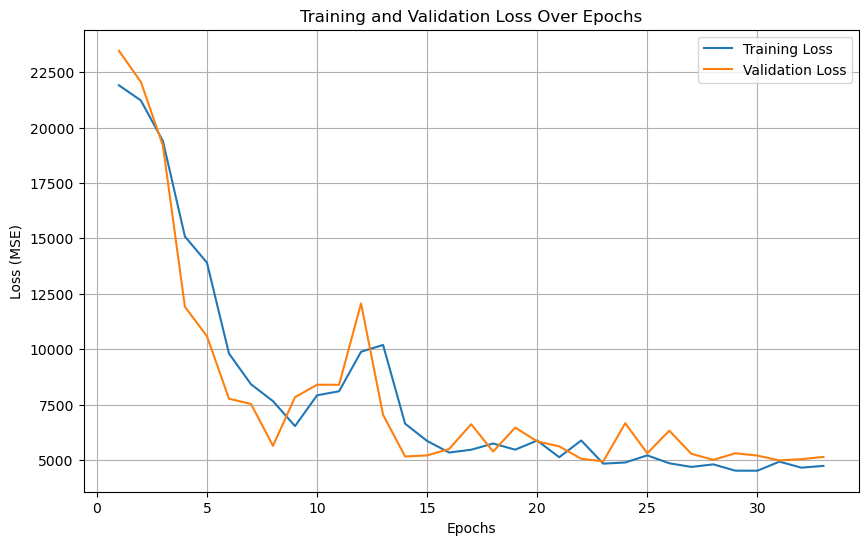

In [70]:
# plotting training and validation loss 
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

| Model Type             | Featurization        |   MAE |  RMSE |   R² | Notes             |
|------------------------|----------------------|-------|-------|------|-------------------|
| Hybrid GNN (Tuned)| OGB smiles2graph + RDKit descriptors | 0.159 | 0.234 | 0.965 | Best   |
| Hybrid GNN (Untuned) | OGB smiles2graph + RDKit descriptors | 0.223 | 0.308 | 0.939 | 2nd best|

# Step 11: Evaluate on test-dev and save the predictions to csv

In [ ]:
# map subset back to original dataset indices
test_indices = split_idx['test-dev']
test_loader = DataLoader(test_dataset, batch_size=64)

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_preds = []
all_ids = [] # store original molecule indices

with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader, desc="Predicting")):
        batch = batch.to(device)
        pred = model(batch)
        all_preds.append(pred.cpu().numpy())

# stack predictions
all_preds = np.vstack(all_preds)

# match predictions to original indices
submission_df = pd.DataFrame({'mol_index': test_indices,  # original indices
                              'prediction': all_preds.flatten()  # flatten to 1D
                              })

# sort by original molecule ID 
submission_df = submission_df.sort_values('mol_index').reset_index(drop=True)

# save to CSV
submission_df.to_csv("hybridgnn_testdev_predictions_with_ids.csv", index=False)
print("Predictions with molecule IDs saved to 'hybridgnn_testdev_predictions_with_ids.csv'")

Predicting: 100%|██████████| 2298/2298 [00:22<00:00, 102.89it/s]


Predictions with molecule IDs saved to 'hybridgnn_testdev_predictions_with_ids.csv'


# Conclusions

## Model Performance Summary

All baseline models were initially trained and evaluated on a 5,000 molecule subset of the full dataset. Below is a comparison of results across different featurization strategies and model types:

### 2D Baseline Models

| Model Type    | Featurization      | MAE   | RMSE  | R²    | Notes                                 |
| ------------- | ------------------ | ----- | ----- | ----- | ------------------------------------- |
| MLP (Tuned)   | RDKit Fingerprints | 0.426 | 0.574 | 0.798 | Strong performance across all metrics |
| KRR (Tuned)   | RDKit Fingerprints | 0.454 | 0.593 | 0.784 | Good overall, slightly lower R²       |
| RF (Tuned)    | RDKit Fingerprints | 0.423 | 0.583 | 0.791 | Best MAE, very competitive overall    |
| MLP (Tuned)   | Coulomb Matrix     | 0.636 | 0.819 | 0.588 | Significantly weaker performance      |
| MLP (Untuned) | RDKit Fingerprints | 0.467 | 0.609 | 0.772 | Solid untuned baseline                |
| KRR (Untuned) | RDKit Fingerprints | 0.519 | 0.668 | 0.726 | Notable drop from tuned version       |
| RF (Untuned)  | RDKit Fingerprints | 0.426 | 0.587 | 0.788 | Surprisingly close to tuned RF        |
| MLP (Untuned) | Coulomb Matrix     | 0.663 | 0.847 | 0.559 | Consistently underperforms            |

### Graph Neural Network Models (ChemML)

| Model Type    | Featurization               | MAE   | RMSE  | R²    | Notes                                |
| ------------- | --------------------------- | ----- | ----- | ----- | ------------------------------------ |
| GNN (Tuned)   | `tensorise_molecules` Graph | 0.302 | 0.411 | 0.900 | Best results from ChemML experiments |
| GNN (Untuned) | `tensorise_molecules` Graph | 0.400 | 0.519 | 0.841 | Strong but less optimized            |

### Final Hybrid GNN Model Trained on Full Dataset (OGB-Compatible)

| Model Type           | Featurization                          | MAE   | RMSE  | R²    | Notes                              |
| -------------------- | -------------------------------------- | ----- | ----- | ----- | ---------------------------------- |
| Hybrid GNN (Tuned)   | OGB `smiles2graph` + RDKit descriptors | 0.159 | 0.234 | 0.965 | State-of-the-art level performance |
| Hybrid GNN (Untuned) | OGB `smiles2graph` + RDKit descriptors | 0.223 | 0.308 | 0.939 | Still very strong pre-tuning       |

---

## Model Error Analysis

I performed qualitative evaluation by comparing predicted vs. true HOMO–LUMO gaps for both randomly selected and poorly predicted molecules. The worst performing molecules often showed rare or complex structures likely underrepresented in the training set. This highlights the importance of structural diversity and potentially more expressive 3D information to improve generalization.

## Next Steps: Integrating 3D Molecular Information

To push performance even further and overcome limitations of 2D graphs and hand crafted descriptors, my next step will involve:

* Using **3D molecular geometries** 
* Incorporating **interatomic distances**, angles, and **spatial encoding** (SchNet, DimeNet, or SE(3)-equivariant models)
* Comparing results against the current best MAE (\~0.159)

This direction aligns with trends in molecular property prediction where 3D aware models often outperform purely 2D approaches, especially for quantum properties like HOMO–LUMO gaps.
